In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as  np
import os

In [7]:
# Sampling layer
class Sampling(layers.Layer):
    "used to sample a vector in latent space with learned mean - z_mean and (log) variance - z_log_var"
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = tf.shape(z_mean)[0]
        vec_len = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch_size, vec_len))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



In [8]:
def encoder_model(input_shape, filters, dense_layer_dim, latent_dim):
    # Create input layer
    encoder_layers_dim = []
    encoder_inputs = keras.Input(shape=input_shape)
    encoder_layers_dim.append(tuple(encoder_inputs.shape[1:]))
    # Add convolutional layers with specified number of filters and activation function
    x = layers.Conv2D(filters[0], (3,3), activation="relu", strides=2, padding="same")(encoder_inputs)
    encoder_layers_dim.append(tuple(x.shape[1:]))
    # x = MaxPooling2D((2, 2), padding="same")(x)
    # Add additional convolutional layers with specified number of filters and activation function
    mid_layers = [layers.Conv2D(f, 3, activation="relu", strides=2, padding="same") for f in filters[1:]]
    for mid_layer in mid_layers:
        x = mid_layer(x)
        encoder_layers_dim.append(tuple(x.shape[1:]))
        # x = MaxPooling2D((2, 2), padding="same")(x)
    
    # Flatten convolutional output to prepare for dense layers
    x = layers.Flatten()(x)
    encoder_layers_dim.append(tuple(x.shape[1:]))
    # Add dense layer with specified number of neurons and activation function
    x = layers.Dense(dense_layer_dim, activation='relu')(x)
    
    # Add output layers for latent space (mean and variance) and sample from this space
    z_mean = layers.Dense(latent_dim, name = "z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder_layers_dim.append(tuple(z.shape[1:]))
    
    # Create encoder model
    return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder'), encoder_layers_dim
test_encoder, encoder_layers_dim = encoder_model(input_shape = (28,28,1), filters=[32, 64], dense_layer_dim=16, latent_dim=2)
test_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [9]:
encoder_layers_dim

[(28, 28, 1), (14, 14, 32), (7, 7, 64), (3136,), (2,)]

In [10]:

latent_dim = encoder_layers_dim[-1][0]
dense_layer_dim = encoder_layers_dim[-2][0]
latent_dim, dense_layer_dim
encoder_layers_dim[1:-2]

[(14, 14, 32), (7, 7, 64)]

In [11]:
# decoder
def decoder_model(encoder_layers_dim):
    latent_dim = encoder_layers_dim[-1][0]
    dense_layer_dim = encoder_layers_dim[-2][0]
    first_conv_layer_dim = encoder_layers_dim[-3]
    latent_inputs = keras.Input(shape=(latent_dim,))
    filters = [f[-1] for f in encoder_layers_dim[1:-2]]
    output_layer = encoder_layers_dim[0]

    # feed latent vector through a dense layer with ReLU activation
    # note that we apply the first filter in the form of dense and reshape it
    x = layers.Dense(dense_layer_dim, activation="relu")(latent_inputs)
    # reshape output from dense layer to match dimensions of first convolutional layer
    x = layers.Reshape(first_conv_layer_dim)(x)
    # apply series of transpose convolutional layers with ReLU activation and same padding and Upsampling
    mid_layers = [layers.Conv2DTranspose(f, 3, activation="relu", strides=2, padding="same") for f in filters[::-1]]
    for mid_layer in mid_layers:
        x = mid_layer(x)
    
    # apply final convolutional layer with sigmoid activation to output reconstructed image
    decoder_outputs = layers.Conv2DTranspose(output_layer[-1], 3, activation="sigmoid", padding="same")(x)
    
    # create and return Keras model with latent vector as input and reconstructed image as output
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")
test_decoder = decoder_model(encoder_layers_dim)
test_decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [12]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    def call(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, z, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # z_mean, z_log_var, z = self.encoder(data)
            # reconstruction = self.decoder(z)
            z_mean, z_log_var, z, reconstruction = self(data)
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_sum(
            #         keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            #     )
            # )
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction), axis = (1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [13]:
encoder, encoder_layers_dim = encoder_model(input_shape = (28,28,1), filters=[32, 64], dense_layer_dim=16, latent_dim=2)
decoder = decoder_model(encoder_layers_dim)


In [14]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(mnist_digits, epochs=300, batch_size=128)


11493376/11490434 [==============================] - 2s 0us/step
Epoch 1/300
547/547 [==============================] - 10s 5ms/step - loss: 254.9634 - reconstruction_loss: 200.7626 - kl_loss: 2.7502
Epoch 2/300
547/547 [==============================] - 3s 5ms/step - loss: 166.4805 - reconstruction_loss: 159.6161 - kl_loss: 4.8793
Epoch 3/300
547/547 [==============================] - 3s 5ms/step - loss: 160.2436 - reconstruction_loss: 154.6388 - kl_loss: 5.2771
Epoch 4/300
547/547 [==============================] - 3s 5ms/step - loss: 158.0650 - reconstruction_loss: 152.2926 - kl_loss: 5.4450
Epoch 5/300
547/547 [==============================] - 3s 5ms/step - loss: 156.5789 - reconstruction_loss: 150.6945 - kl_loss: 5.5639
Epoch 6/300
547/547 [==============================] - 3s 6ms/step - loss: 155.4114 - reconstruction_loss: 149.4358 - kl_loss: 5.6704
Epoch 7/300
547/547 [==============================] - 3s 5ms/step - loss: 154.3665 - reconstruction_loss: 148.4176 - kl_loss: 5.7

In [18]:
import matplotlib.pyplot as plt

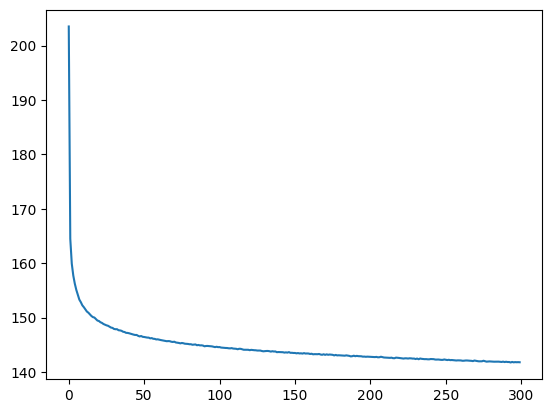

In [24]:
plt.plot(history.history['loss'])


In [25]:
history2 = vae.fit(mnist_digits, epochs=1000, batch_size=128)

Epoch 1/1000
547/547 [==============================] - 3s 5ms/step - loss: 141.7068 - reconstruction_loss: 134.7720 - kl_loss: 6.9726
Epoch 2/1000
547/547 [==============================] - 2s 5ms/step - loss: 141.9894 - reconstruction_loss: 134.8578 - kl_loss: 6.9734
Epoch 3/1000
547/547 [==============================] - 2s 5ms/step - loss: 141.7064 - reconstruction_loss: 134.8031 - kl_loss: 6.9688
Epoch 4/1000
547/547 [==============================] - 2s 5ms/step - loss: 141.8588 - reconstruction_loss: 134.7685 - kl_loss: 6.9674
Epoch 5/1000
547/547 [==============================] - 2s 4ms/step - loss: 142.0807 - reconstruction_loss: 134.7626 - kl_loss: 6.9795
Epoch 6/1000
547/547 [==============================] - 2s 5ms/step - loss: 141.4593 - reconstruction_loss: 134.7267 - kl_loss: 6.9752
Epoch 7/1000
547/547 [==============================] - 3s 5ms/step - loss: 141.7227 - reconstruction_loss: 134.8141 - kl_loss: 6.9753
Epoch 8/1000
547/547 [==============================] -

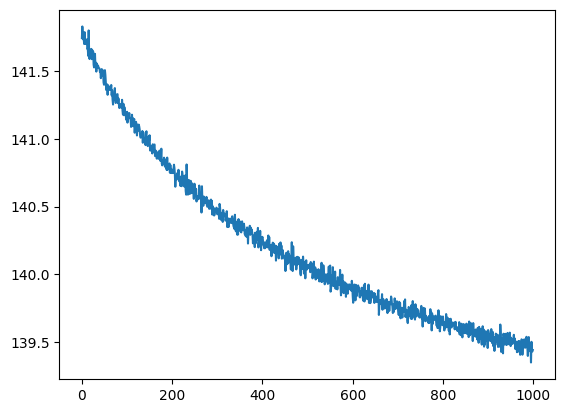

In [27]:
plt.plot(history2.history['loss'])

Epoch 1/2000
547/547 [==============================] - 3s 5ms/step - loss: 139.6196 - reconstruction_loss: 132.2000 - kl_loss: 7.2731
Epoch 2/2000
547/547 [==============================] - 3s 5ms/step - loss: 139.0451 - reconstruction_loss: 132.1611 - kl_loss: 7.2845
Epoch 3/2000
547/547 [==============================] - 3s 5ms/step - loss: 139.3908 - reconstruction_loss: 132.1584 - kl_loss: 7.2859
Epoch 4/2000
547/547 [==============================] - 3s 5ms/step - loss: 139.2062 - reconstruction_loss: 132.1979 - kl_loss: 7.2726
Epoch 5/2000
547/547 [==============================] - 3s 5ms/step - loss: 139.5440 - reconstruction_loss: 132.1670 - kl_loss: 7.2885
Epoch 6/2000
547/547 [==============================] - 3s 5ms/step - loss: 139.4464 - reconstruction_loss: 132.1711 - kl_loss: 7.2768
Epoch 7/2000
547/547 [==============================] - 3s 5ms/step - loss: 139.2629 - reconstruction_loss: 132.1942 - kl_loss: 7.2715
Epoch 8/2000
547/547 [==============================] -

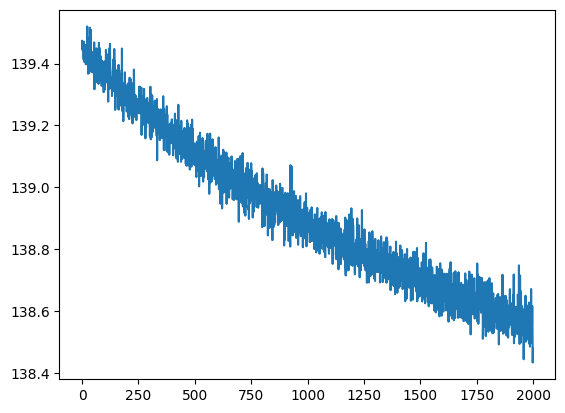

In [28]:
history3 = vae.fit(mnist_digits, epochs=2000, batch_size=128)

plt.plot(history3.history['loss'])

In [29]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

class DecodeCallback(tf.keras.callbacks.Callback):
    def __init__(self, vae, test_input):
        self.vae = vae
        self.test_input = test_input

    def on_epoch_end(self, epoch, logs=None):
        # Generate decoded images from the test input
        decoded_imgs = self.vae.decoder.predict(self.test_input)

        # Reshape the decoded images to be 28x28 and convert to grayscale
        decoded_imgs = np.reshape(decoded_imgs, (-1, 28, 28))
        decoded_imgs = np.expand_dims(decoded_imgs, axis=-1)

        # Plot and save the decoded images
        plt.figure(figsize=(10, 10))
        for i in range(decoded_imgs.shape[0]):
            plt.subplot(10, 10, i+1)
            plt.imshow(decoded_imgs[i], cmap='gray')
            plt.axis('off')
        plt.savefig('decoded_images_epoch_{:04d}.png'.format(epoch))
        plt.show()

In [49]:
class DecodeCallback(tf.keras.callbacks.Callback):
    def __init__(self, vae, test_input):
        self.vae = vae
        self.test_input = test_input

    def on_epoch_end(self, epoch, logs=None):
        # Generate decoded images from the test input
        decoded_imgs = self.vae.decoder.predict(self.test_input)

        # Reshape the decoded images to be 28x28 and convert to grayscale
        decoded_imgs = np.reshape(decoded_imgs, (-1, 28, 28))
        decoded_imgs = np.expand_dims(decoded_imgs, axis=-1)

        # Plot and save the decoded images
        plt.figure(figsize=(10, 10))
        for i in range(decoded_imgs.shape[0]):
            plt.subplot(10, 10, i+1)
            plt.imshow(decoded_imgs[i], cmap='gray')
            plt.axis('off')
        plt.savefig('decoded_images_epoch_{:04d}.png'.format(epoch))
        plt.show()
class VAECallback(tf.keras.callbacks.Callback):
    def __init__(self, vae, test_data, n=10):
        self.vae = vae
        self.test_data = test_data
        self.n = n
    def on_epoch_end(self, epoch, logs=None):
        # Select 10 random test images
        idx = np.random.randint(0, self.test_data.shape[0], self.n)
        test_images = self.test_data[idx]

        # Generate predictions for the selected test images
        z_mean, z_log_var, z, decoded_images = self.vae.predict(test_images)

        # Reshape the decoded images to be 28x28 and convert to grayscale
        decoded_images = np.reshape(decoded_images, (-1, 28, 28))
        decoded_images = np.expand_dims(decoded_images, axis=-1)

        # Plot the original and predicted images side by side
        fig, axs = plt.subplots(self.n, 2, figsize=(self.n, 25))
        for i in range(self.n):
            axs[i, 0].imshow(test_images[i].squeeze(), cmap='gray')
            axs[i, 0].axis('off')
            axs[i, 1].imshow(decoded_images[i].squeeze(), cmap='gray')
            axs[i, 1].axis('off')
        plt.savefig('decoded_images_epoch_{:04d}.png'.format(epoch))
        plt.show()


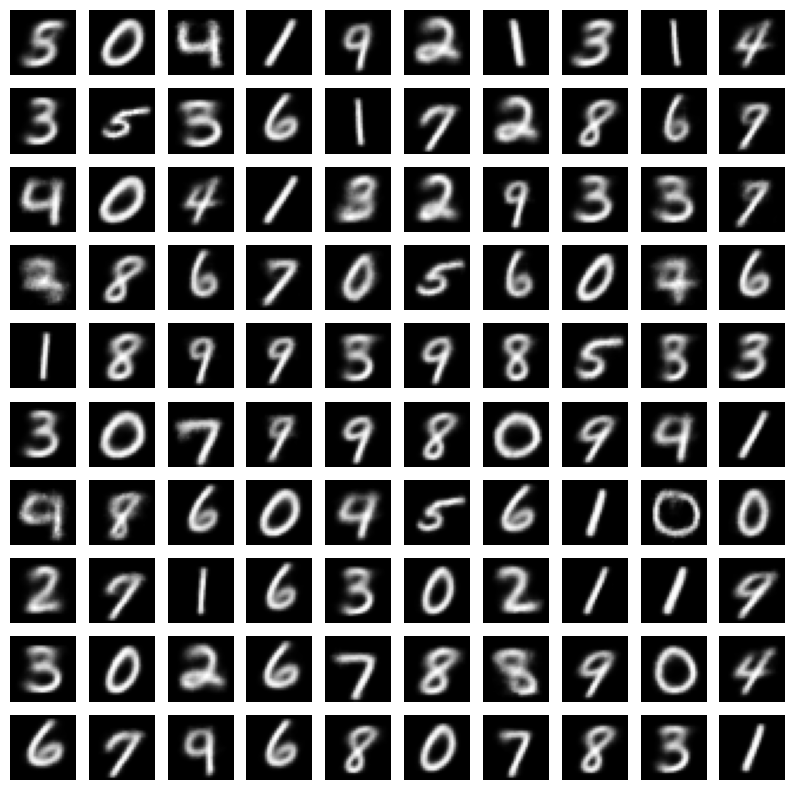

In [46]:
test_image = mnist_digits[:100].reshape((100, 28, 28, 1))
z_mean, z_log_var, z, reconstruction= vae.predict(test_image)
# Reshape the decoded images to be 28x28 and convert to grayscale
decoded_imgs = np.reshape(reconstruction, (-1, 28, 28))
decoded_imgs = np.expand_dims(decoded_imgs, axis=-1)

# Plot and save the decoded images
plt.figure(figsize=(10, 10))
for i in range(decoded_imgs.shape[0]):
    plt.subplot(10, 10, i+1)
    plt.imshow(decoded_imgs[i], cmap='gray')
    plt.axis('off')
plt.savefig('decoded_images_epoch_{:04d}.png'.format(0))
plt.show()




Epoch 1/300
2188/2188 [==============================] - 49s 22ms/step - loss: 141.4043 - reconstruction_loss: 133.8927 - kl_loss: 7.1462


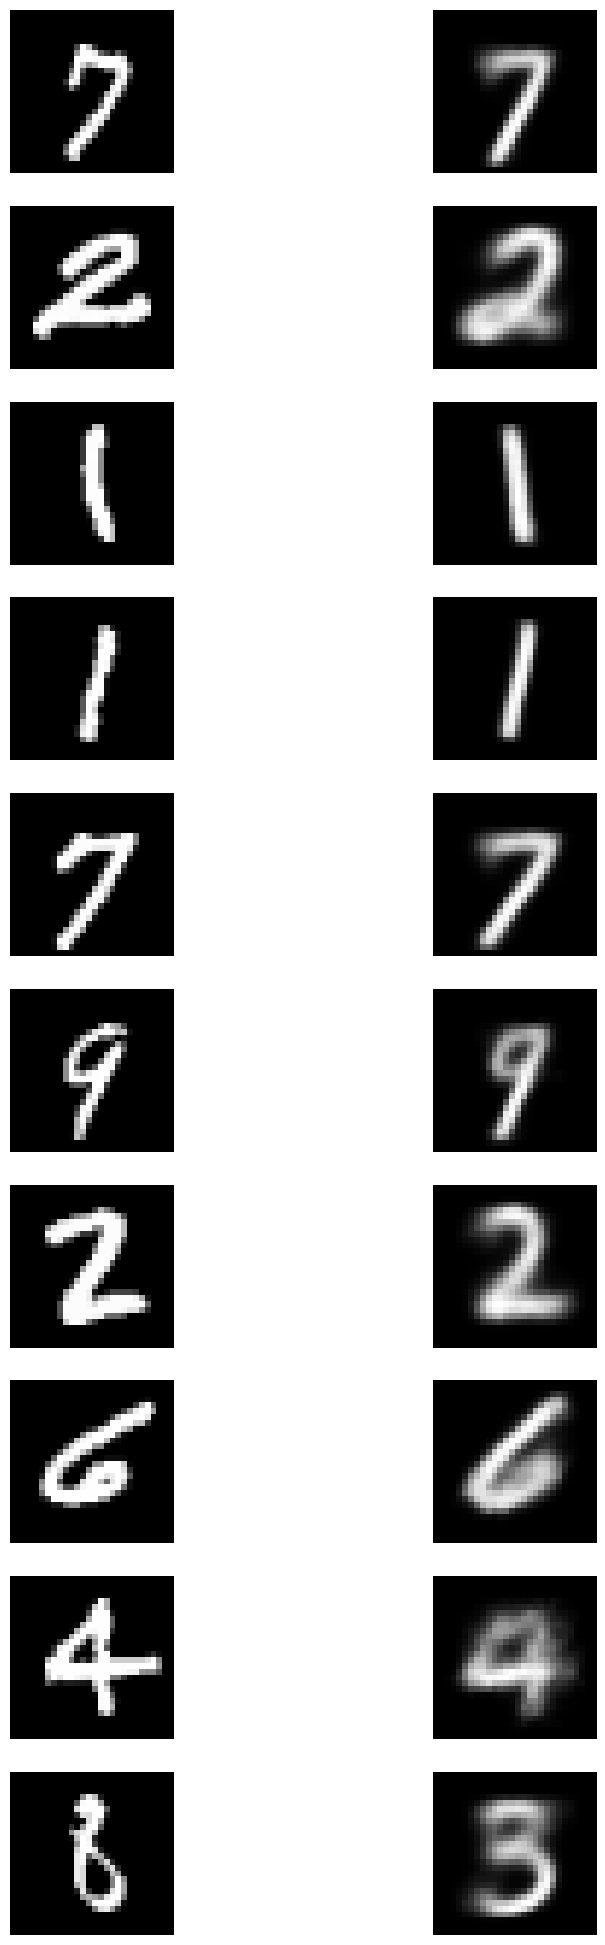

Epoch 2/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.2025 - reconstruction_loss: 134.0109 - kl_loss: 7.1574


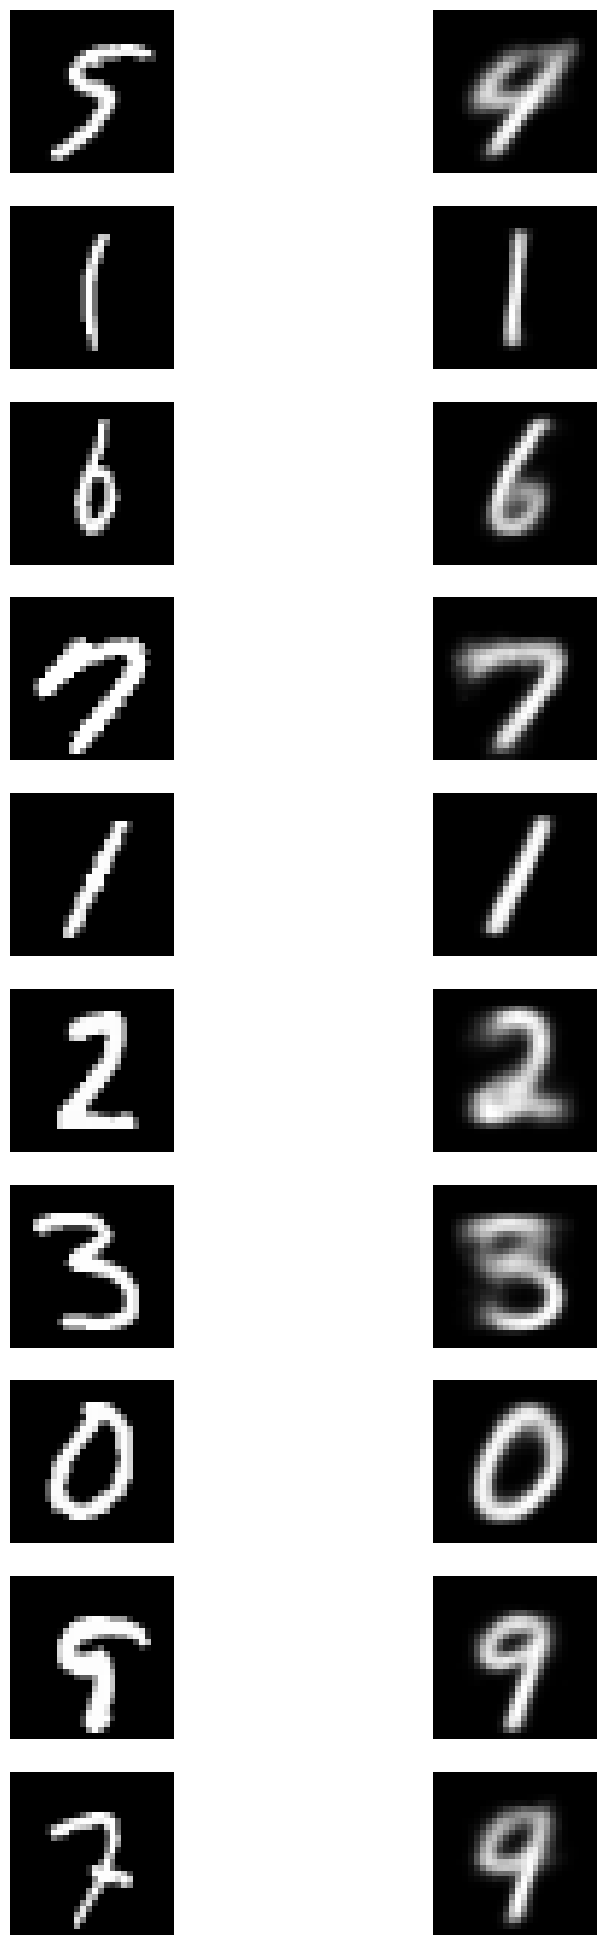

Epoch 3/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.0613 - reconstruction_loss: 133.9625 - kl_loss: 7.1662


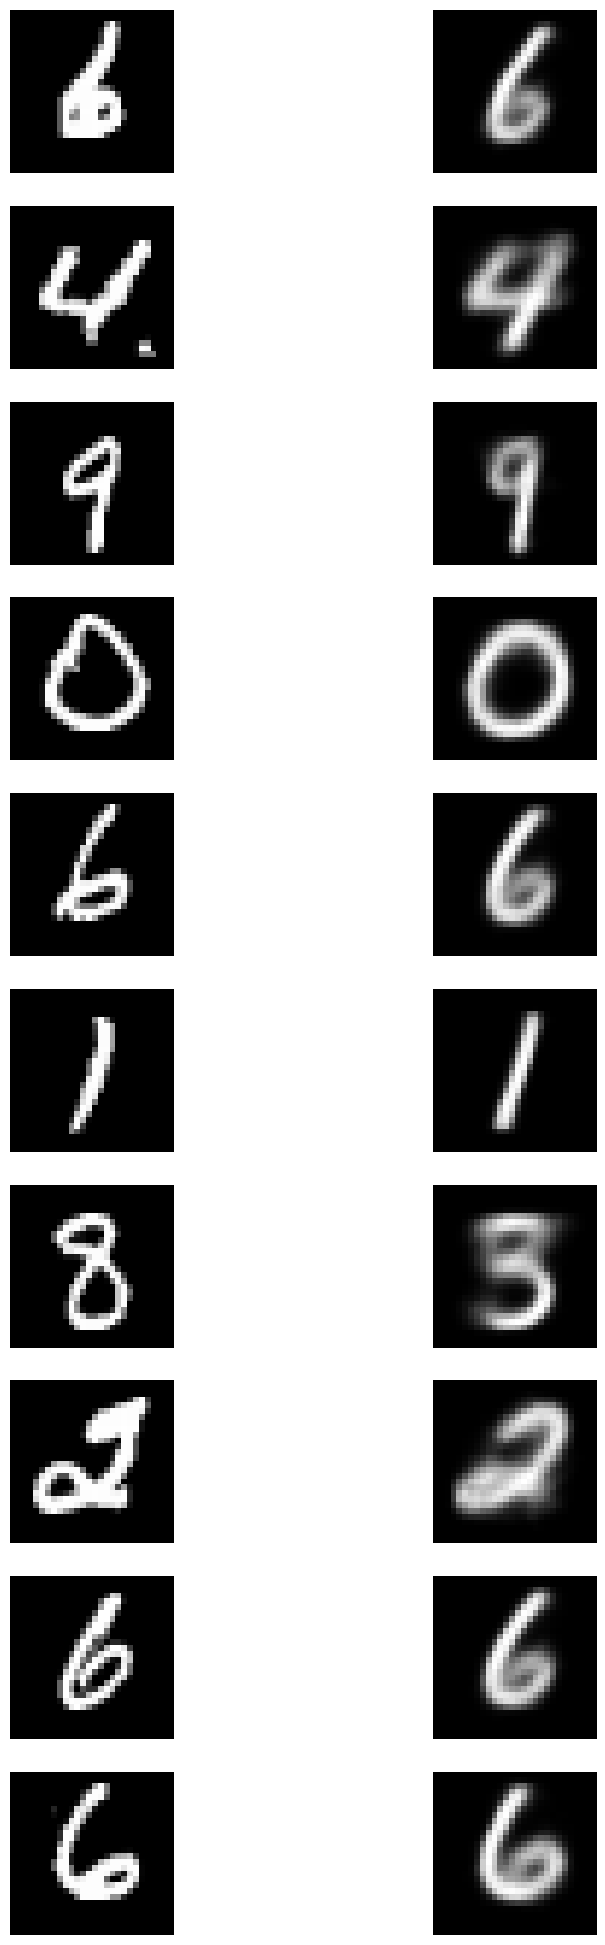

Epoch 4/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.6592 - reconstruction_loss: 133.9904 - kl_loss: 7.1461


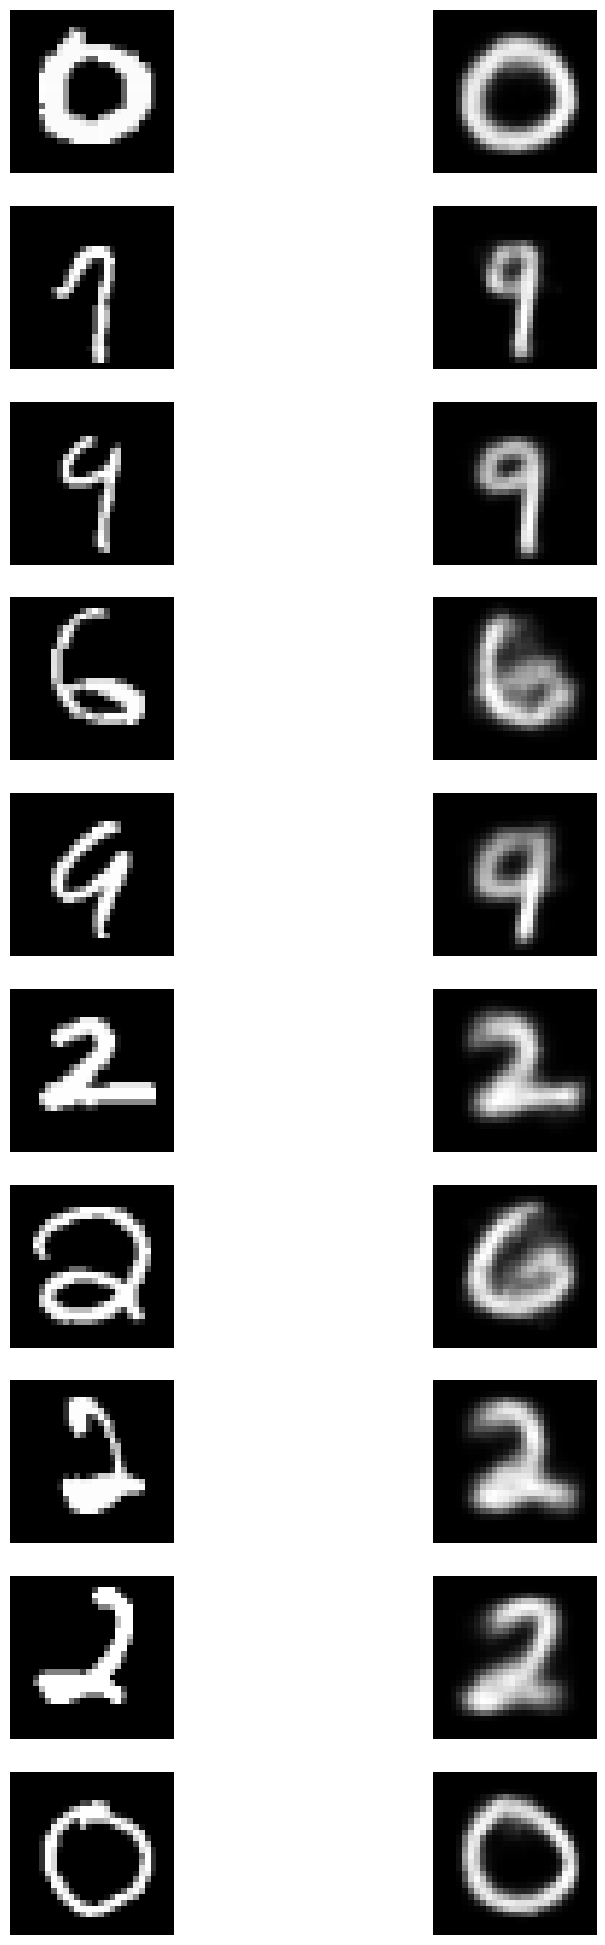

Epoch 5/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.8604 - reconstruction_loss: 133.9235 - kl_loss: 7.1417


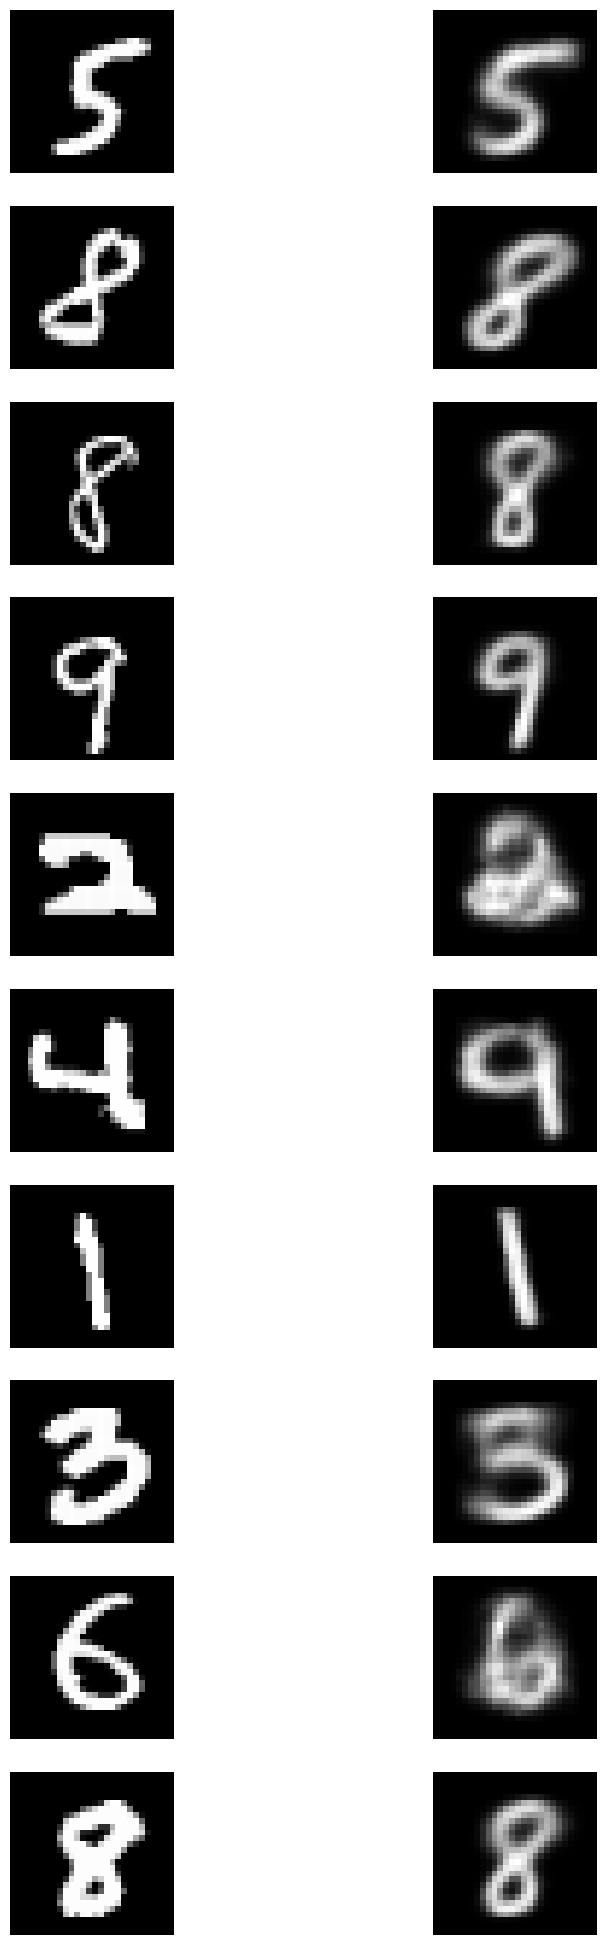

Epoch 6/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.7891 - reconstruction_loss: 133.9039 - kl_loss: 7.1527


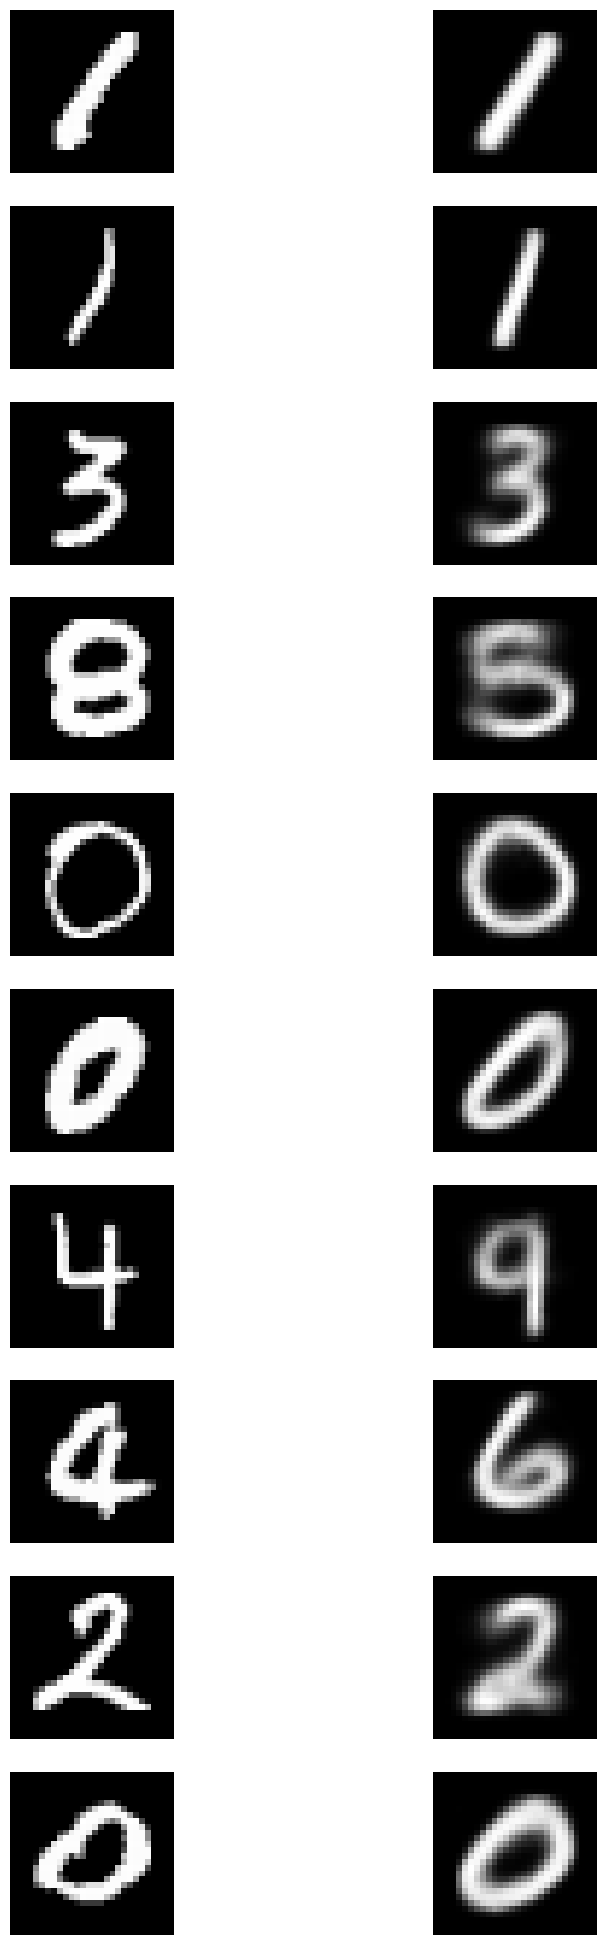

Epoch 7/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.8584 - reconstruction_loss: 134.0048 - kl_loss: 7.1514


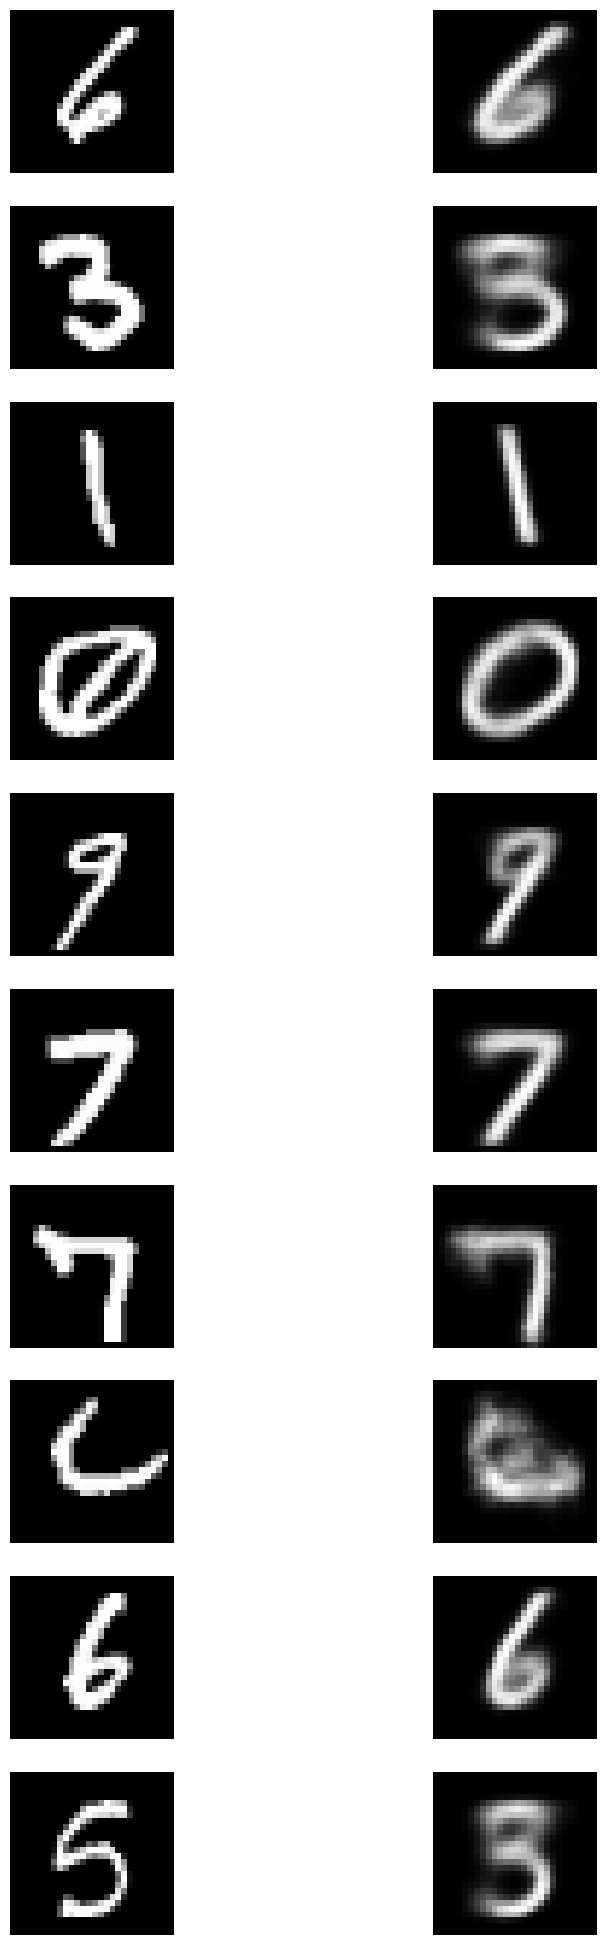

Epoch 8/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.3227 - reconstruction_loss: 134.0710 - kl_loss: 7.1445


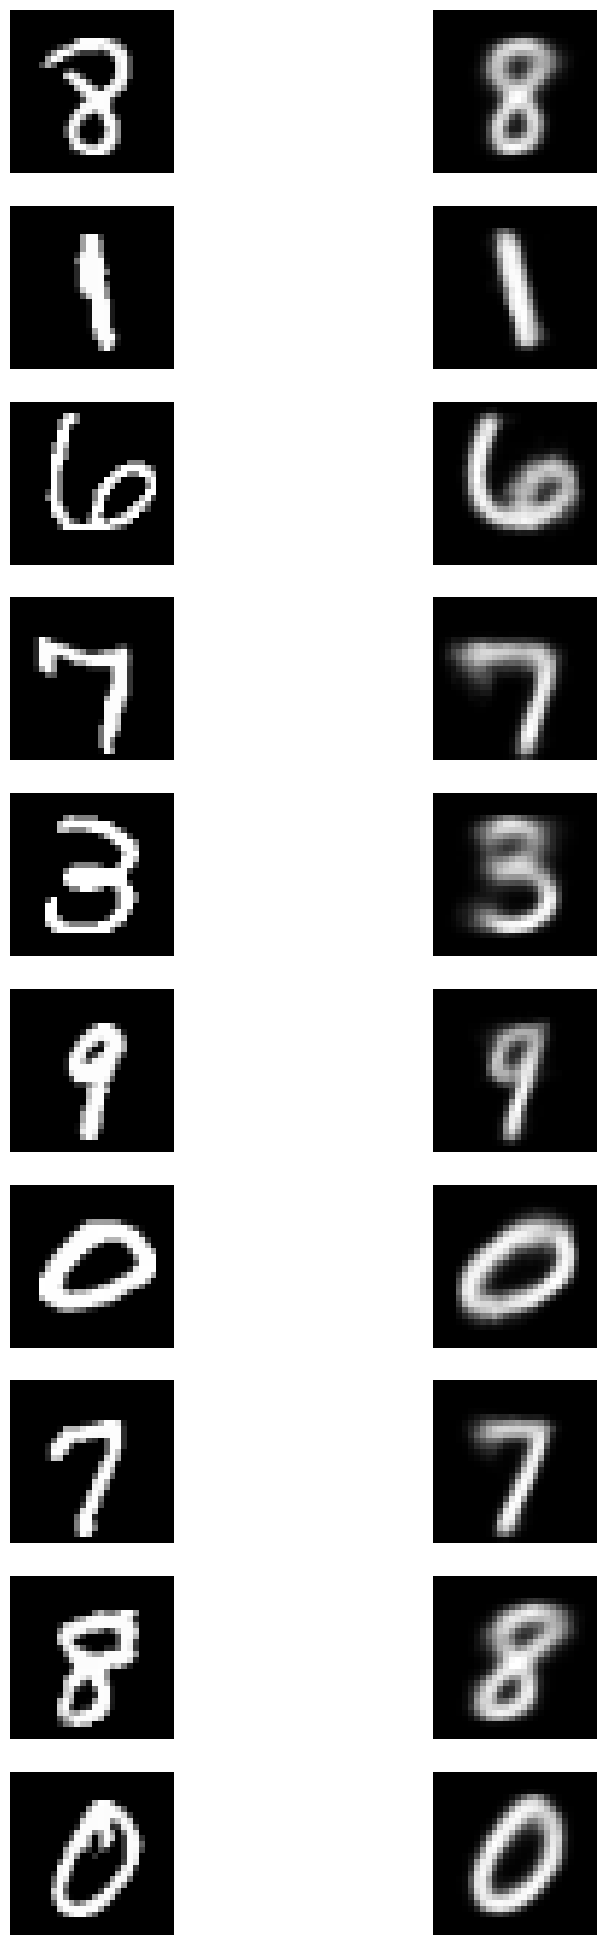

Epoch 9/300
2188/2188 [==============================] - 7s 3ms/step - loss: 140.9734 - reconstruction_loss: 133.9487 - kl_loss: 7.1556


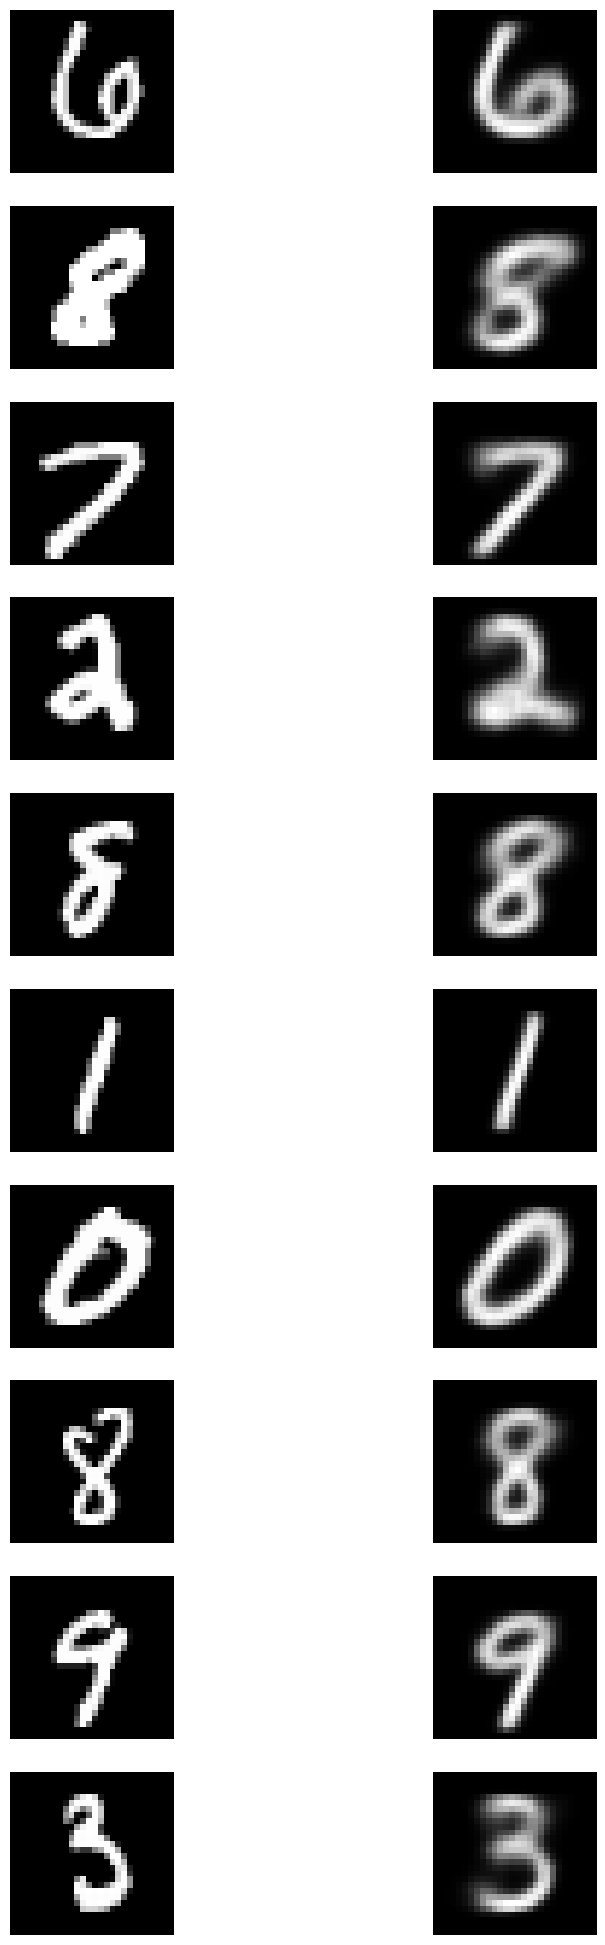

Epoch 10/300
2188/2188 [==============================] - 8s 3ms/step - loss: 140.6750 - reconstruction_loss: 133.9440 - kl_loss: 7.1388


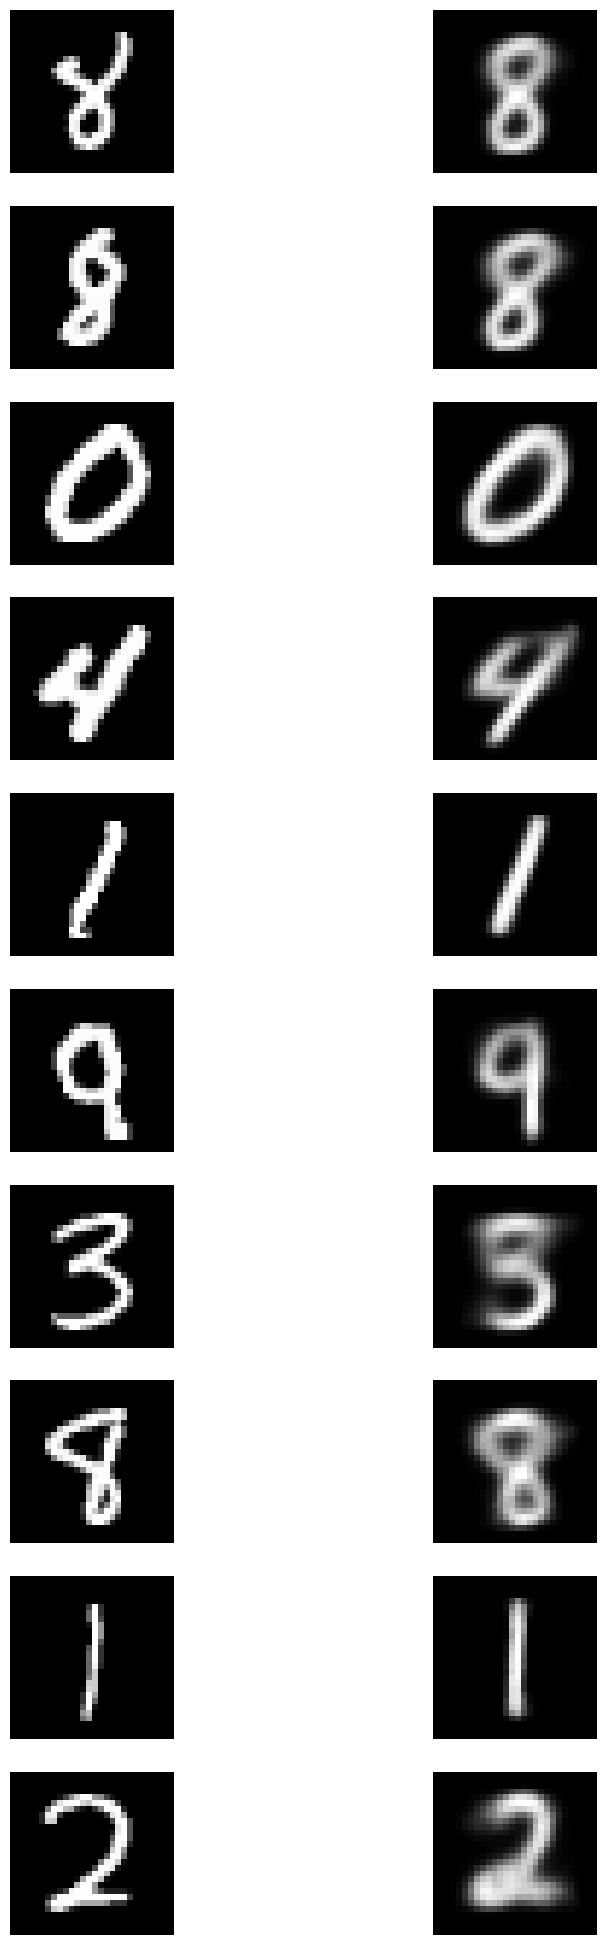

Epoch 11/300
2188/2188 [==============================] - 92s 42ms/step - loss: 141.0444 - reconstruction_loss: 134.0893 - kl_loss: 7.1422


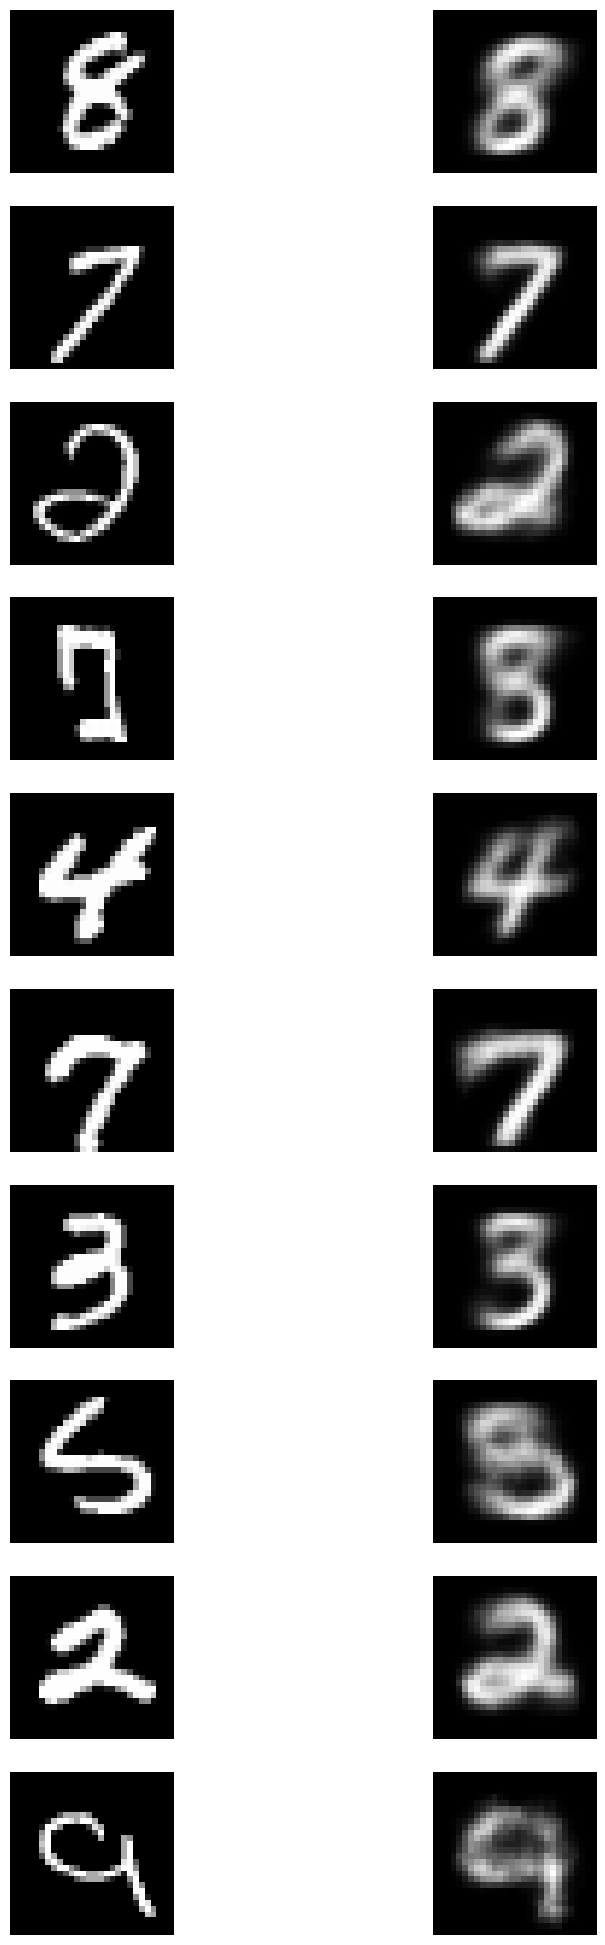

Epoch 12/300
2188/2188 [==============================] - 268s 123ms/step - loss: 140.9336 - reconstruction_loss: 133.8669 - kl_loss: 7.1501


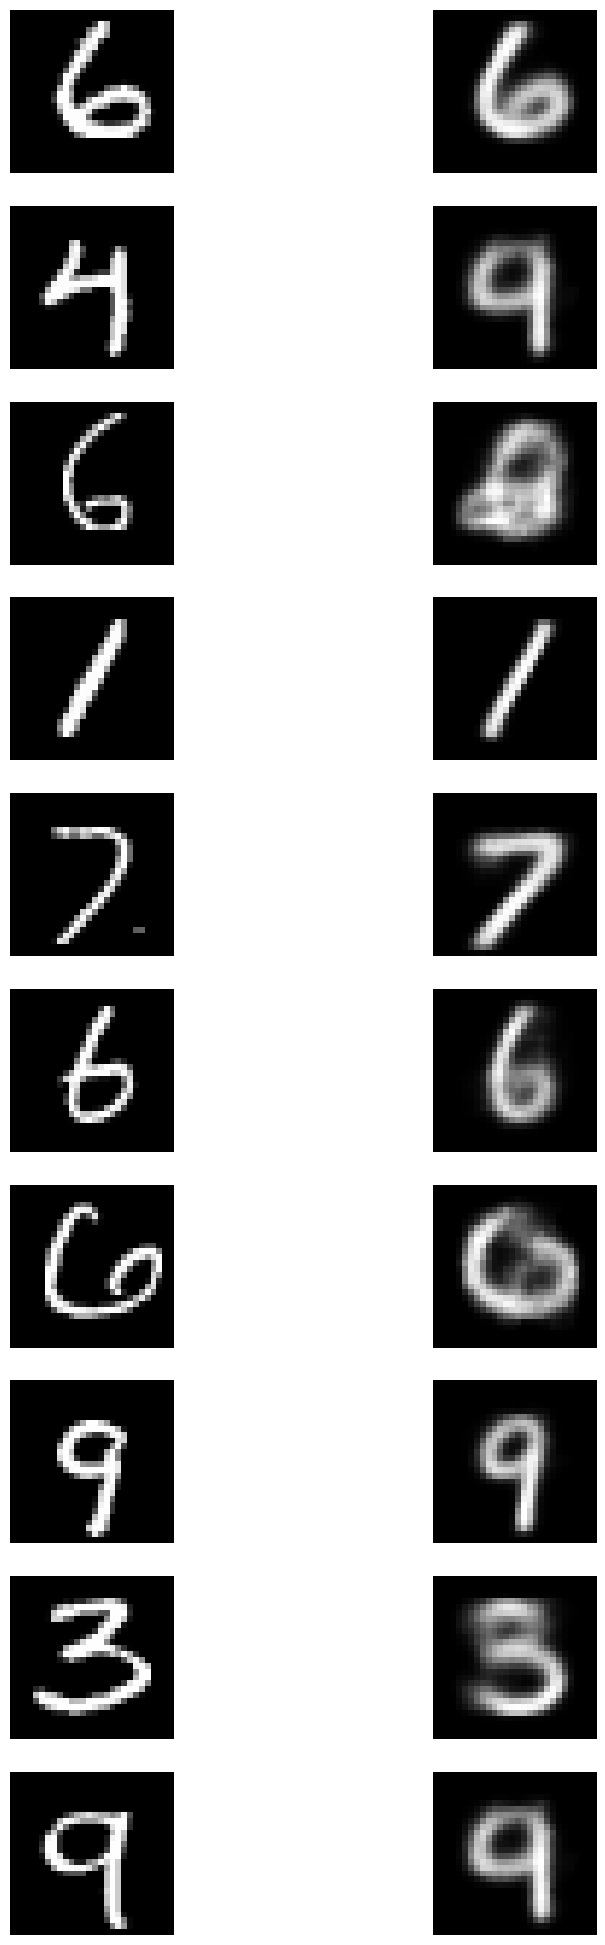

Epoch 13/300
2188/2188 [==============================] - 41s 19ms/step - loss: 140.8605 - reconstruction_loss: 133.9152 - kl_loss: 7.1519


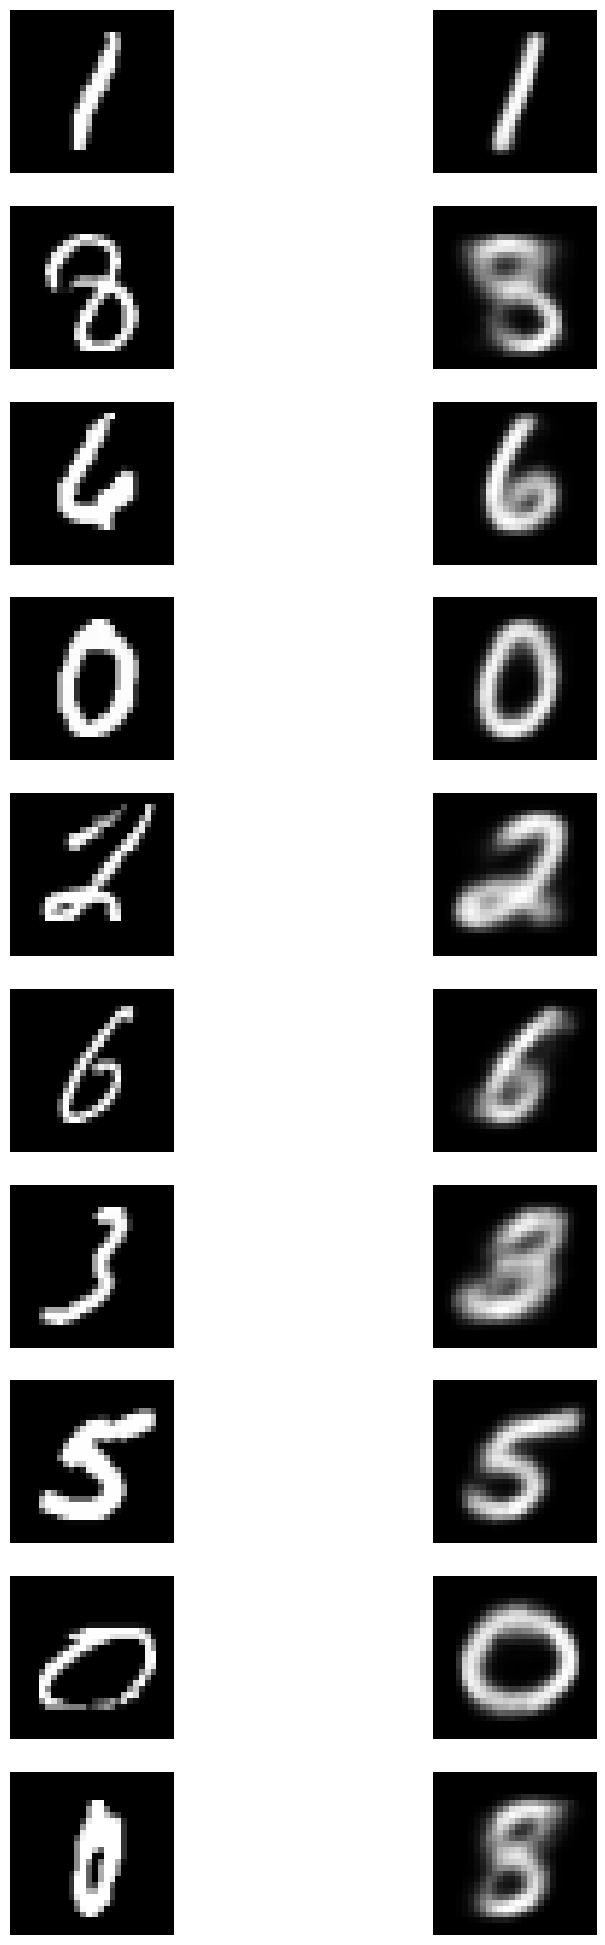

Epoch 14/300
2188/2188 [==============================] - 9s 4ms/step - loss: 140.7091 - reconstruction_loss: 134.0556 - kl_loss: 7.1261


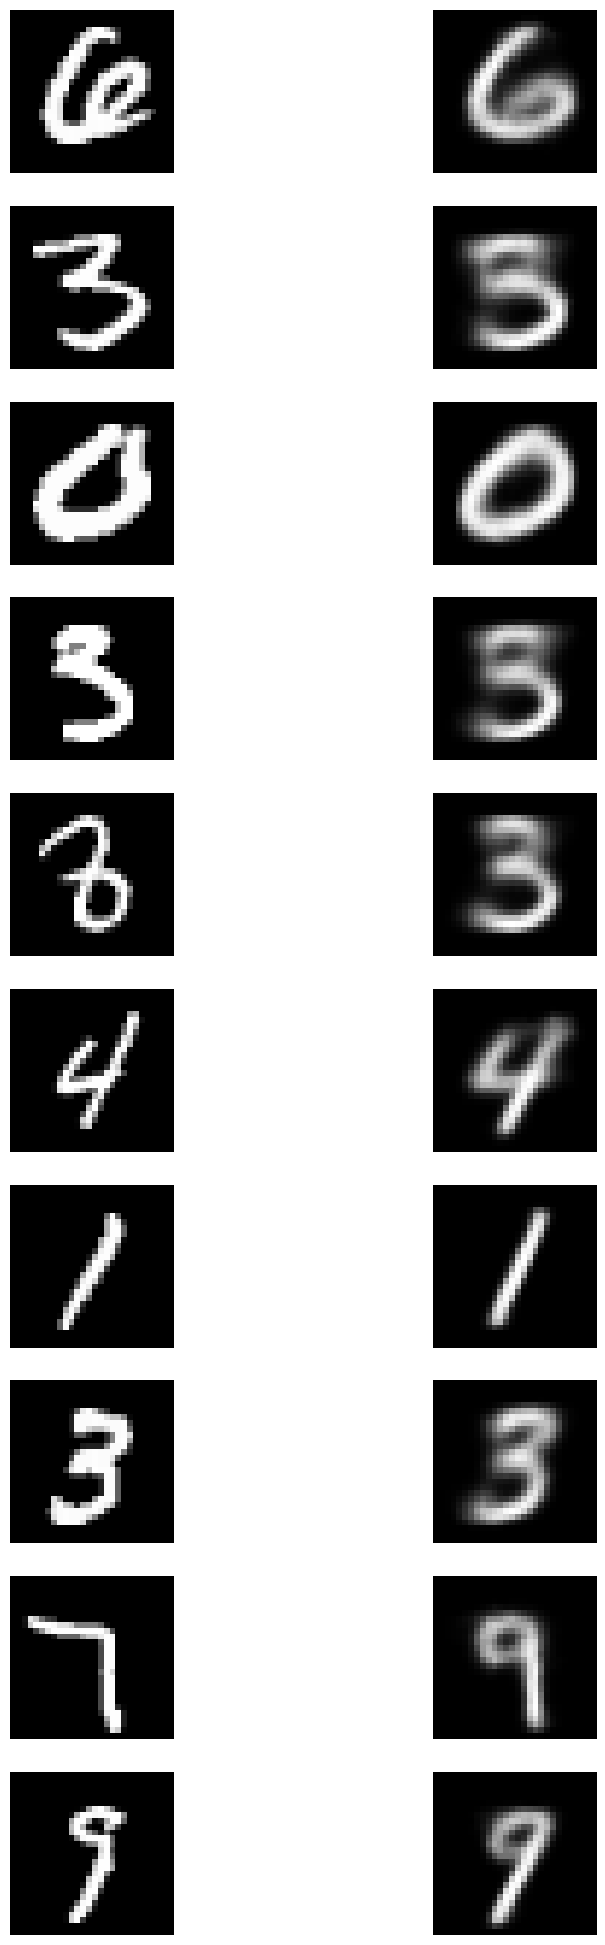

Epoch 15/300
2188/2188 [==============================] - 11s 5ms/step - loss: 141.0138 - reconstruction_loss: 134.0363 - kl_loss: 7.1214


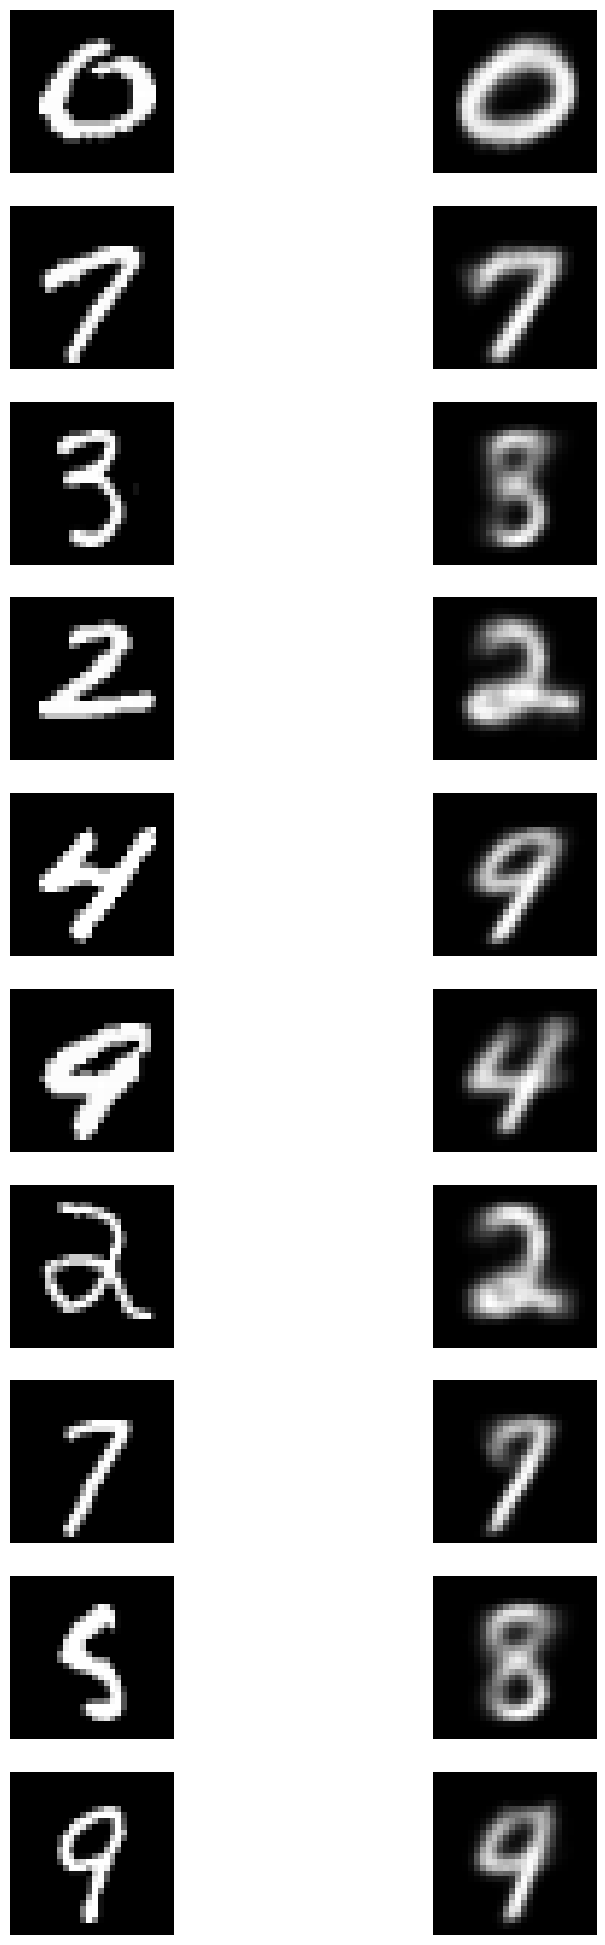

Epoch 16/300
2188/2188 [==============================] - 11s 5ms/step - loss: 141.1451 - reconstruction_loss: 134.1072 - kl_loss: 7.1308


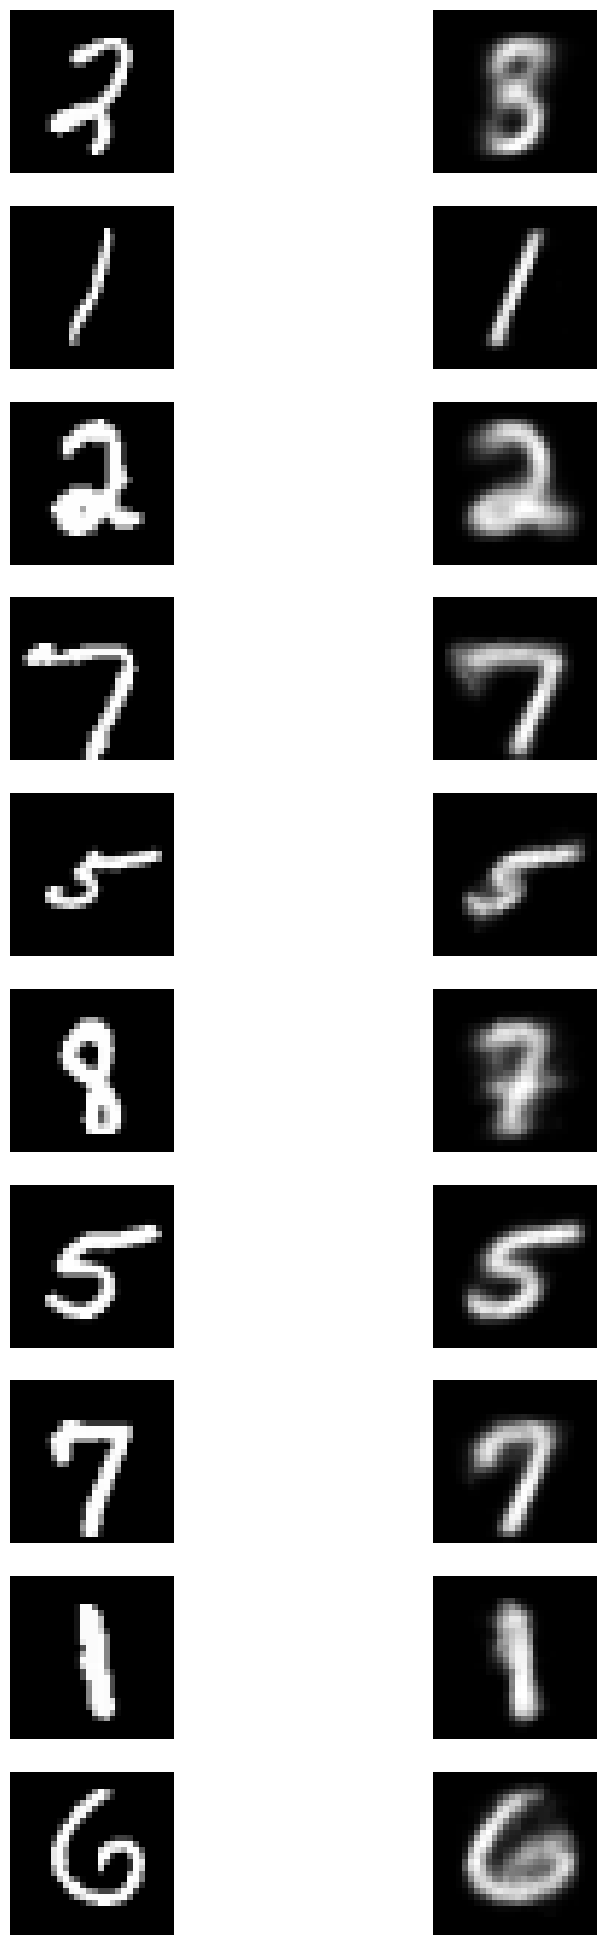

Epoch 17/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.9817 - reconstruction_loss: 133.9977 - kl_loss: 7.1409


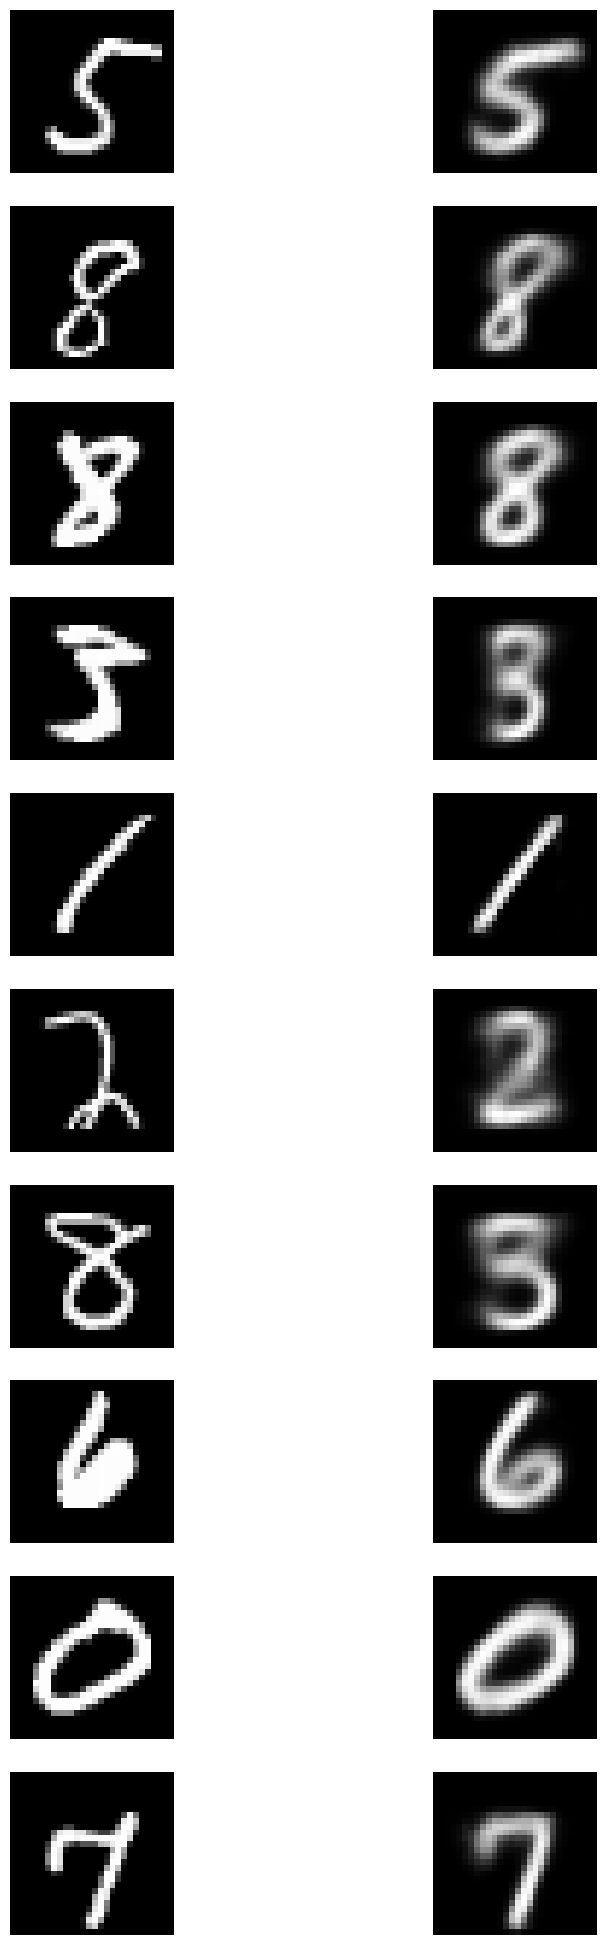

Epoch 18/300
2188/2188 [==============================] - 9s 4ms/step - loss: 140.8101 - reconstruction_loss: 134.0435 - kl_loss: 7.1271


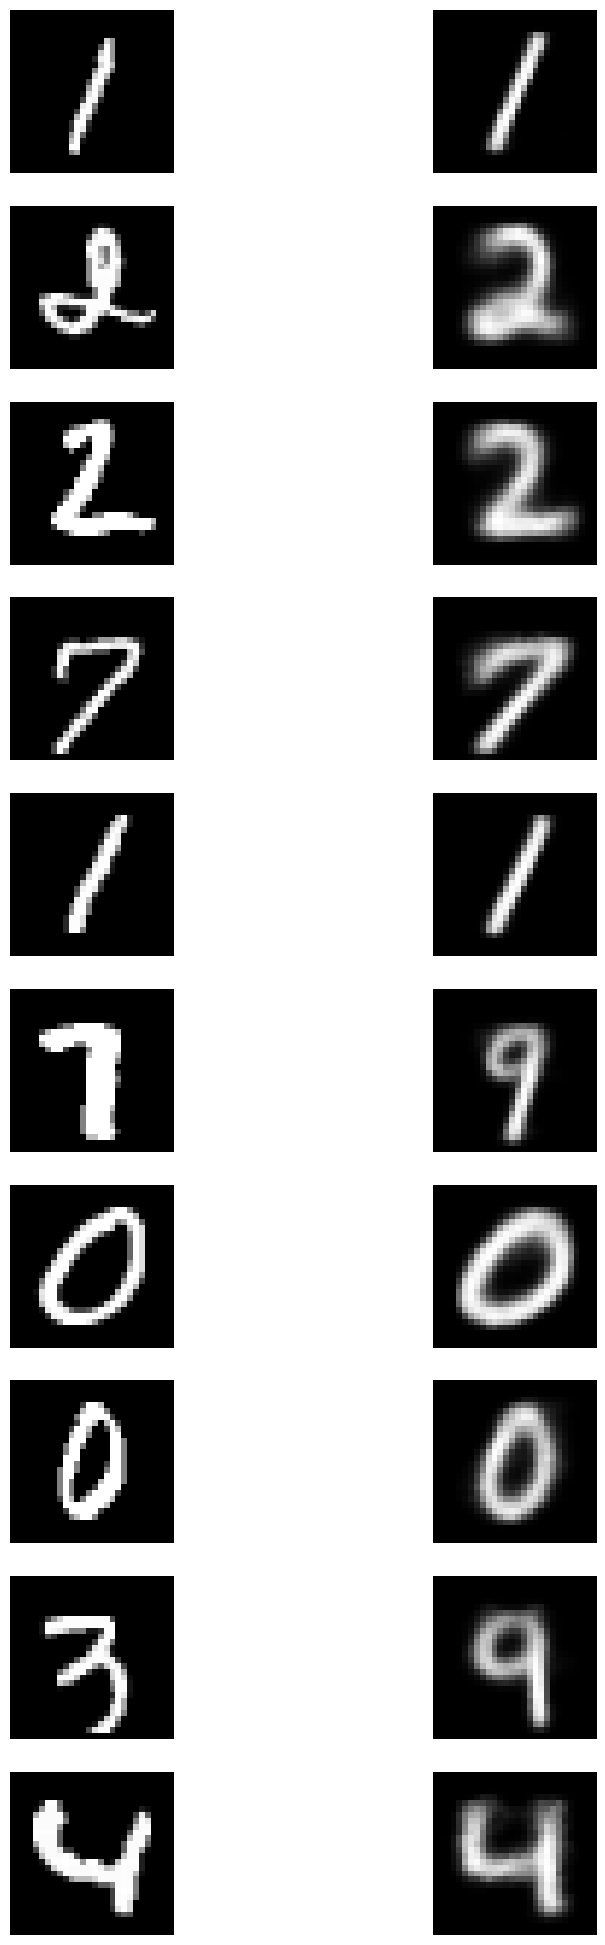

Epoch 19/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.8903 - reconstruction_loss: 133.9725 - kl_loss: 7.1356


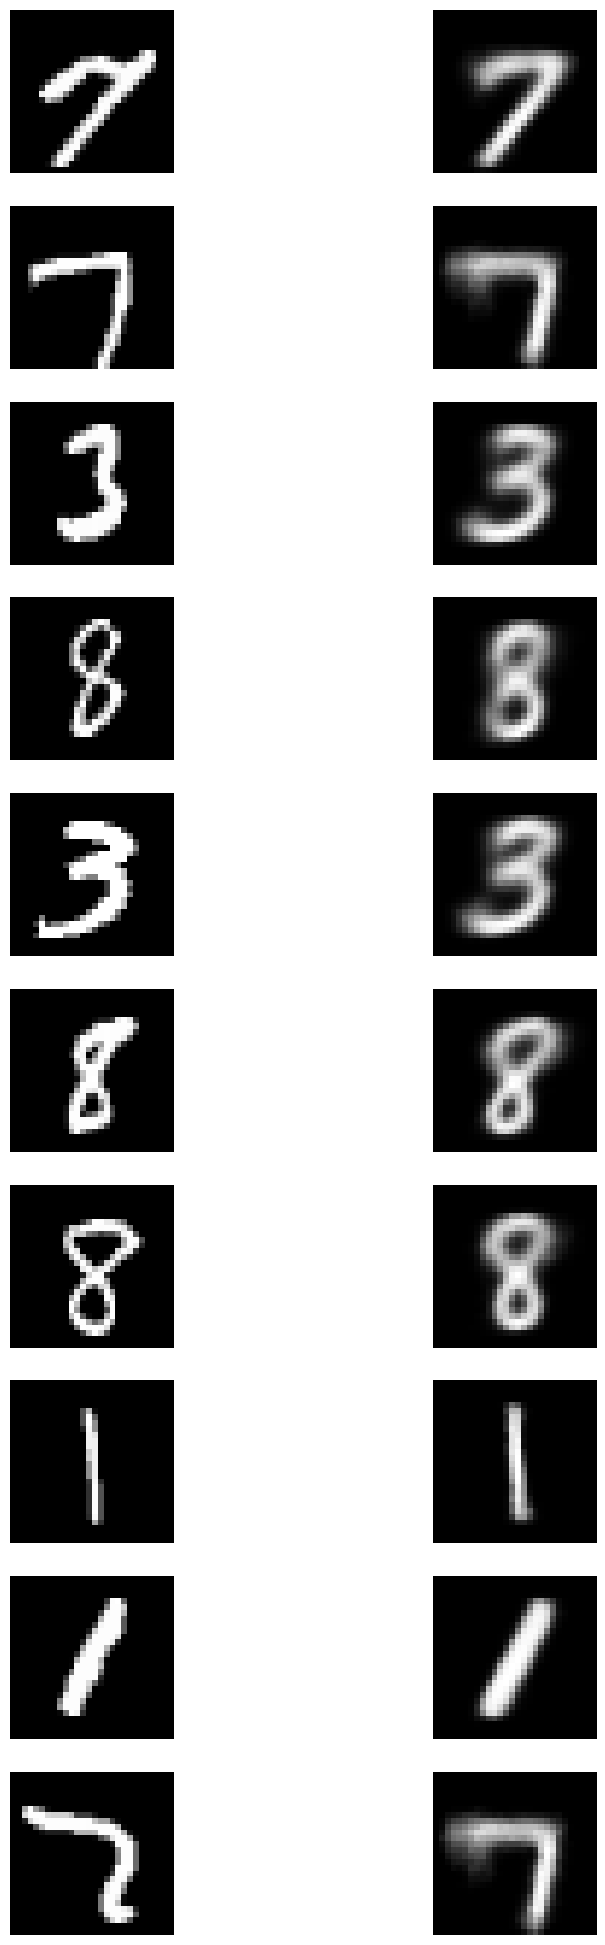

Epoch 20/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.2275 - reconstruction_loss: 134.0719 - kl_loss: 7.1496


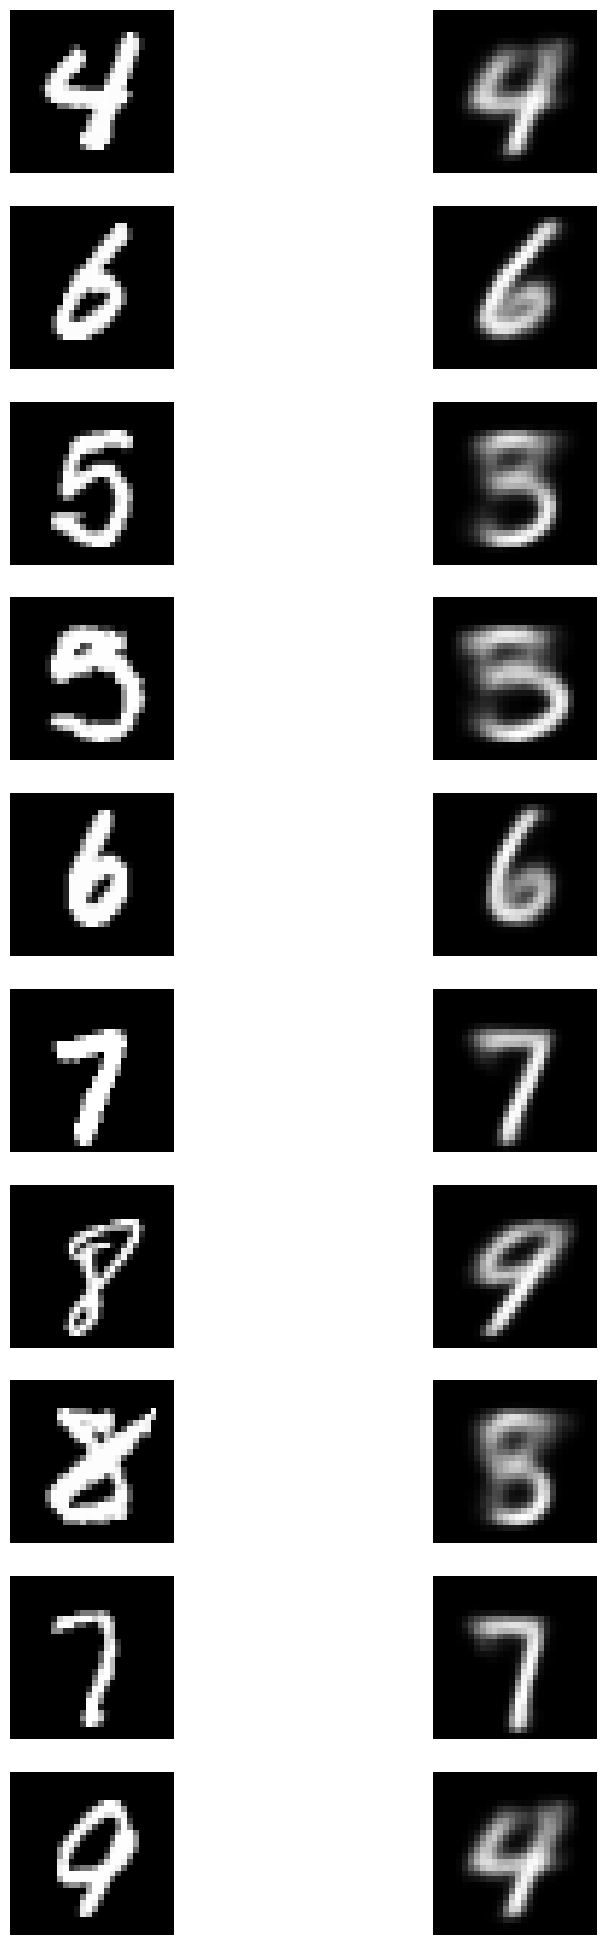

Epoch 21/300
2188/2188 [==============================] - 9s 4ms/step - loss: 140.8491 - reconstruction_loss: 134.0487 - kl_loss: 7.1283


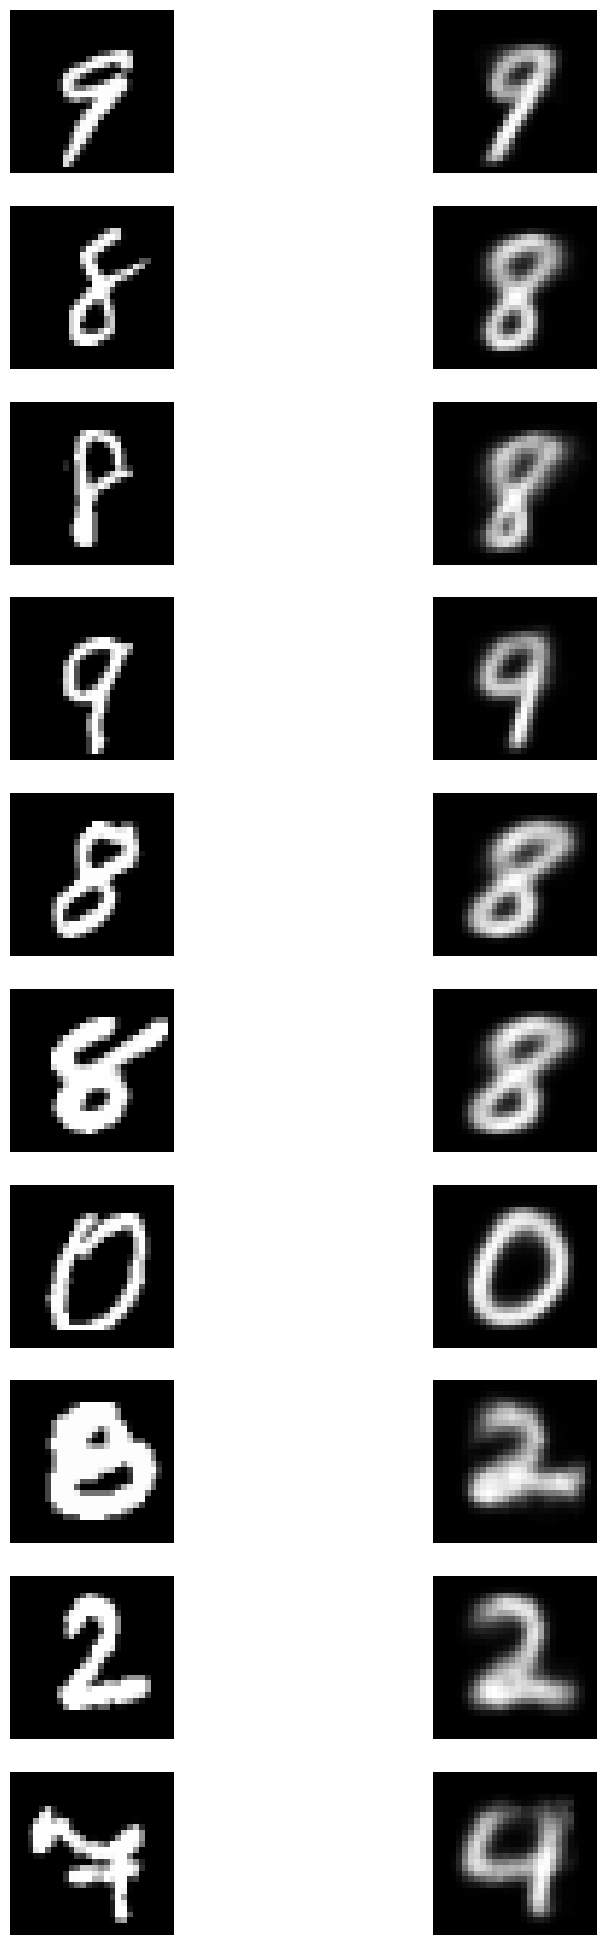

Epoch 22/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.1112 - reconstruction_loss: 133.9737 - kl_loss: 7.1279


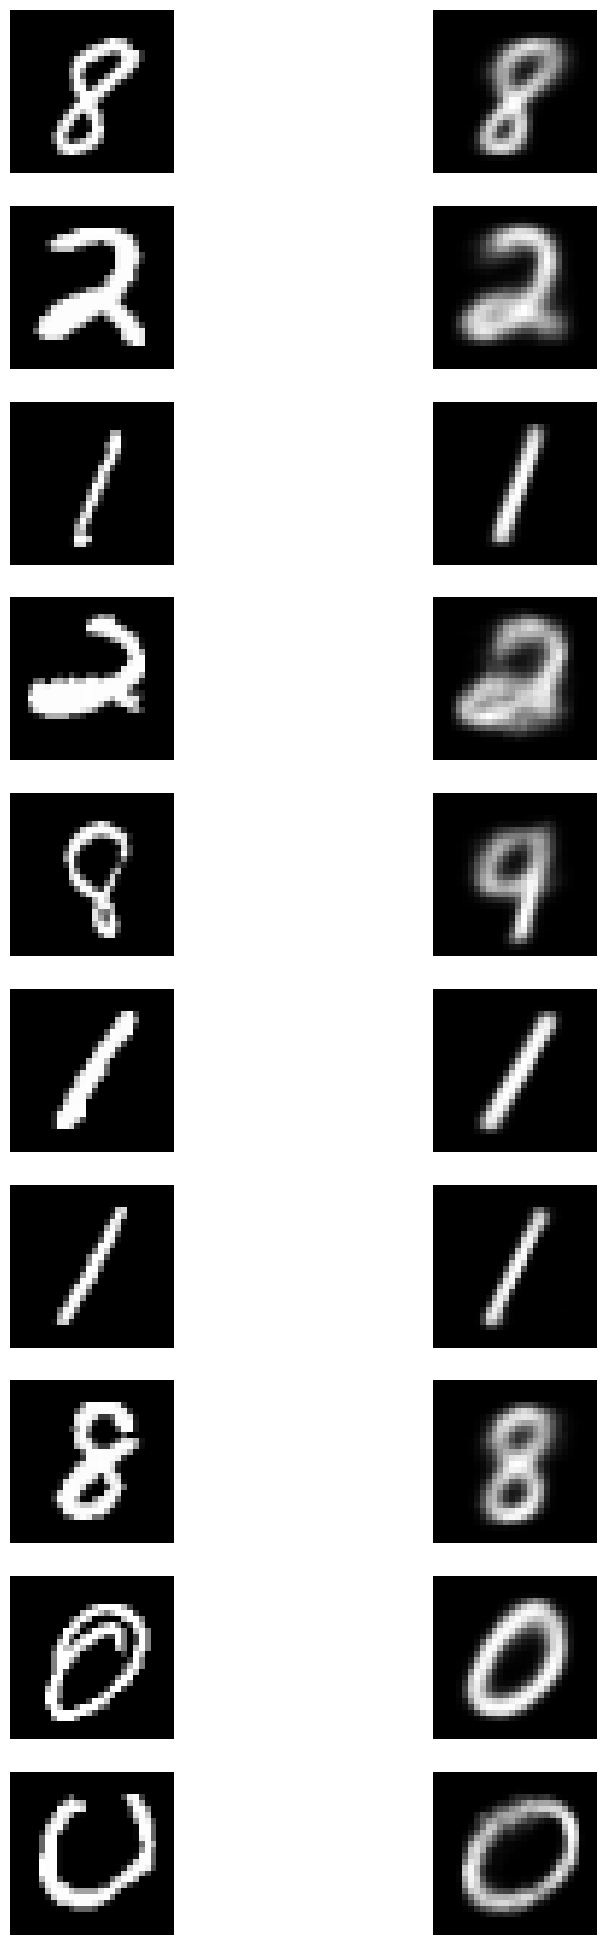

Epoch 23/300
2188/2188 [==============================] - 9s 4ms/step - loss: 140.9997 - reconstruction_loss: 134.0145 - kl_loss: 7.1534


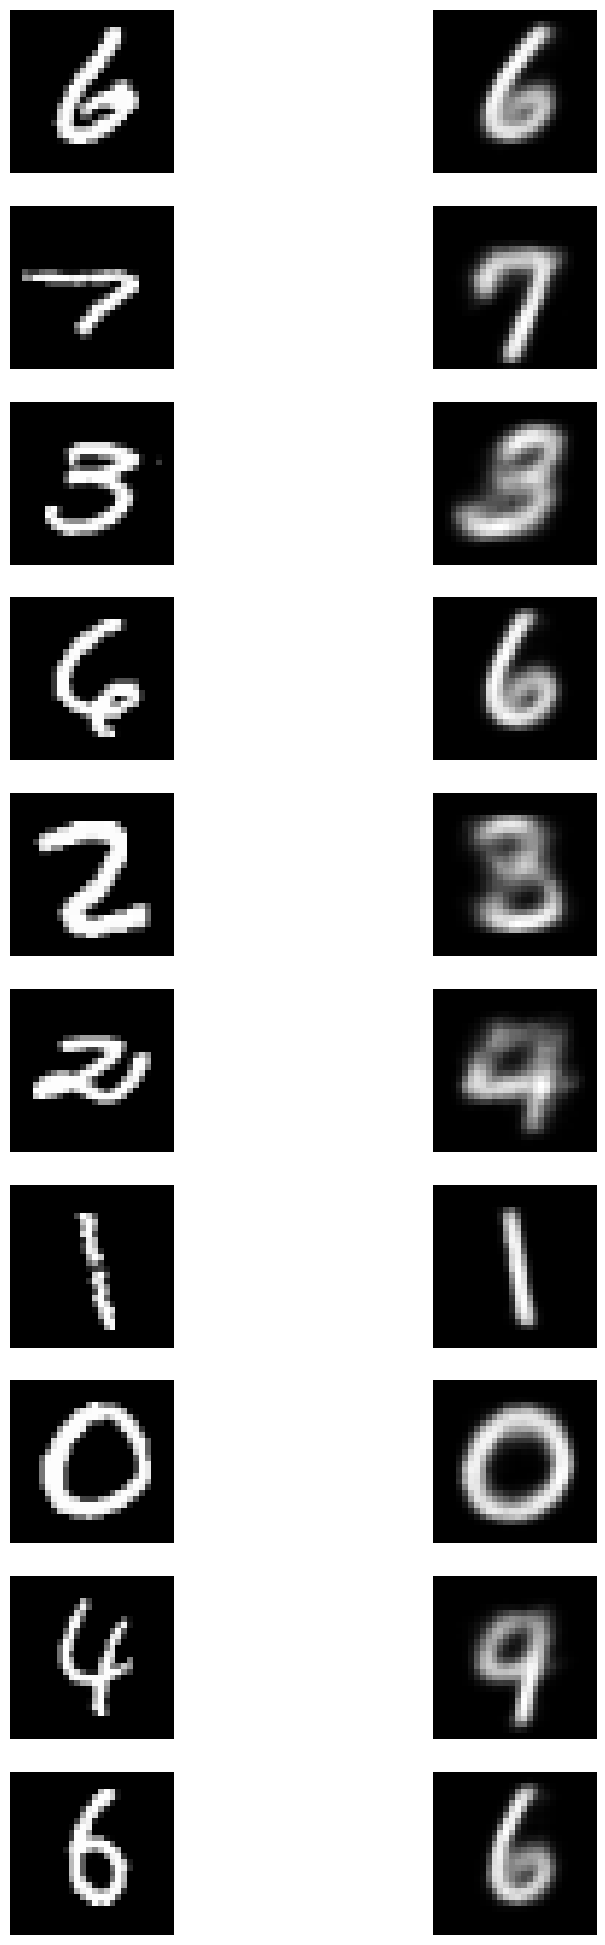

Epoch 24/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.2637 - reconstruction_loss: 133.9570 - kl_loss: 7.1410


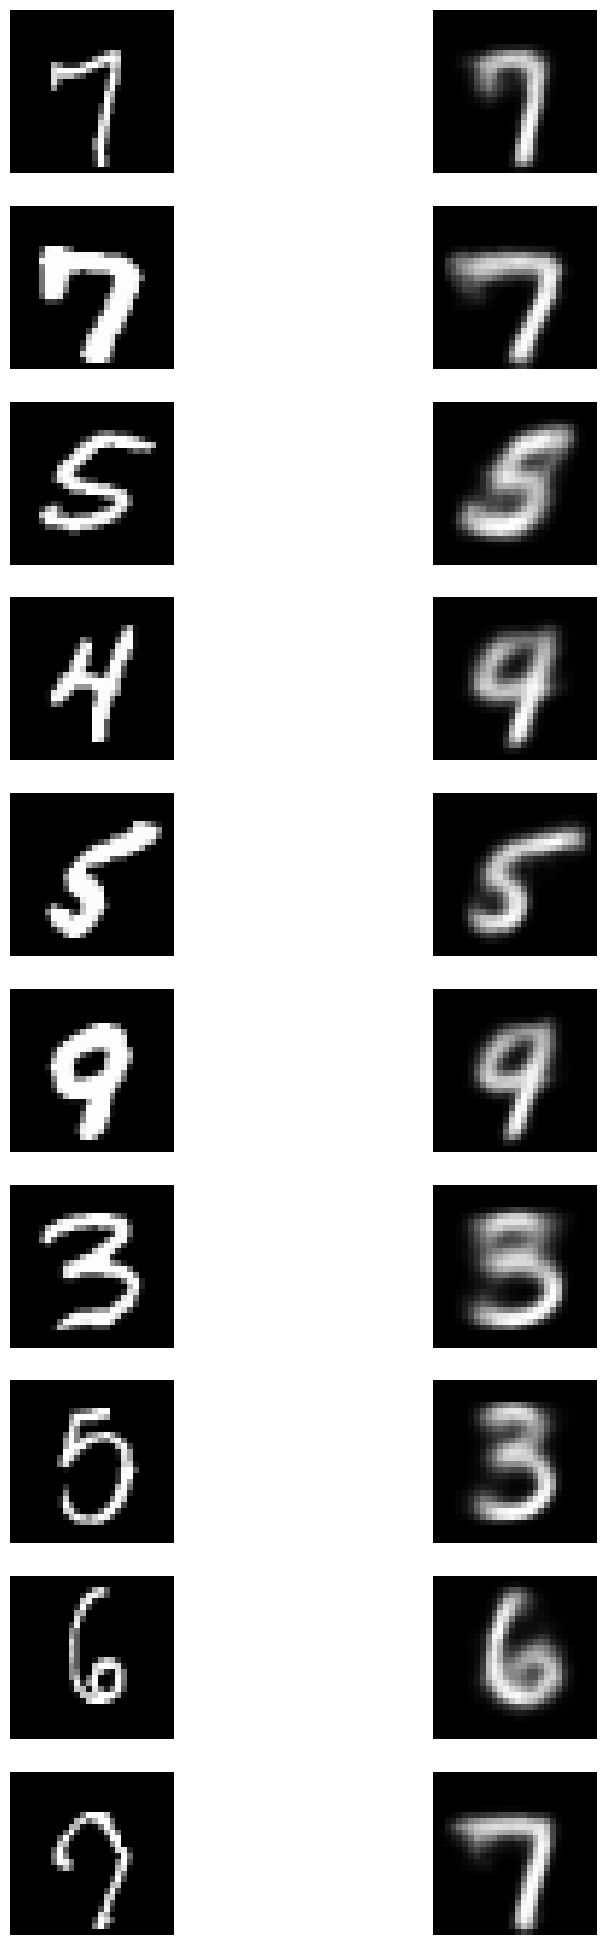

Epoch 25/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.1894 - reconstruction_loss: 133.9958 - kl_loss: 7.1381


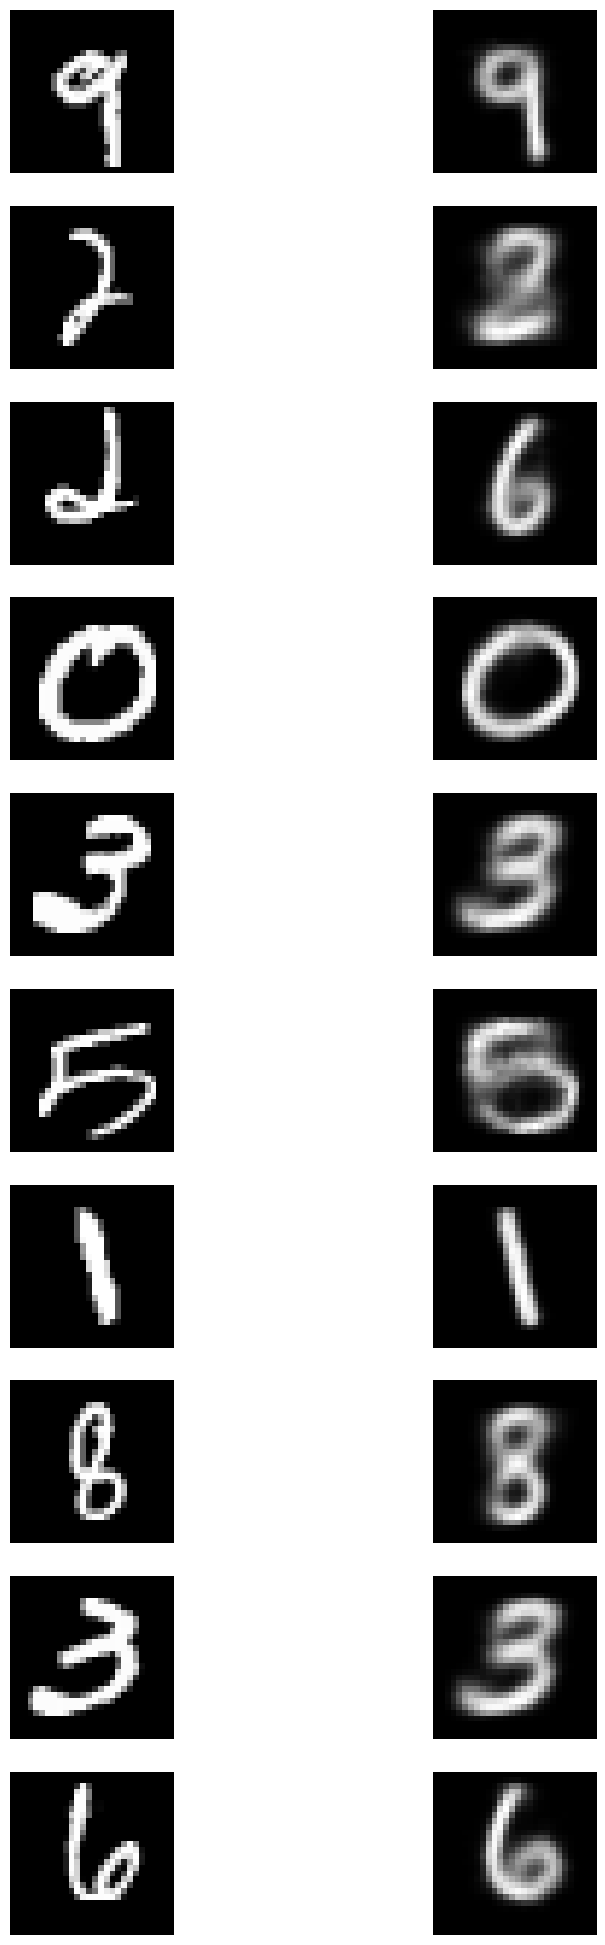

Epoch 26/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.2319 - reconstruction_loss: 133.9234 - kl_loss: 7.1471


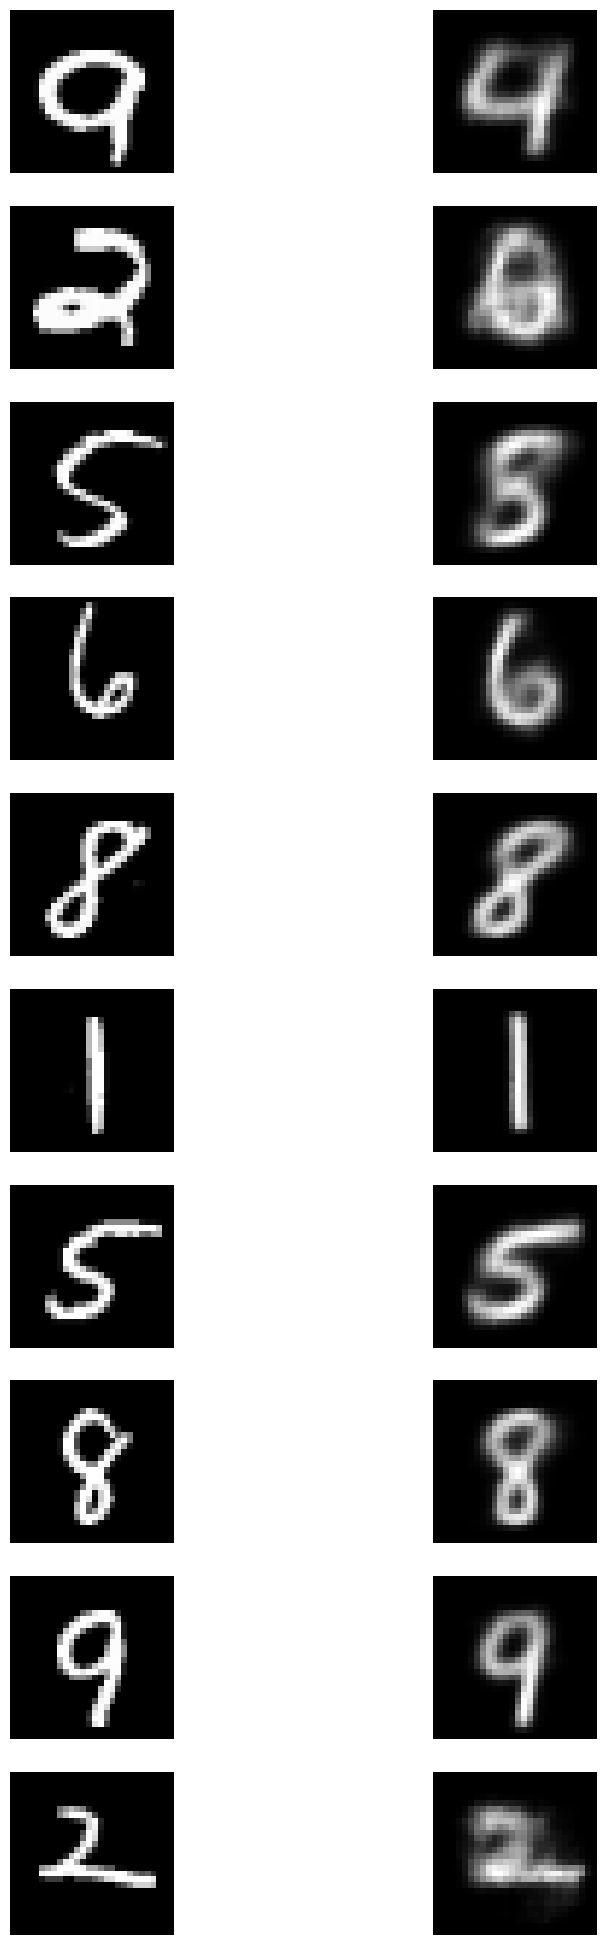

Epoch 27/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.0436 - reconstruction_loss: 134.0611 - kl_loss: 7.1255


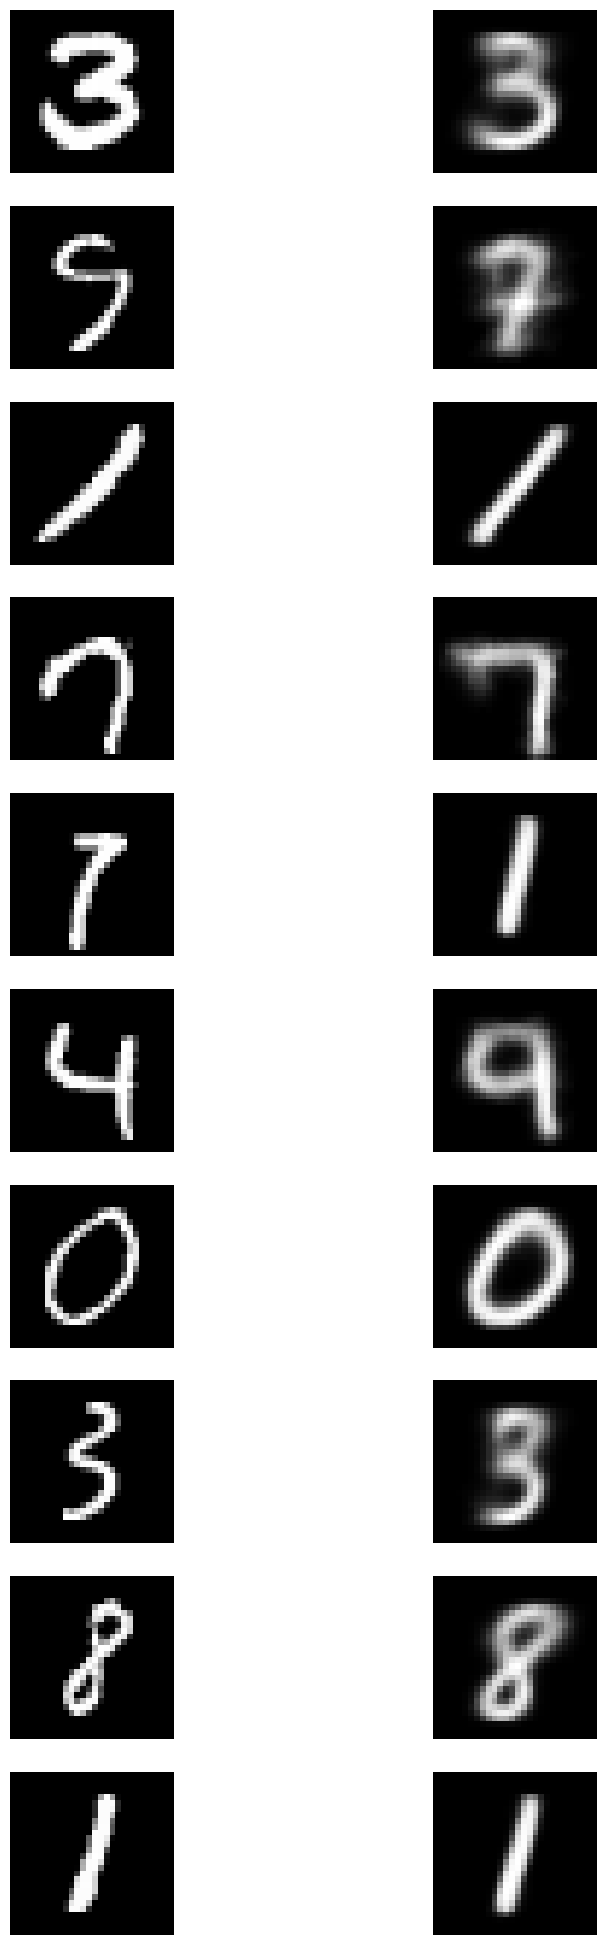

Epoch 28/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.1422 - reconstruction_loss: 134.0607 - kl_loss: 7.1191


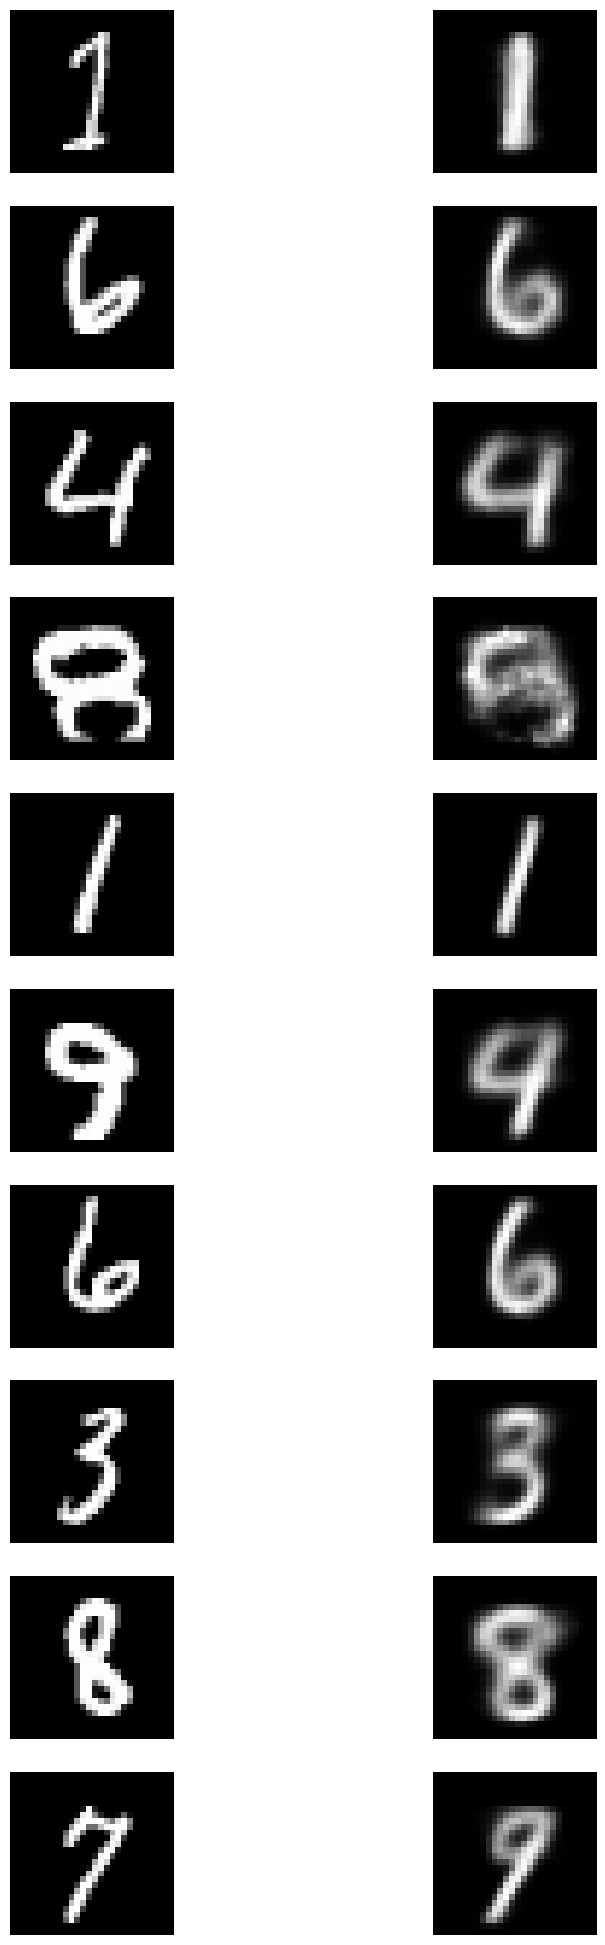

Epoch 29/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.0724 - reconstruction_loss: 133.9593 - kl_loss: 7.1236


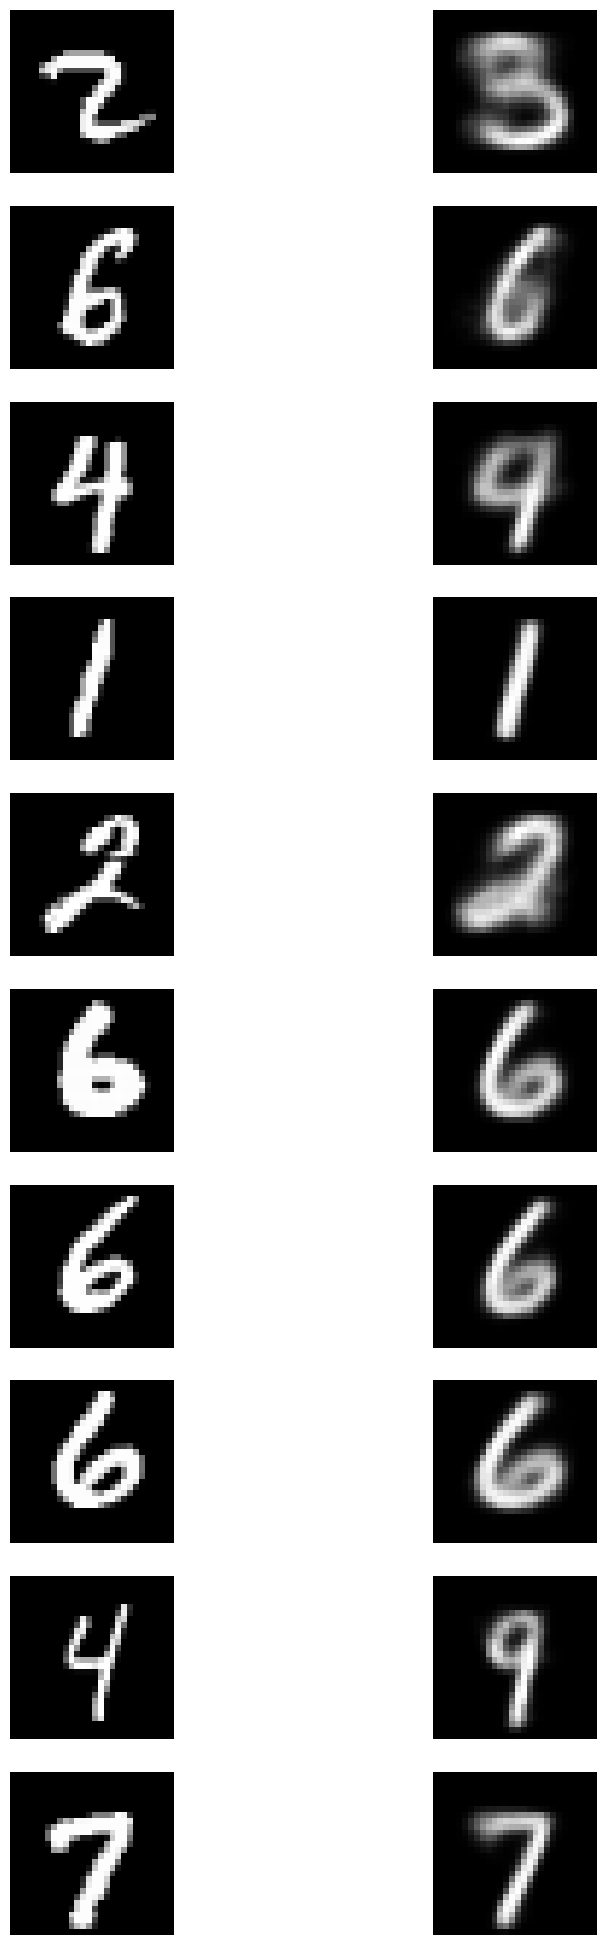

Epoch 30/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.8816 - reconstruction_loss: 134.0647 - kl_loss: 7.1127


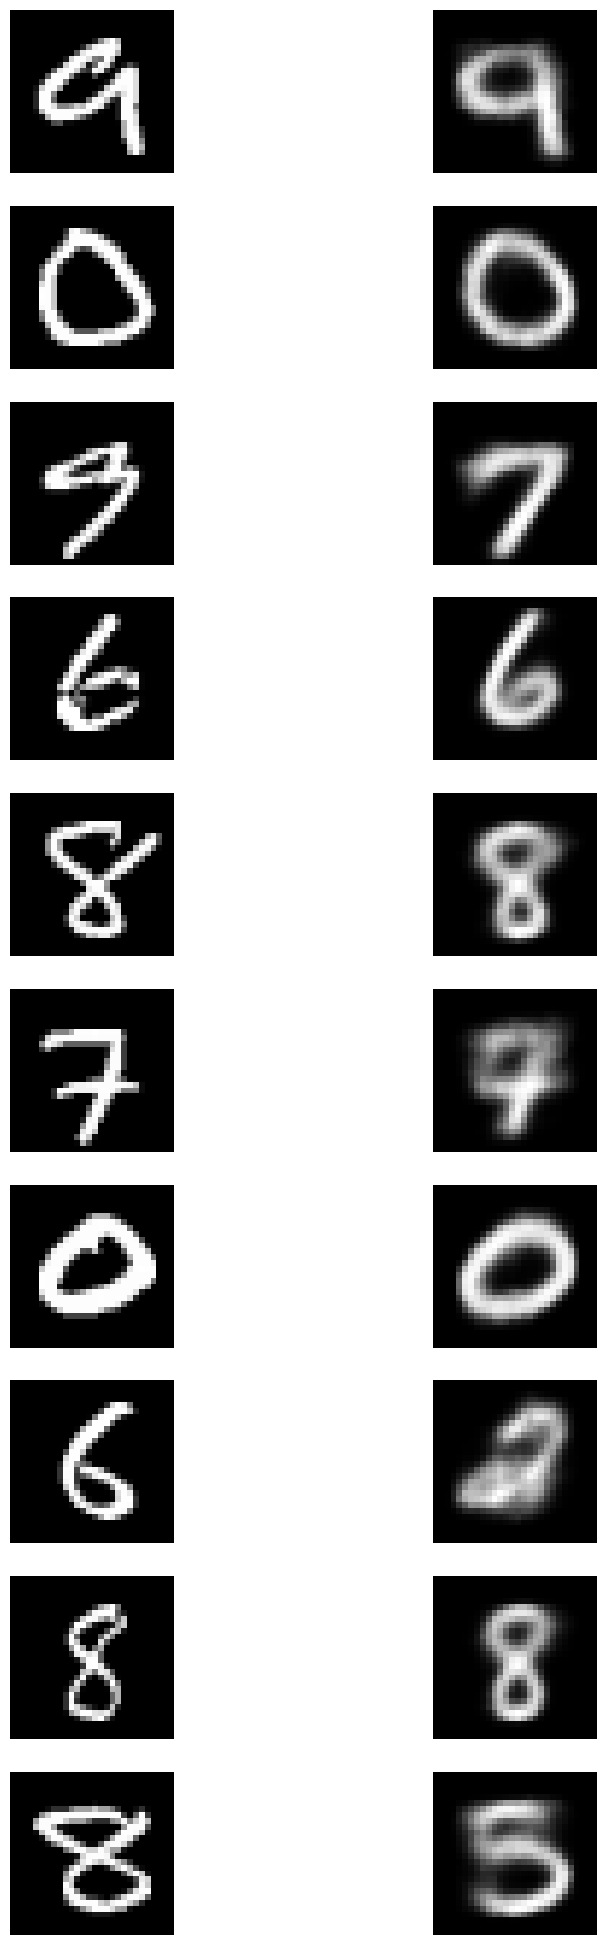

Epoch 31/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.7284 - reconstruction_loss: 133.9934 - kl_loss: 7.1397


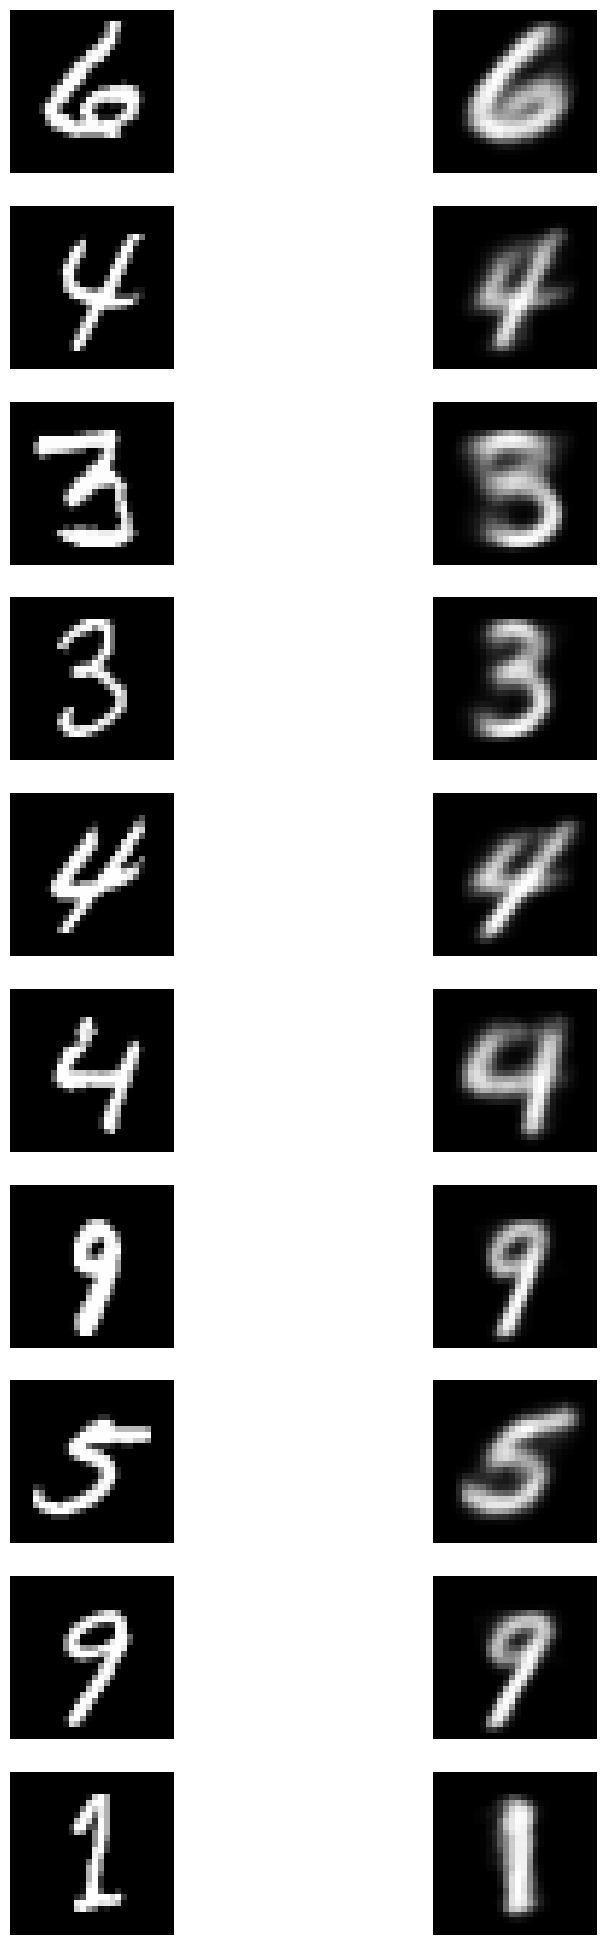

Epoch 32/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.9466 - reconstruction_loss: 134.0197 - kl_loss: 7.1451


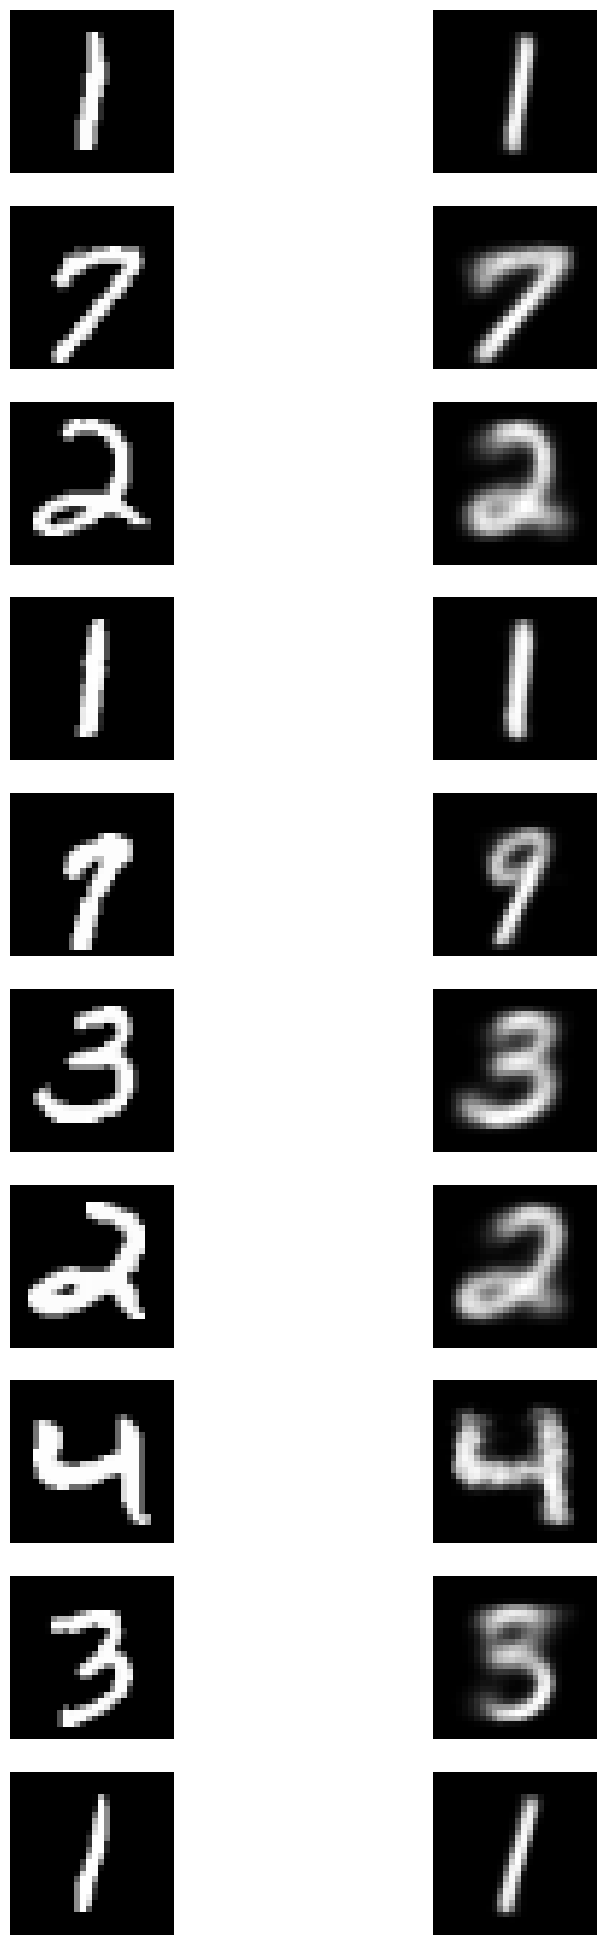

Epoch 33/300
2188/2188 [==============================] - 9s 4ms/step - loss: 141.5073 - reconstruction_loss: 133.9782 - kl_loss: 7.1531


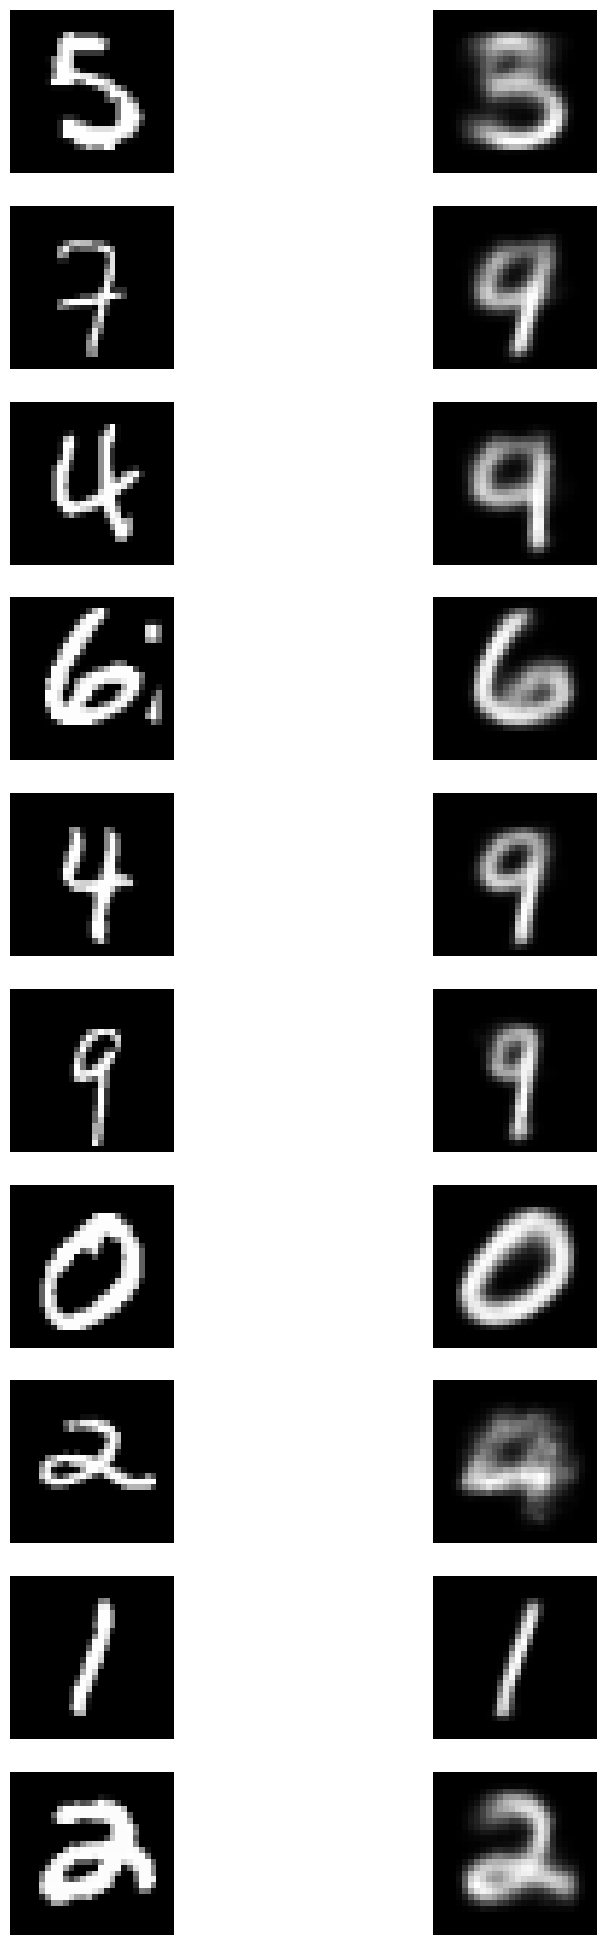

Epoch 34/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.8688 - reconstruction_loss: 133.9697 - kl_loss: 7.1235


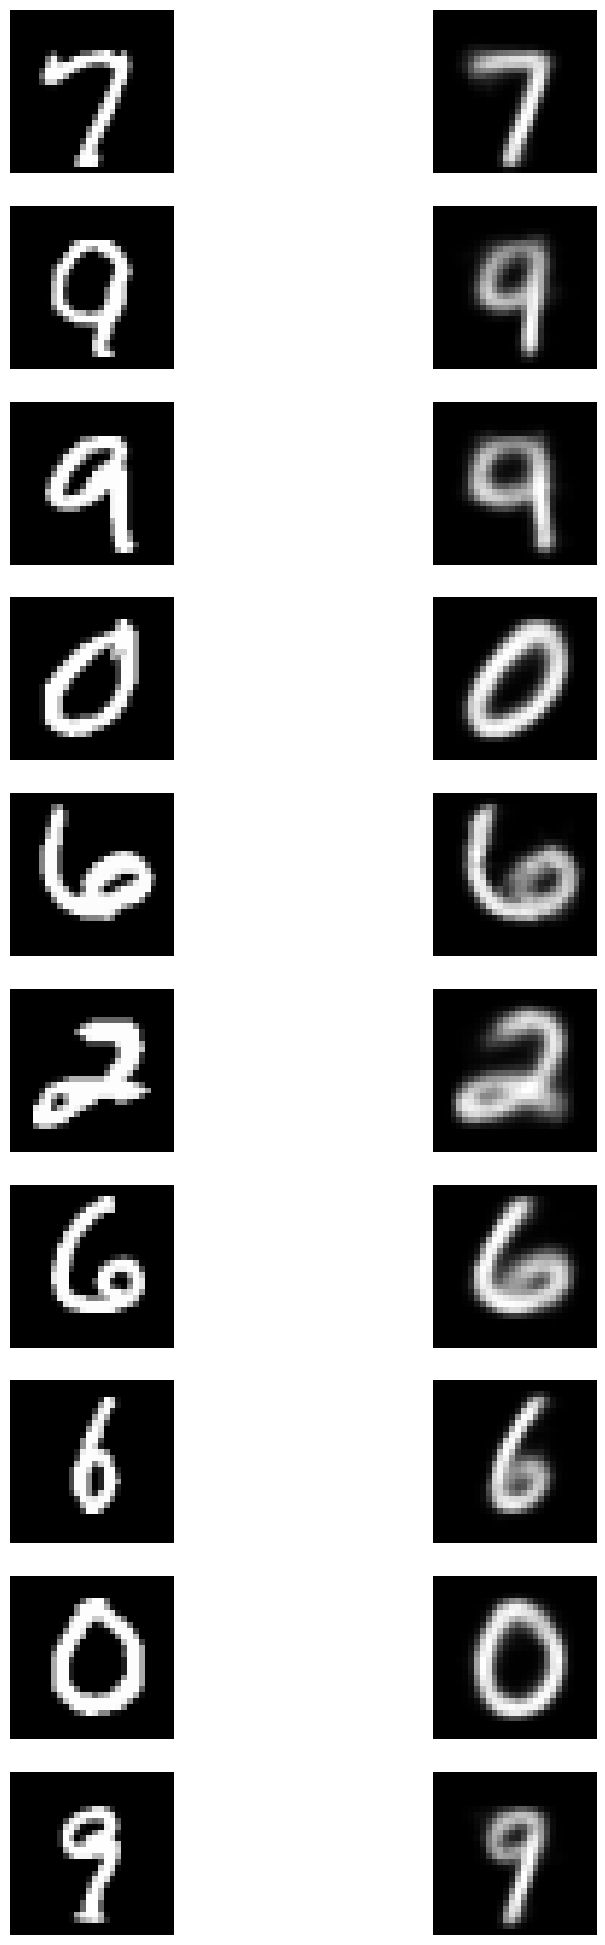

Epoch 35/300
2188/2188 [==============================] - 9s 4ms/step - loss: 141.2574 - reconstruction_loss: 133.9566 - kl_loss: 7.1345


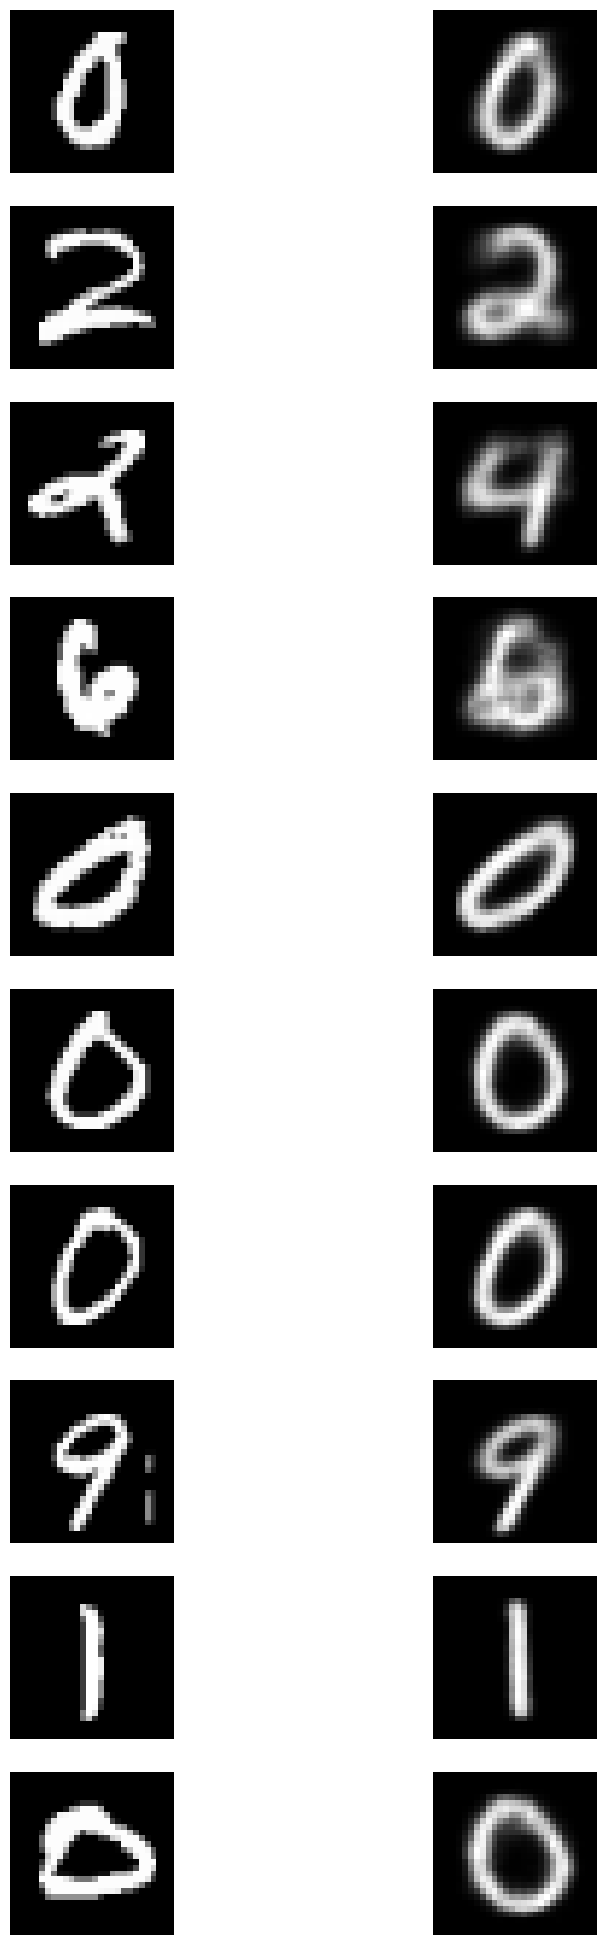

Epoch 36/300
2188/2188 [==============================] - 9s 4ms/step - loss: 141.0988 - reconstruction_loss: 134.0096 - kl_loss: 7.1414


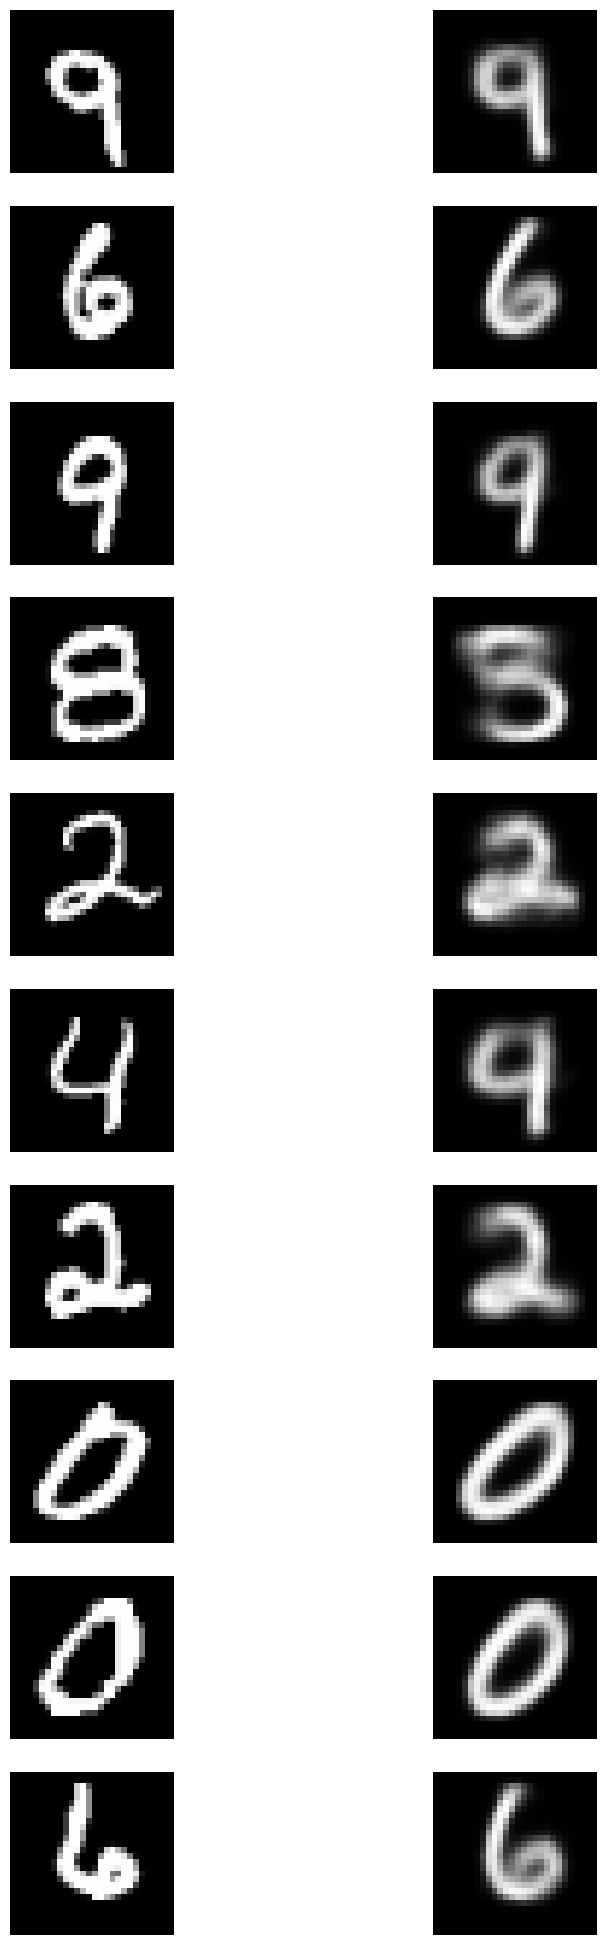

Epoch 37/300
2188/2188 [==============================] - 9s 4ms/step - loss: 141.4693 - reconstruction_loss: 134.0082 - kl_loss: 7.1155


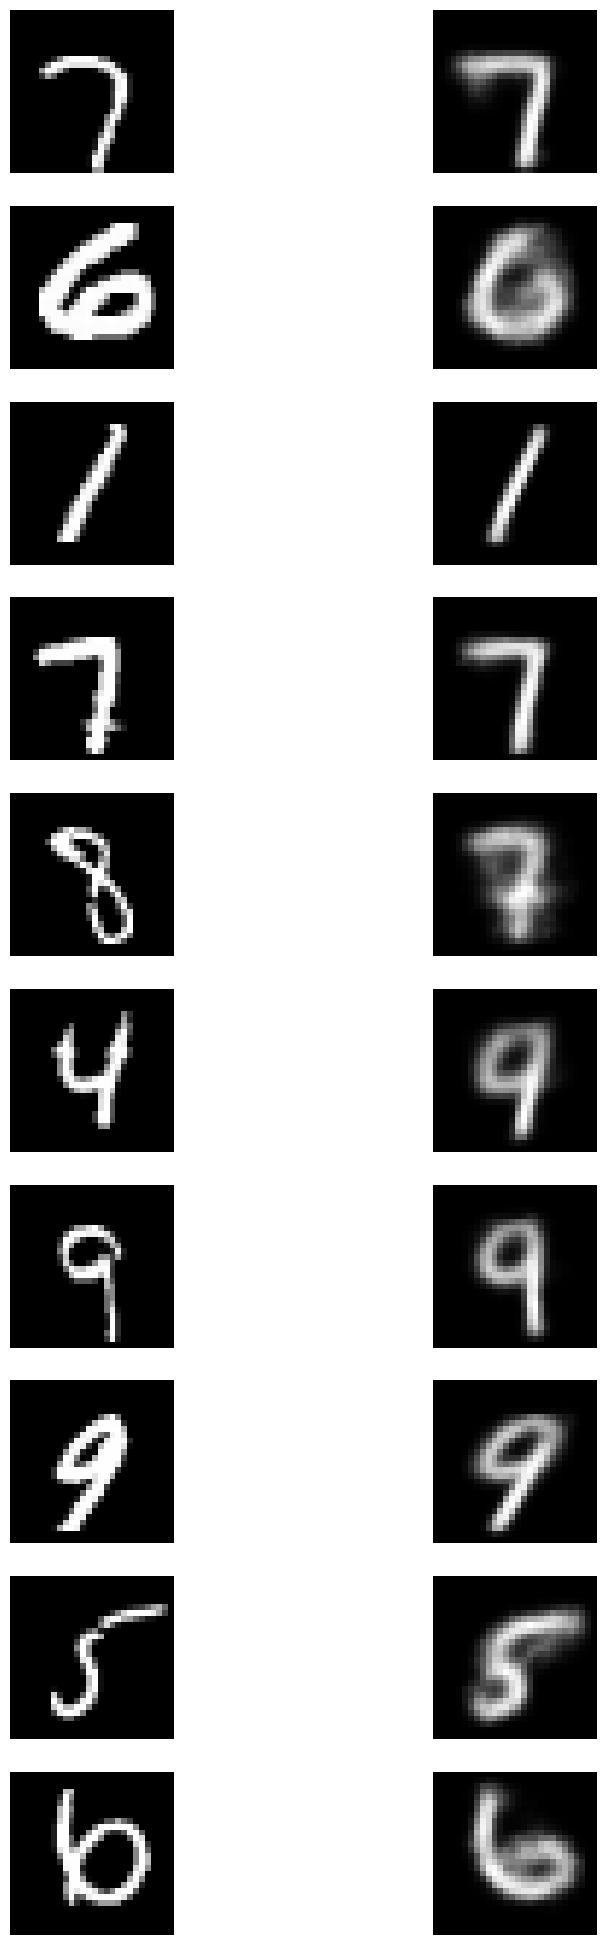

Epoch 38/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.8987 - reconstruction_loss: 134.0082 - kl_loss: 7.1243


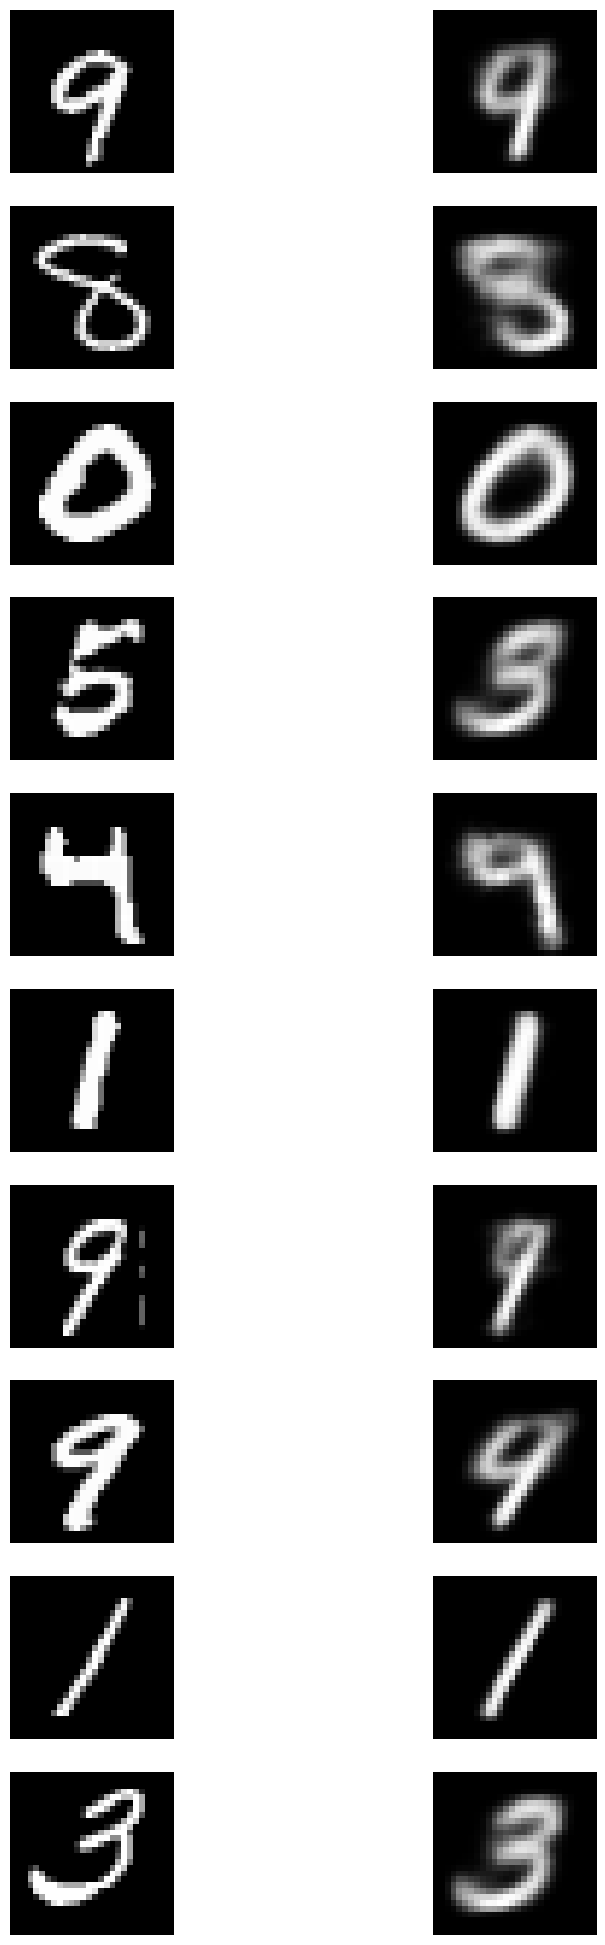

Epoch 39/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.3692 - reconstruction_loss: 133.9997 - kl_loss: 7.1363


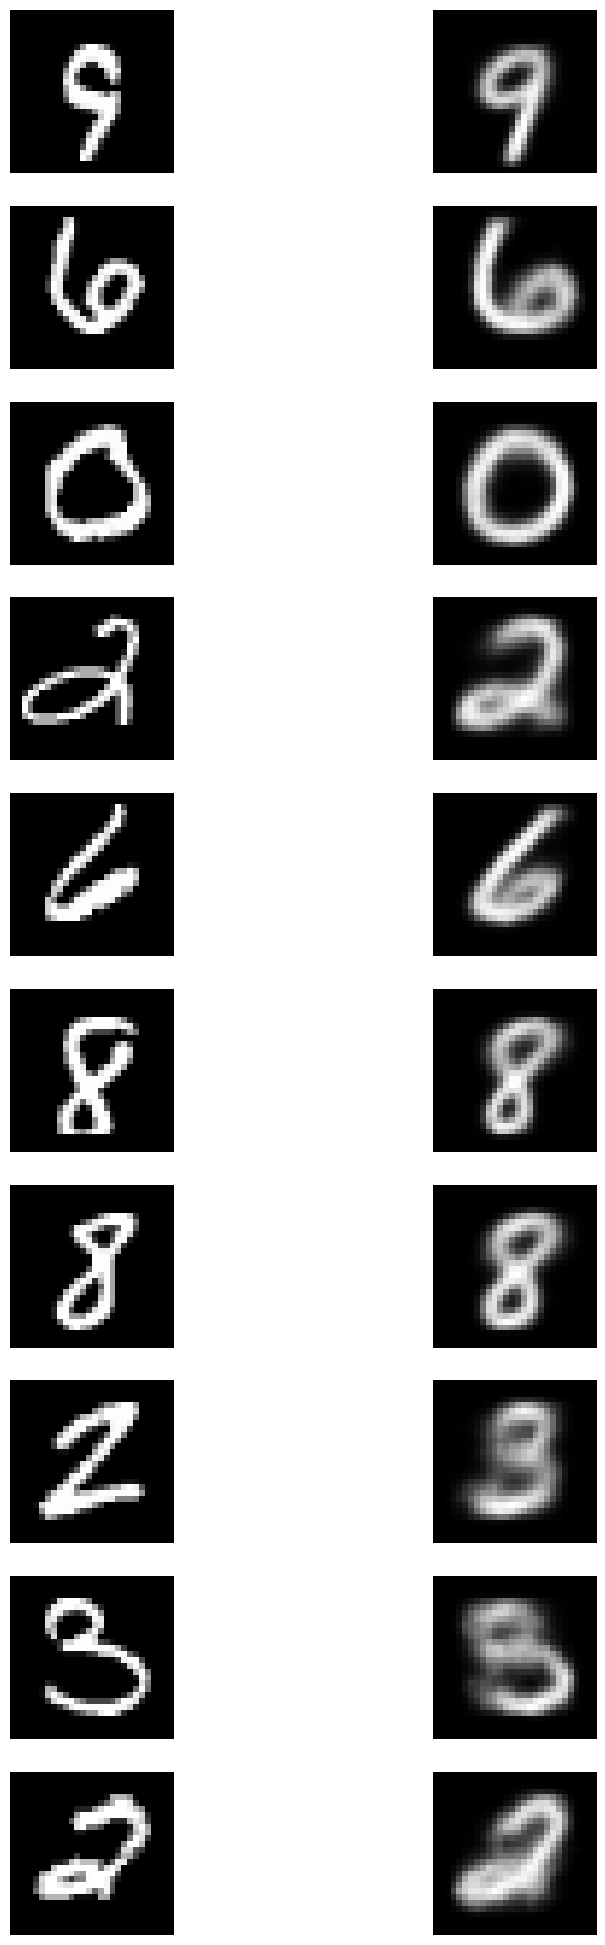

Epoch 40/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.9242 - reconstruction_loss: 134.0471 - kl_loss: 7.1202


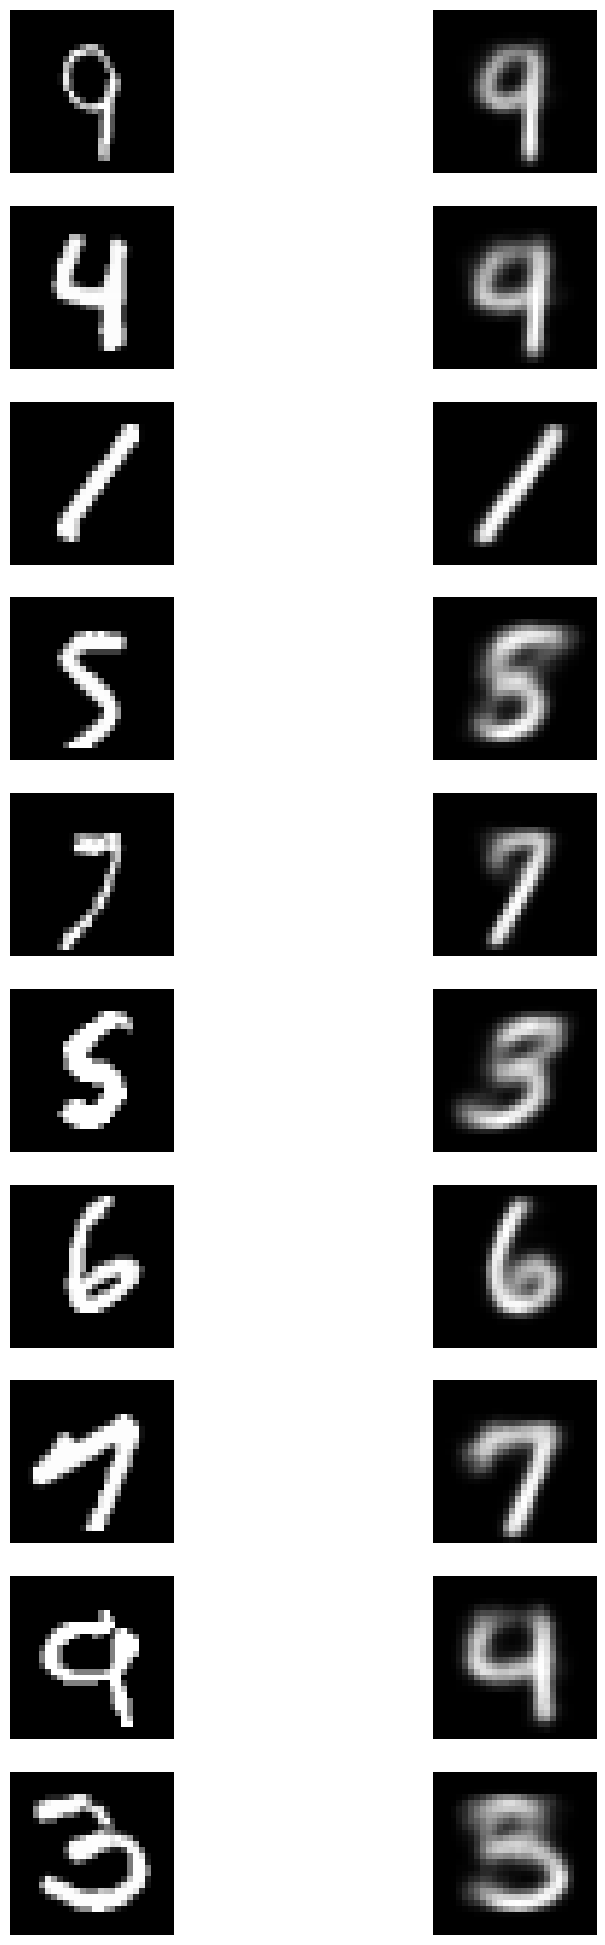

Epoch 41/300
2188/2188 [==============================] - 9s 4ms/step - loss: 141.0201 - reconstruction_loss: 133.9570 - kl_loss: 7.1443


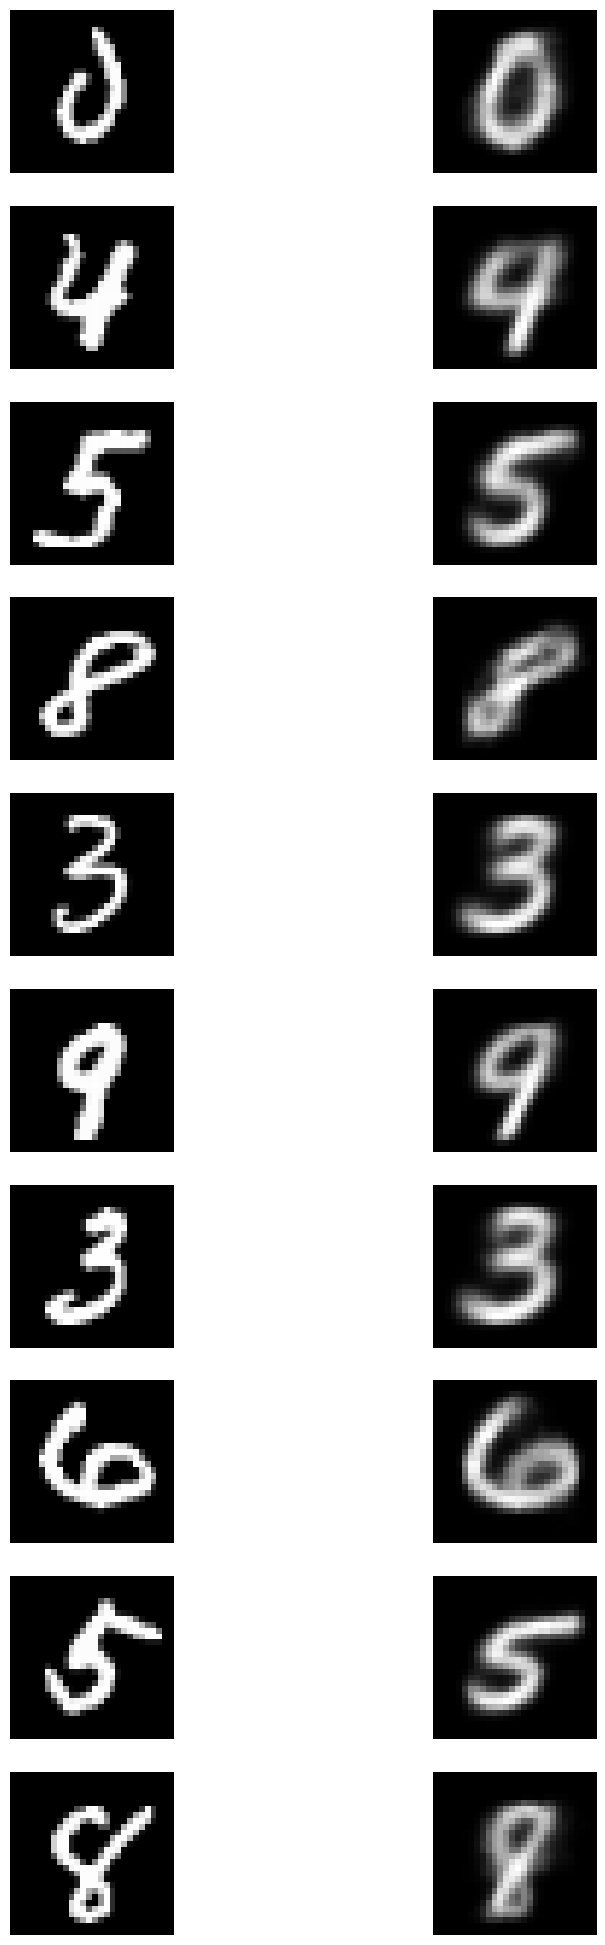

Epoch 42/300
2188/2188 [==============================] - 9s 4ms/step - loss: 140.6636 - reconstruction_loss: 134.0128 - kl_loss: 7.1160


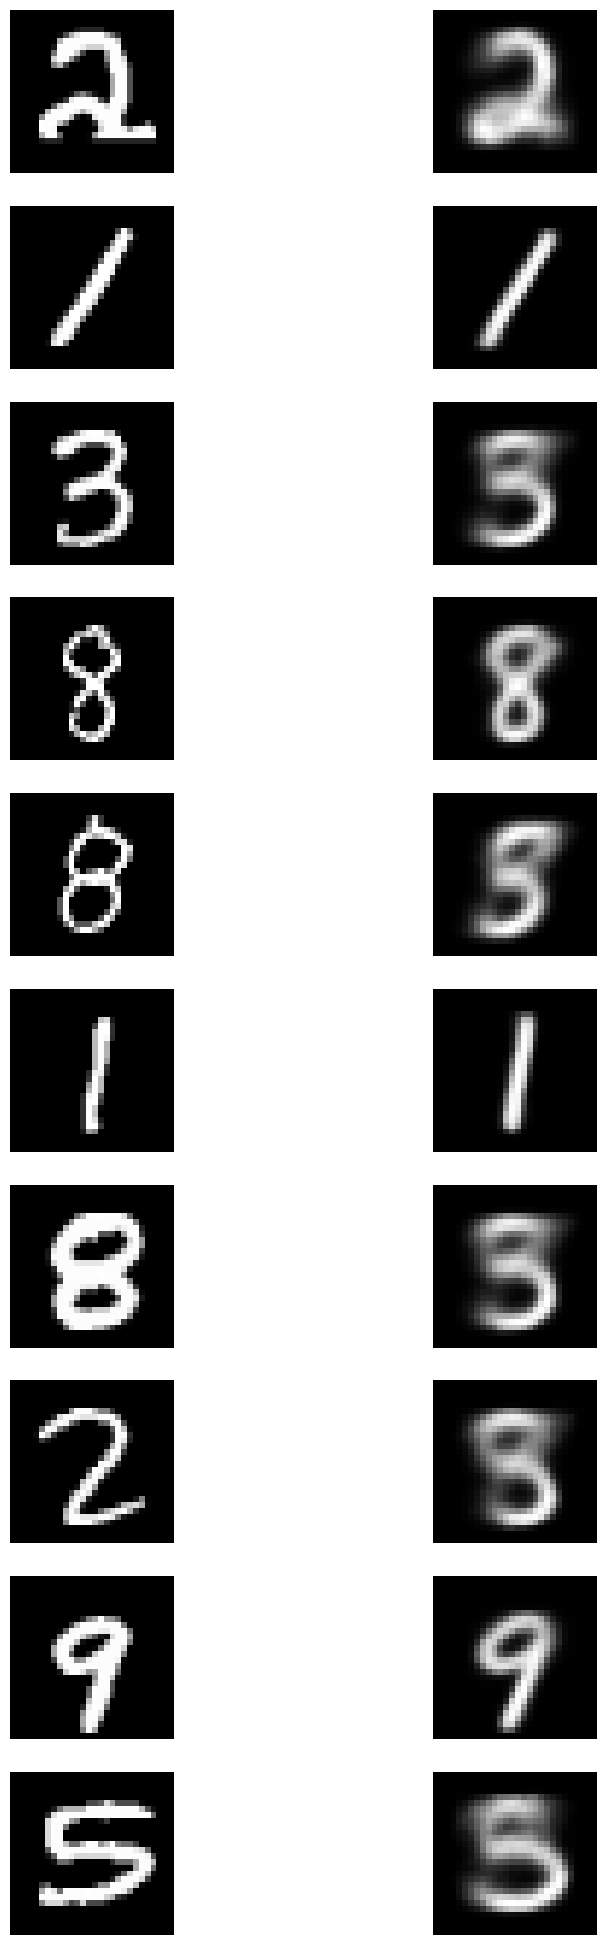

Epoch 43/300
2188/2188 [==============================] - 9s 4ms/step - loss: 141.0622 - reconstruction_loss: 134.1098 - kl_loss: 7.1369


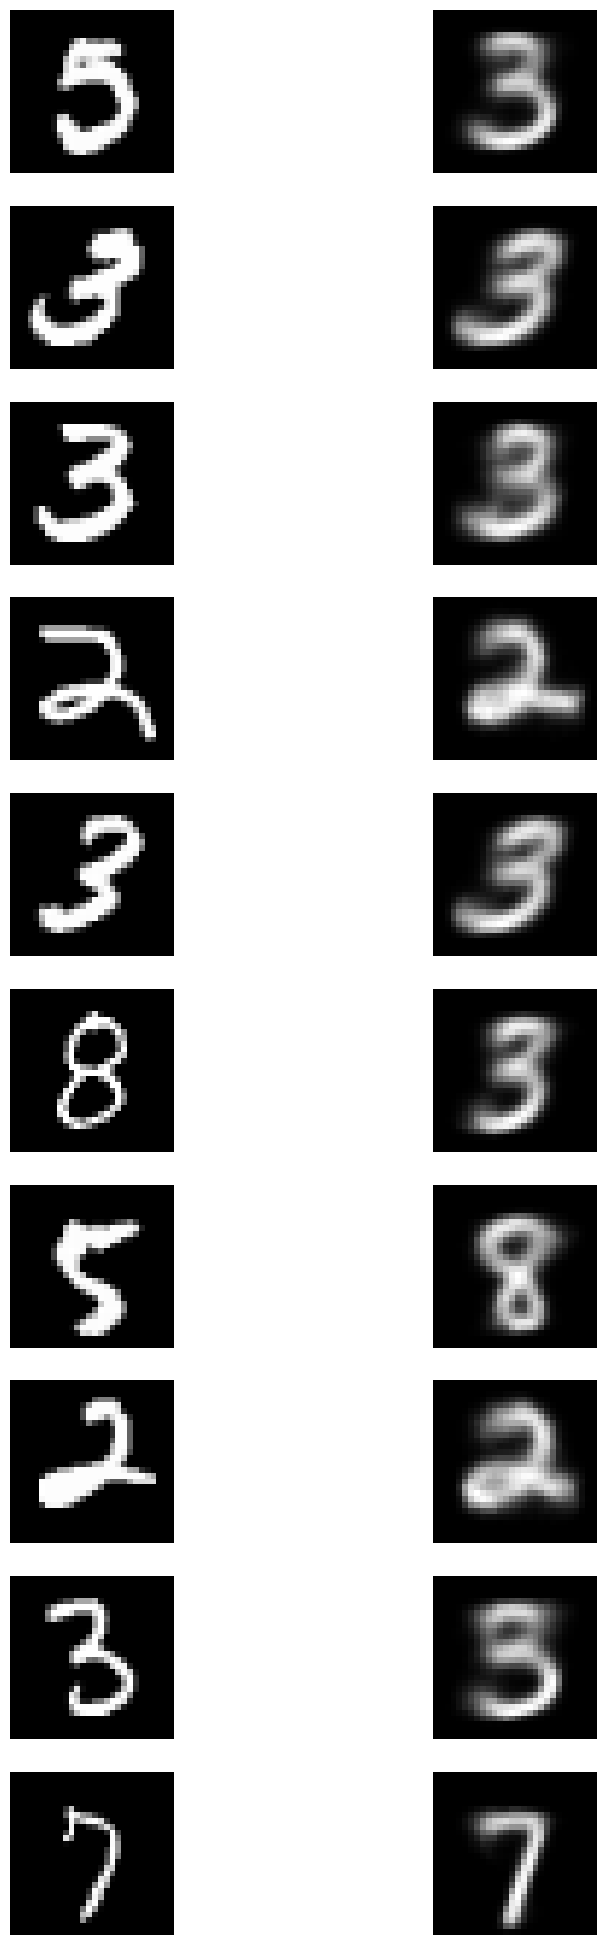

Epoch 44/300
2188/2188 [==============================] - 9s 4ms/step - loss: 140.8683 - reconstruction_loss: 133.9967 - kl_loss: 7.1206


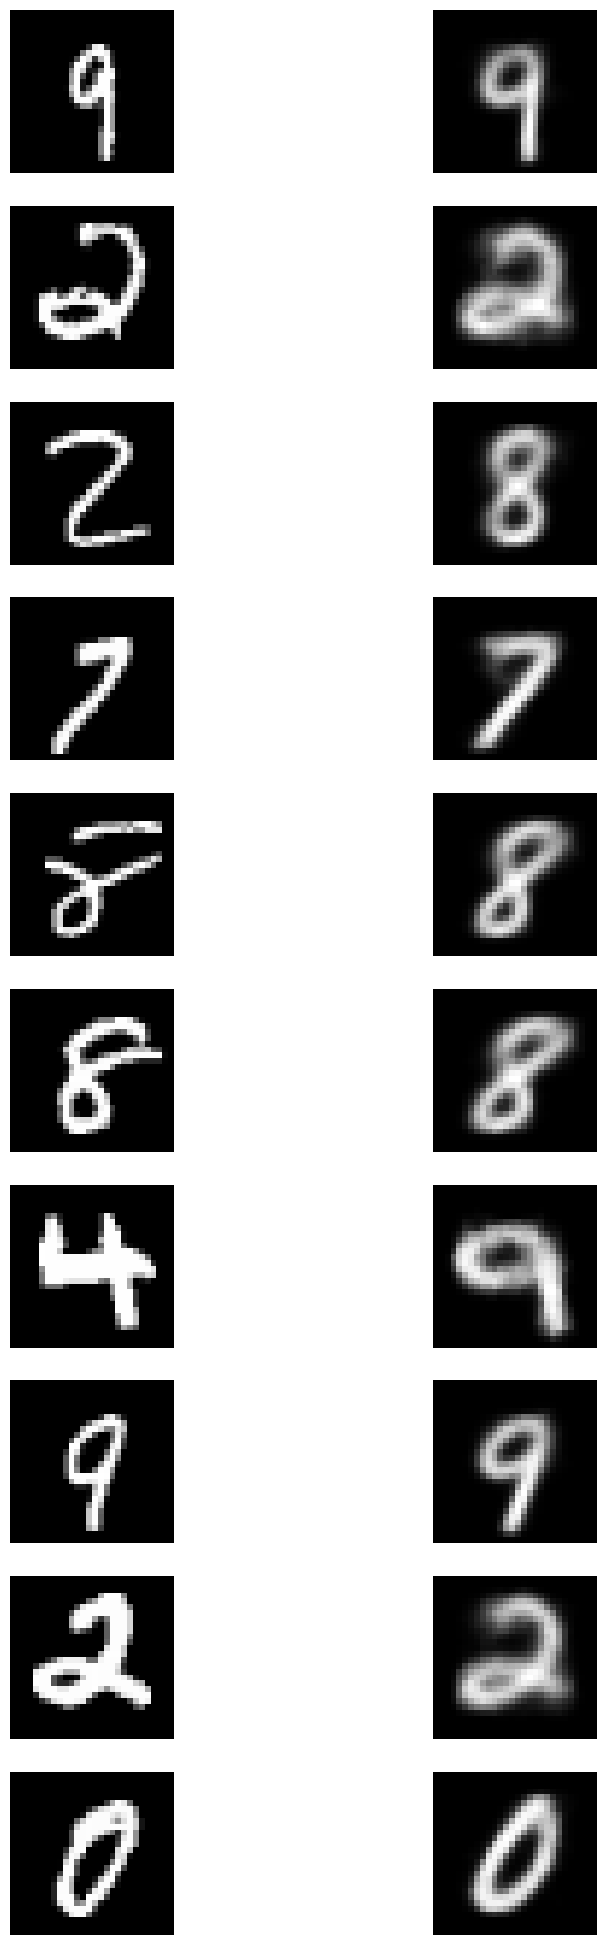

Epoch 45/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.0146 - reconstruction_loss: 133.9701 - kl_loss: 7.1360


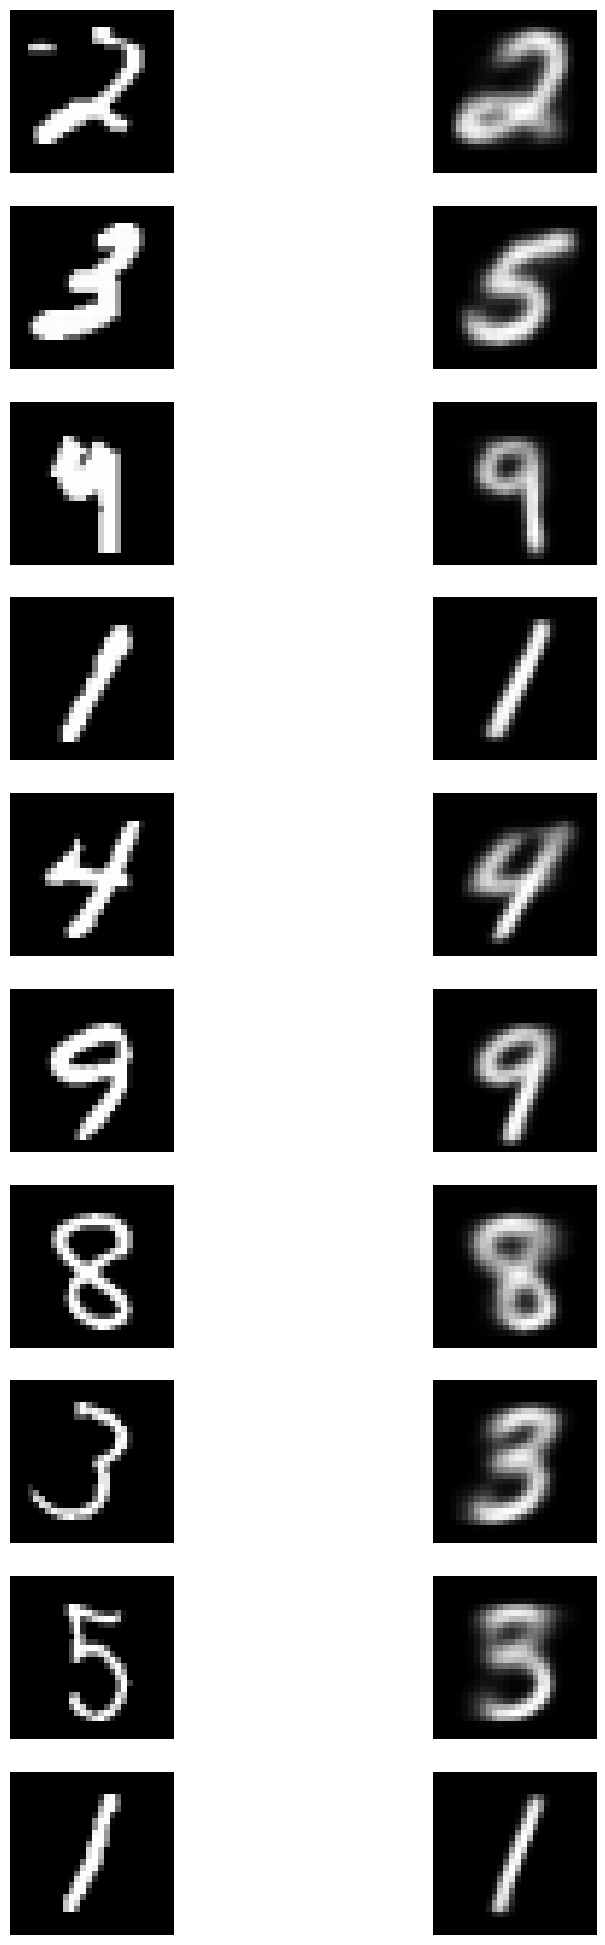

Epoch 46/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.7687 - reconstruction_loss: 133.9164 - kl_loss: 7.1333


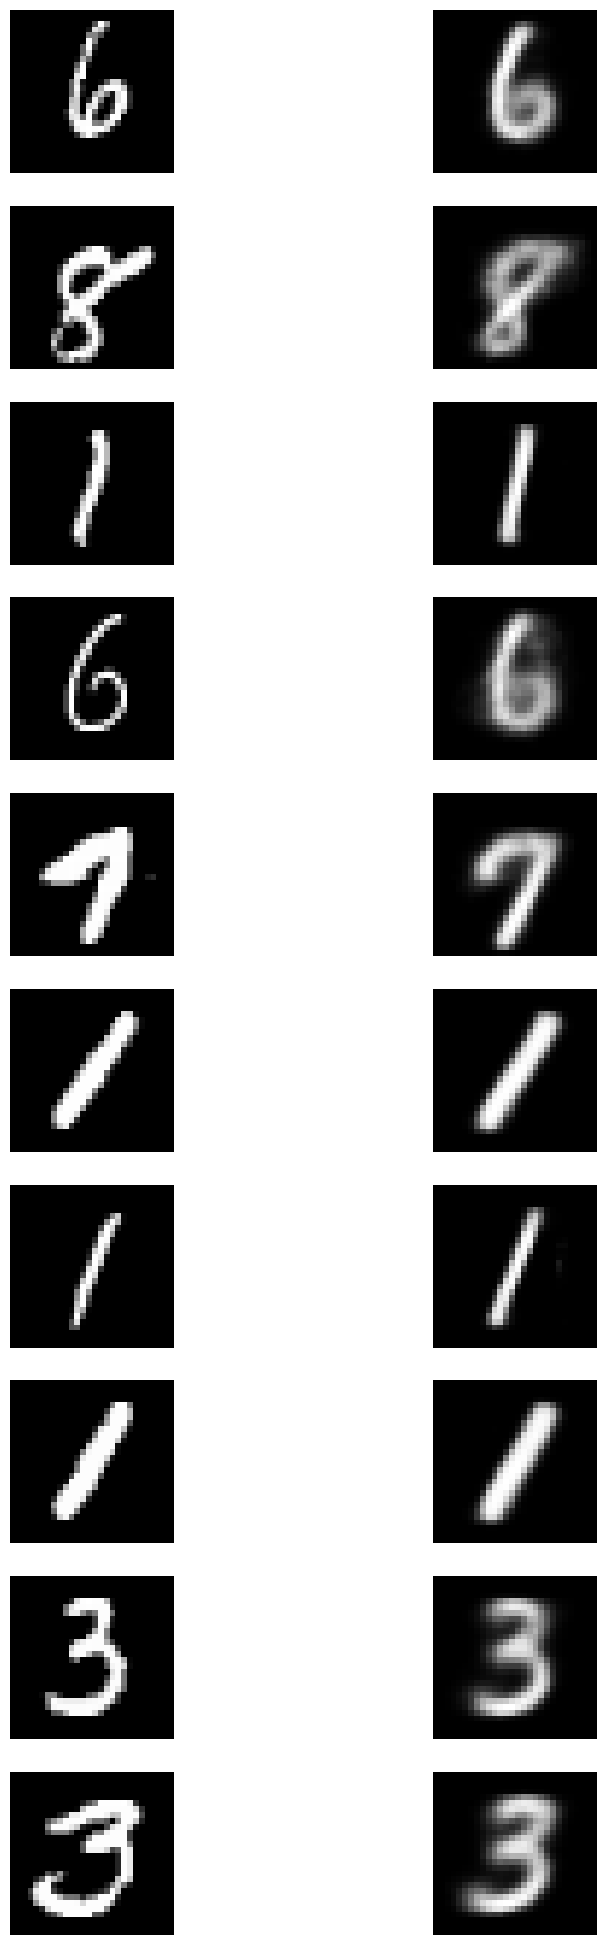

Epoch 47/300
2188/2188 [==============================] - 9s 4ms/step - loss: 140.9859 - reconstruction_loss: 134.0847 - kl_loss: 7.1242


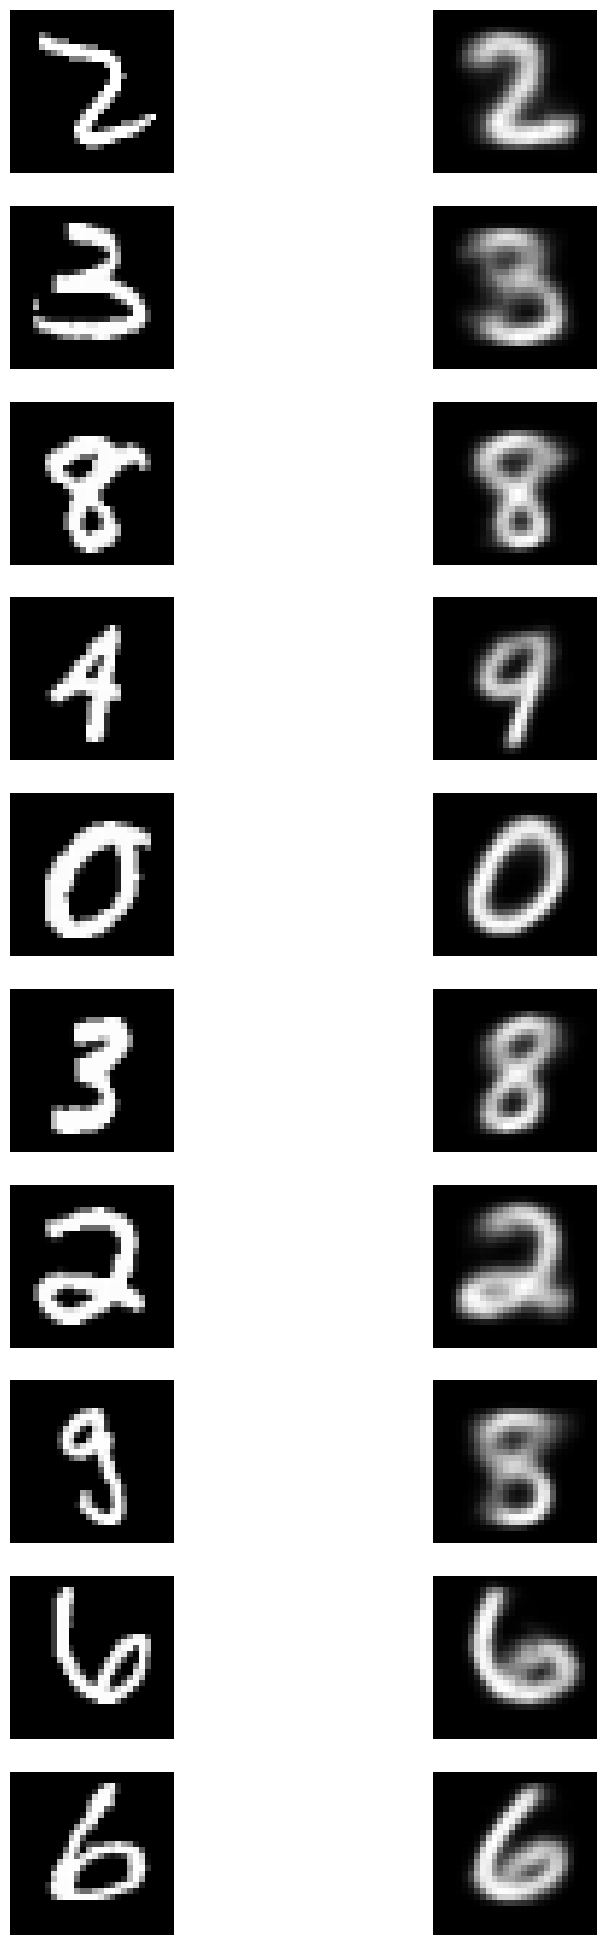

Epoch 48/300
2188/2188 [==============================] - 14s 7ms/step - loss: 141.4471 - reconstruction_loss: 134.0652 - kl_loss: 7.1201


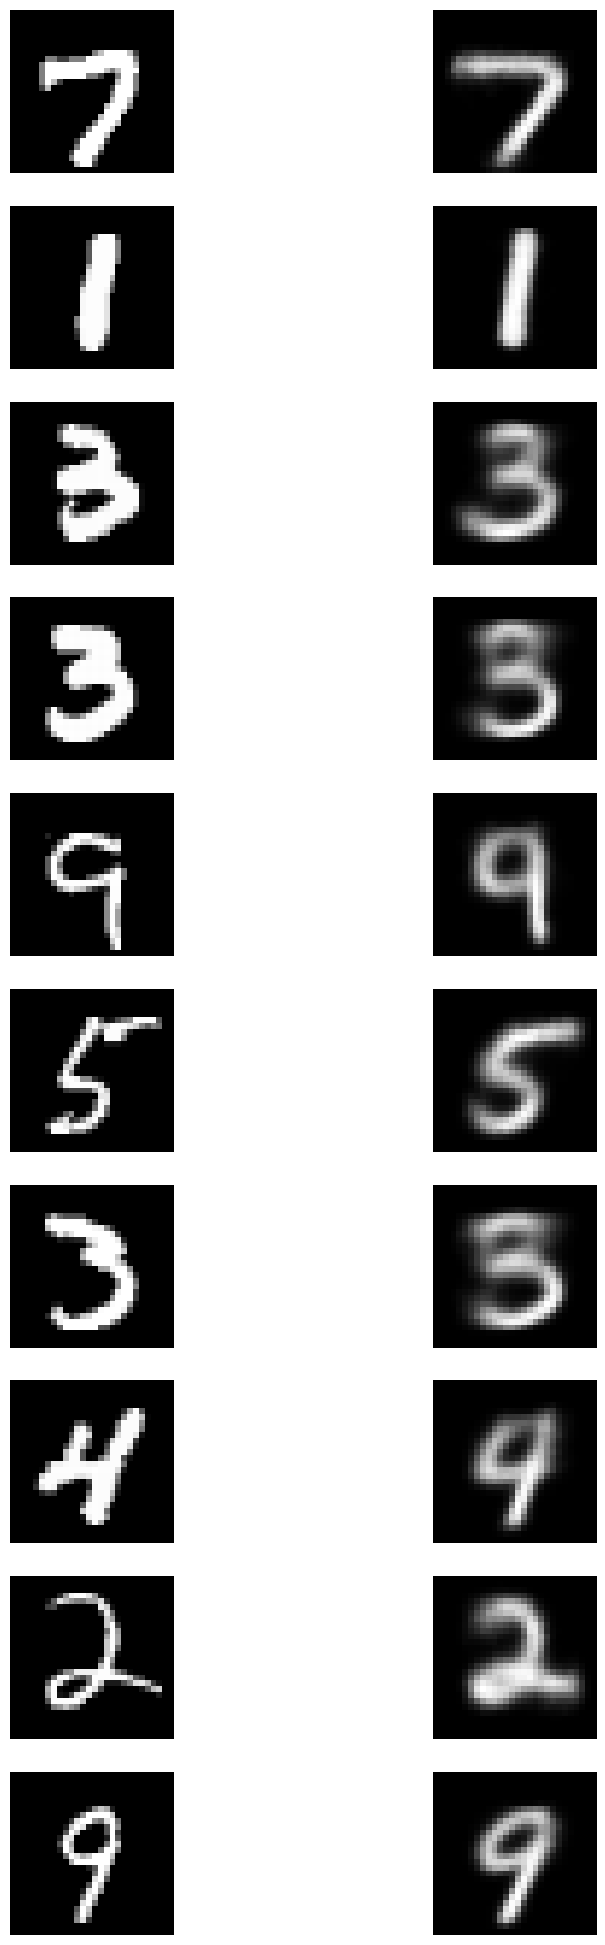

Epoch 49/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.9885 - reconstruction_loss: 133.9974 - kl_loss: 7.1403


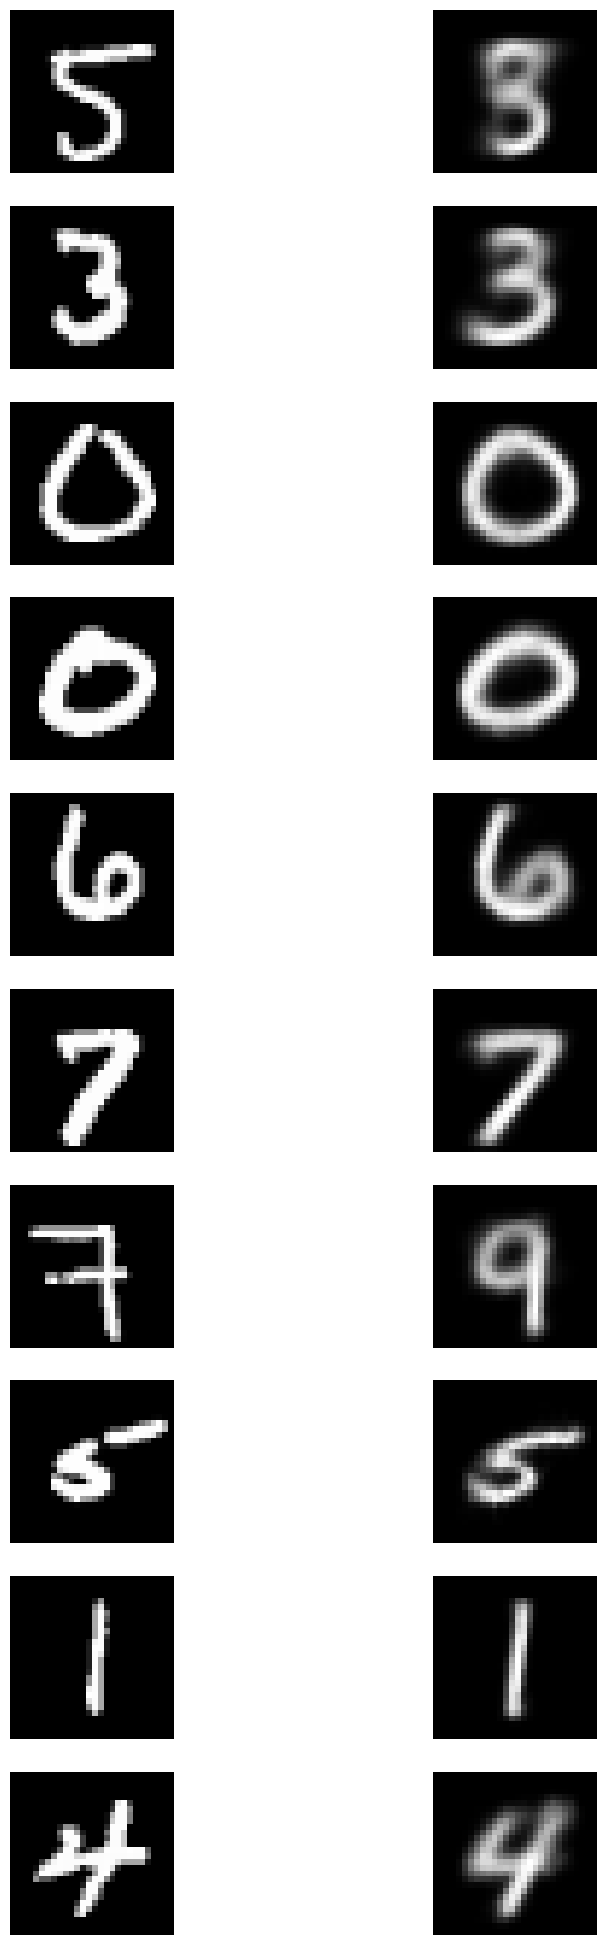

Epoch 50/300
2188/2188 [==============================] - 9s 4ms/step - loss: 140.7898 - reconstruction_loss: 133.8941 - kl_loss: 7.1105


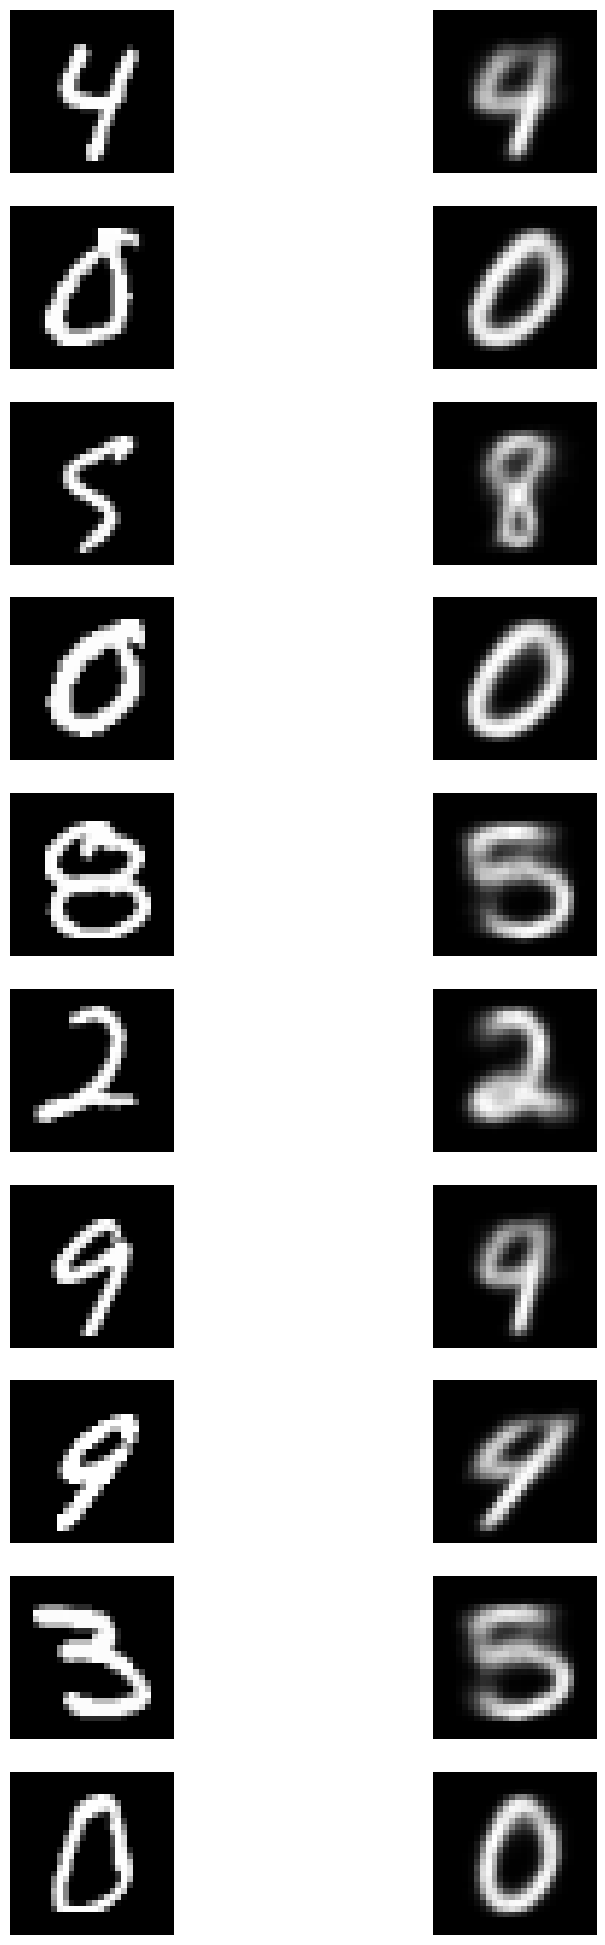

Epoch 51/300
2188/2188 [==============================] - 9s 4ms/step - loss: 141.0115 - reconstruction_loss: 134.0364 - kl_loss: 7.1058


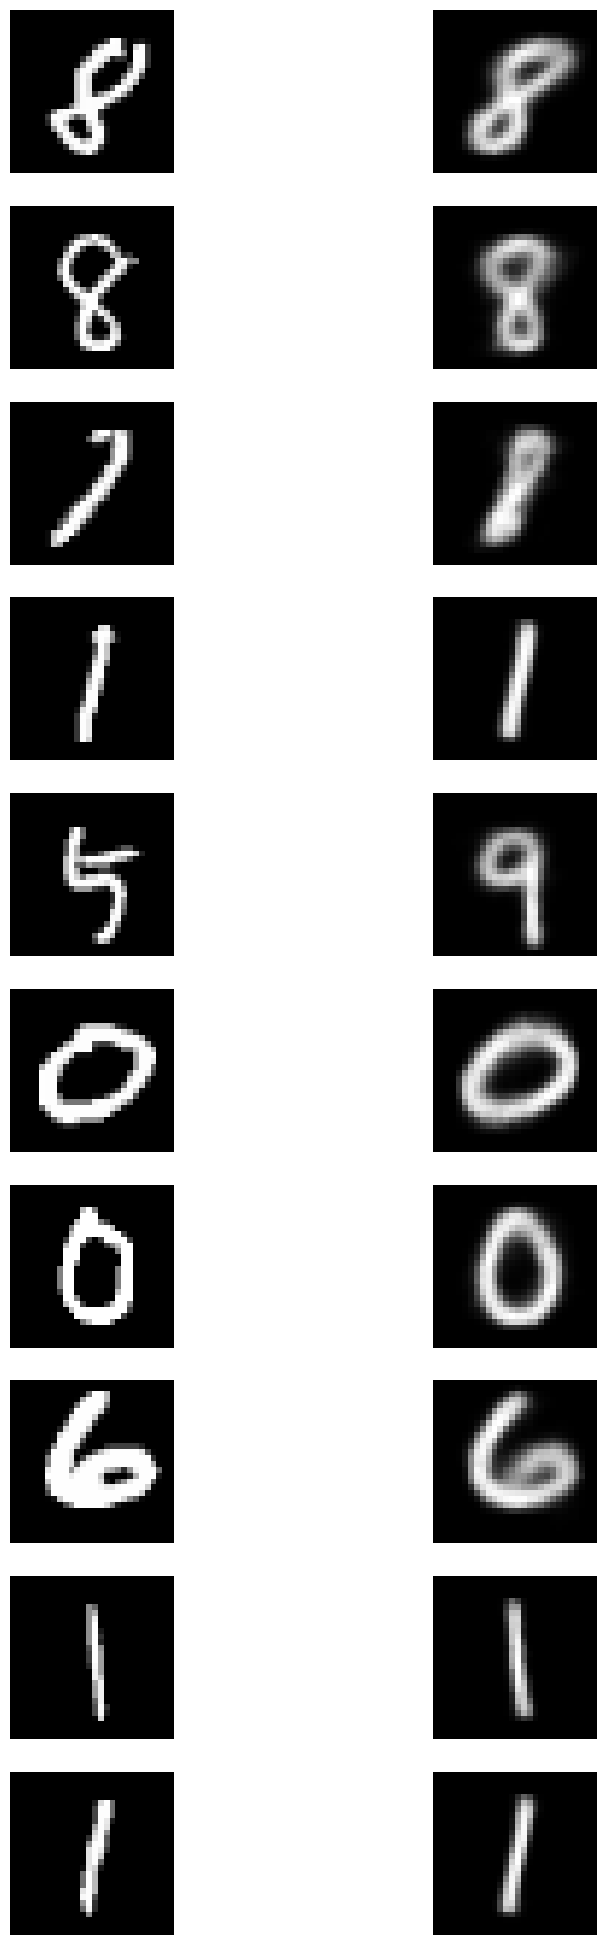

Epoch 52/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.0534 - reconstruction_loss: 134.0046 - kl_loss: 7.0992


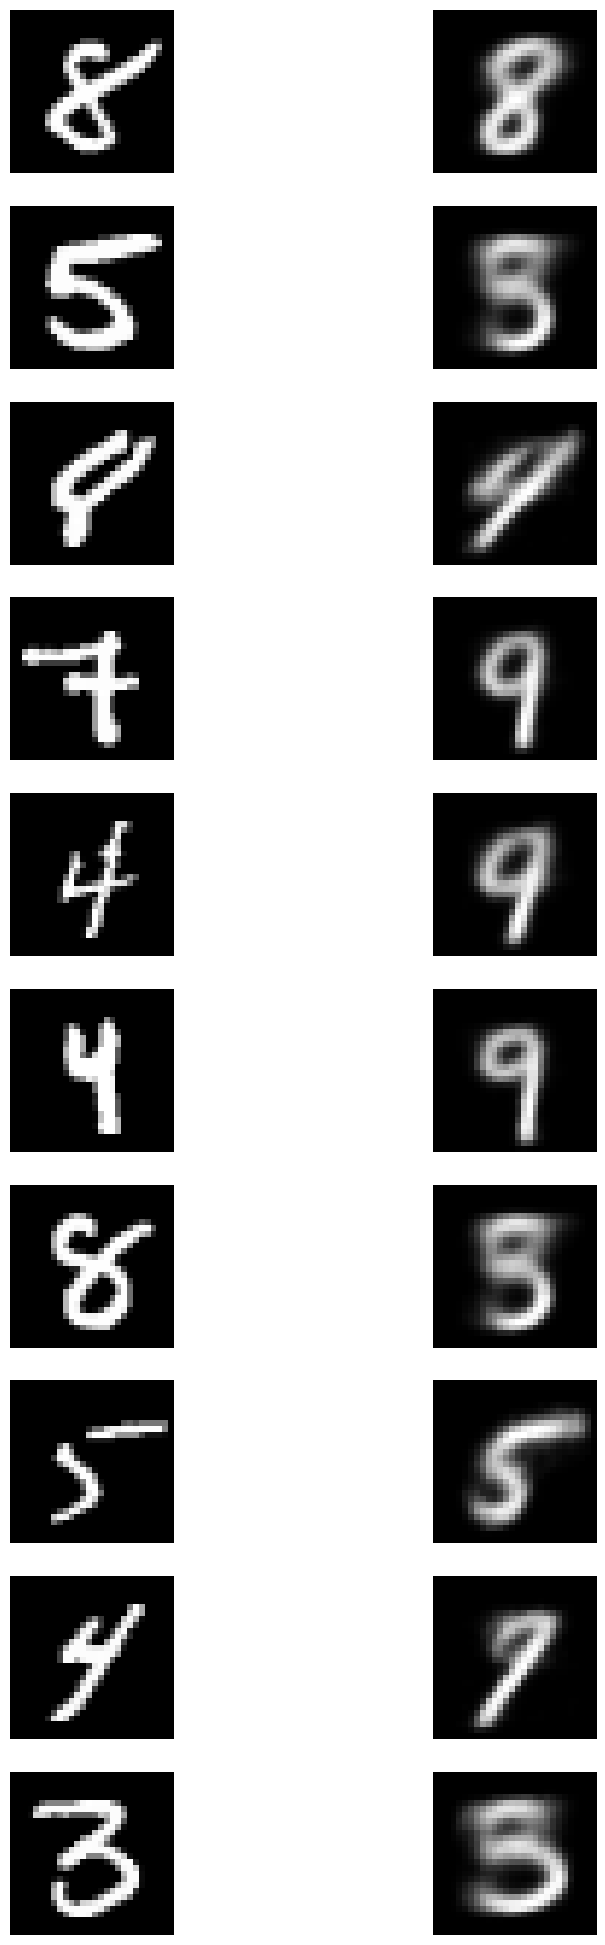

Epoch 53/300
2188/2188 [==============================] - 9s 4ms/step - loss: 140.8970 - reconstruction_loss: 134.0248 - kl_loss: 7.1266


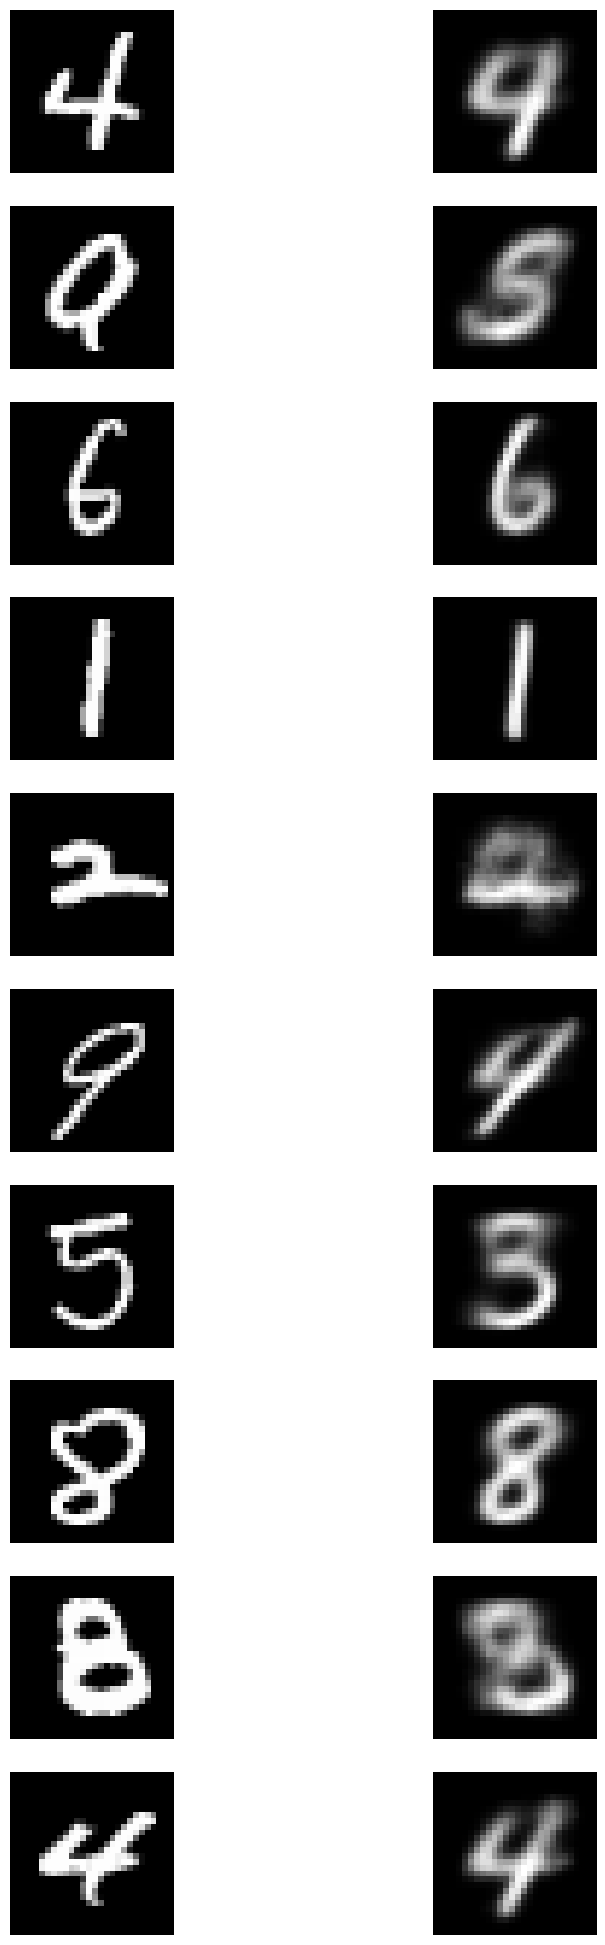

Epoch 54/300
2188/2188 [==============================] - 9s 4ms/step - loss: 141.0338 - reconstruction_loss: 133.9177 - kl_loss: 7.1191


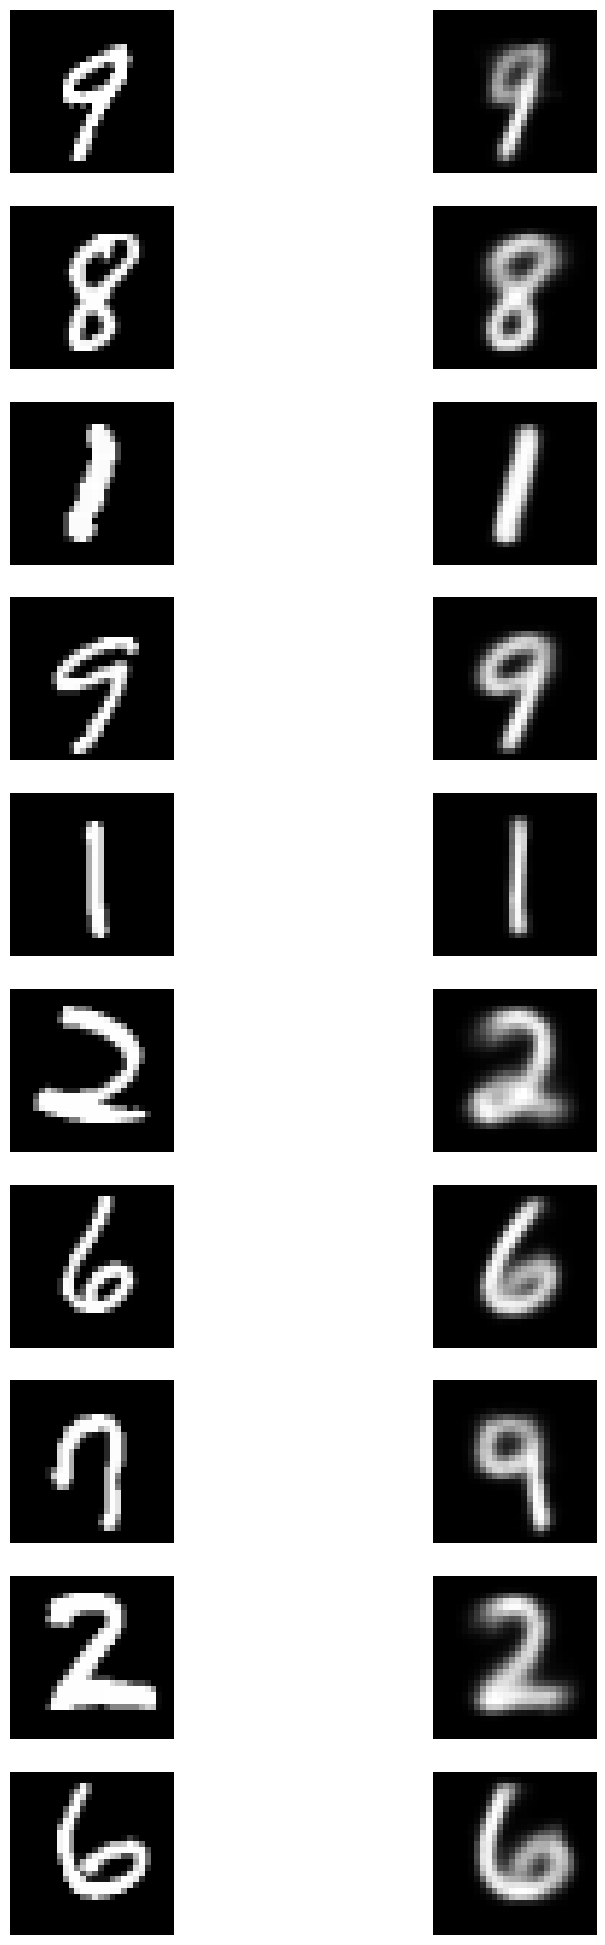

Epoch 55/300
2188/2188 [==============================] - 8s 4ms/step - loss: 140.9371 - reconstruction_loss: 133.9698 - kl_loss: 7.1422


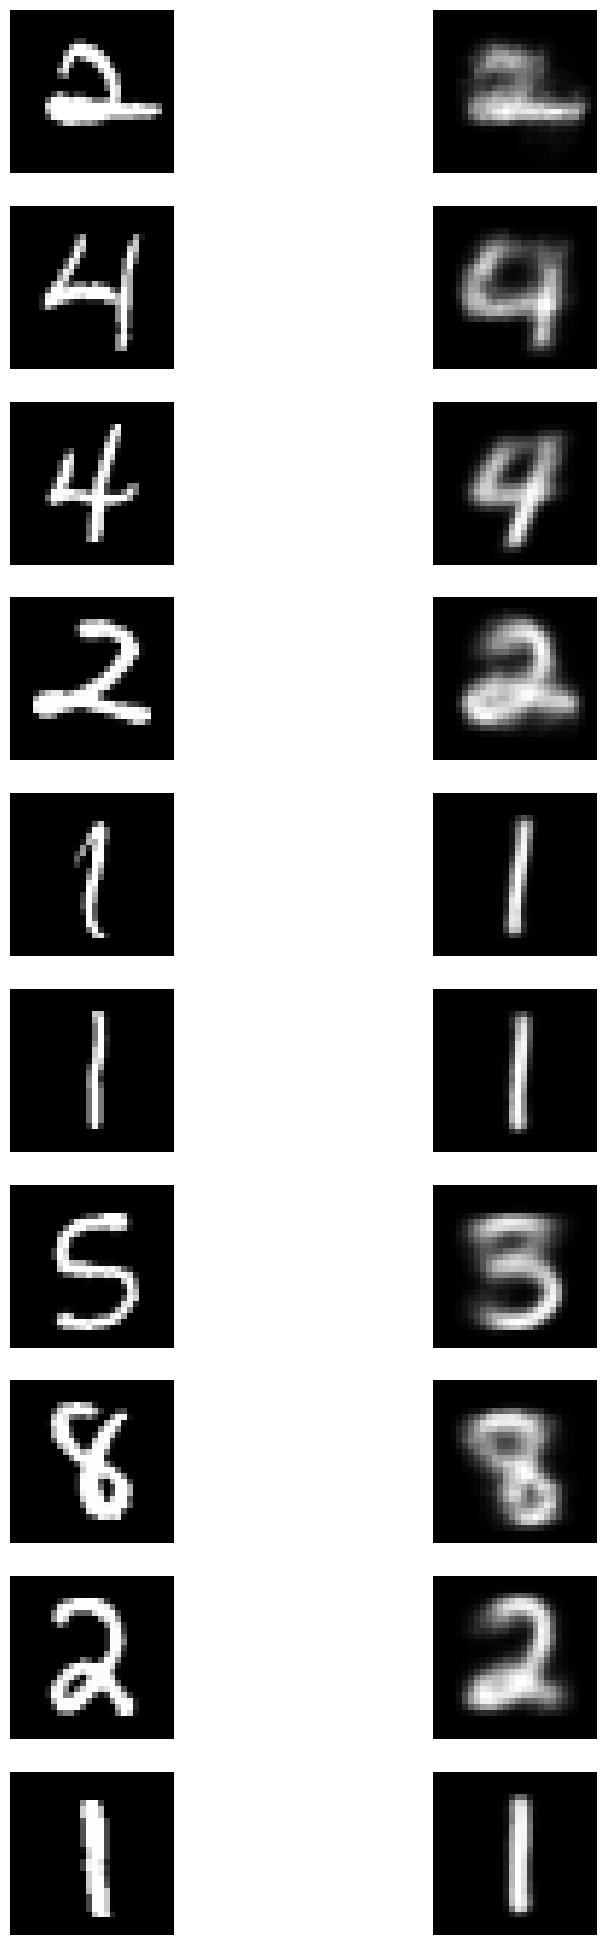

Epoch 56/300
2188/2188 [==============================] - 9s 4ms/step - loss: 141.0028 - reconstruction_loss: 134.0112 - kl_loss: 7.1165


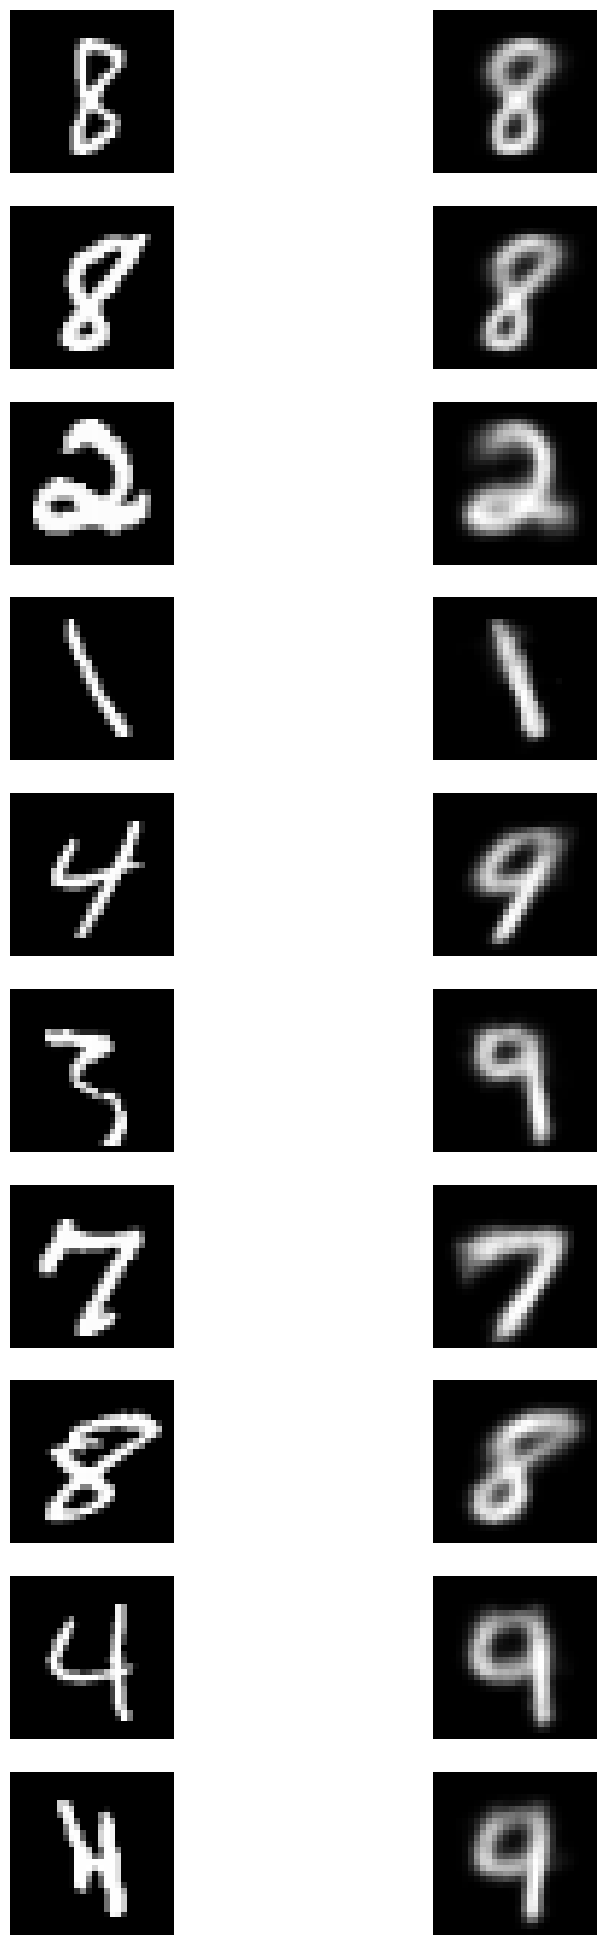

Epoch 57/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.0065 - reconstruction_loss: 134.0003 - kl_loss: 7.1318


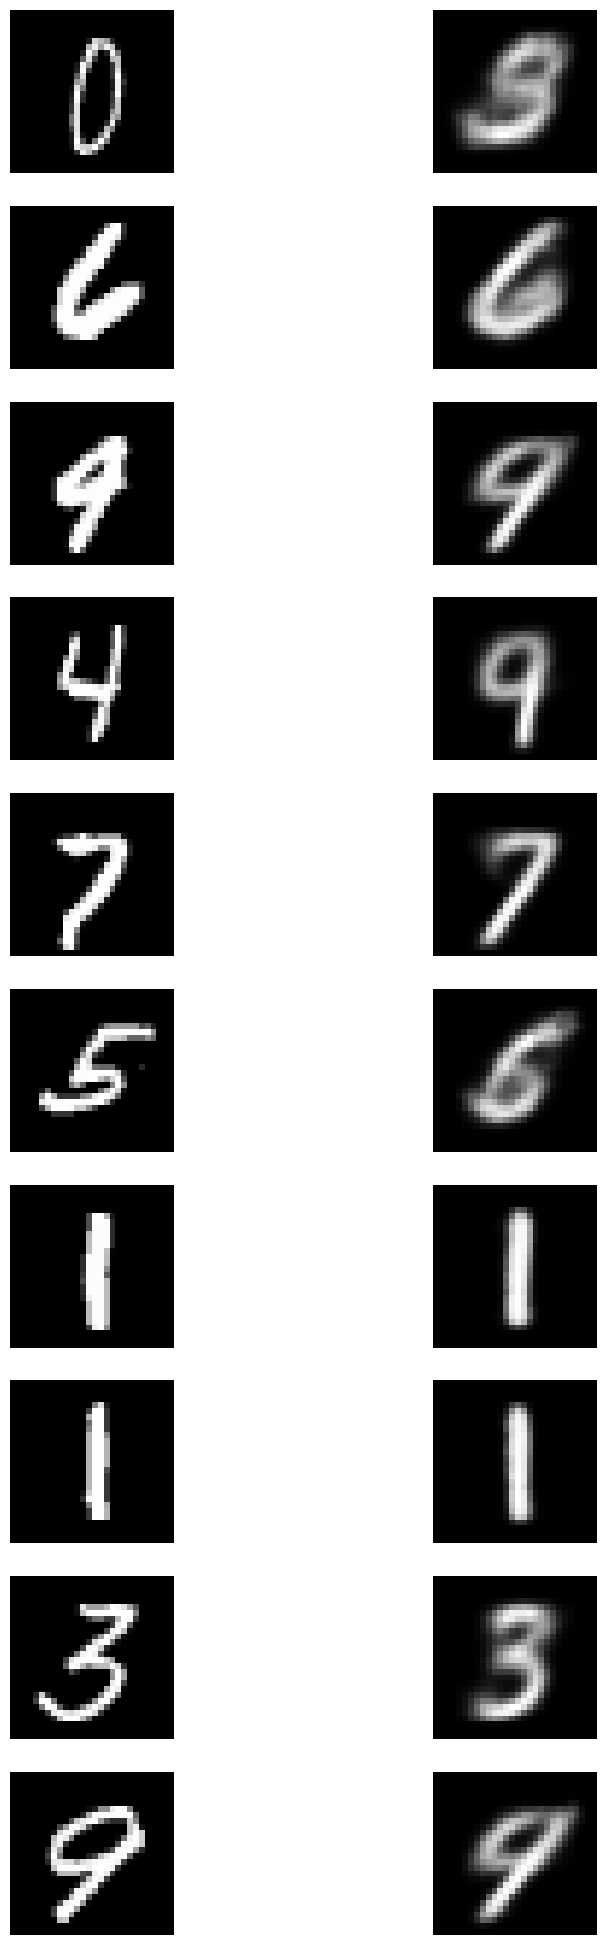

Epoch 58/300
2188/2188 [==============================] - 9s 4ms/step - loss: 141.7029 - reconstruction_loss: 134.0910 - kl_loss: 7.1140


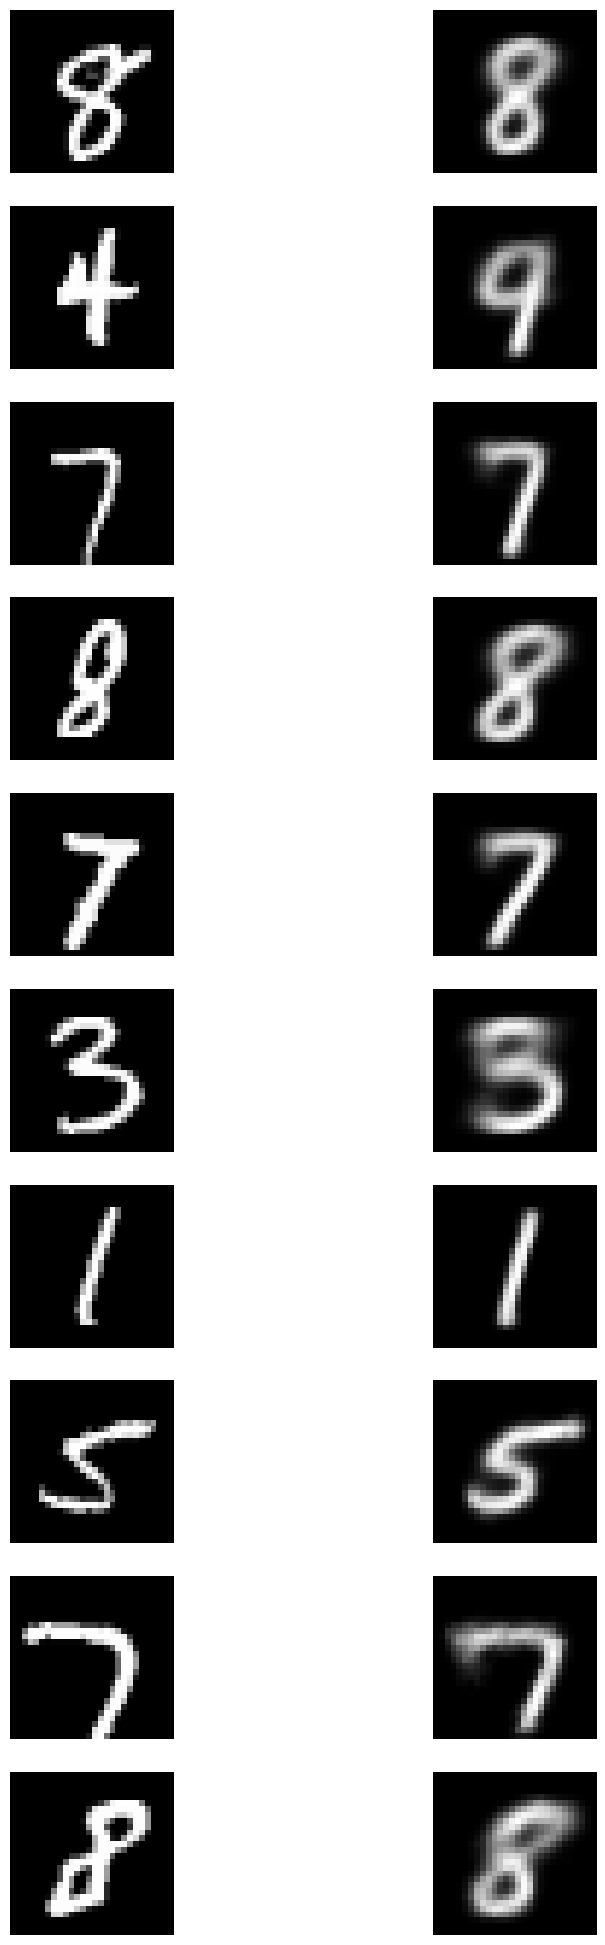

Epoch 59/300
2188/2188 [==============================] - 9s 4ms/step - loss: 141.2642 - reconstruction_loss: 134.0949 - kl_loss: 7.1201


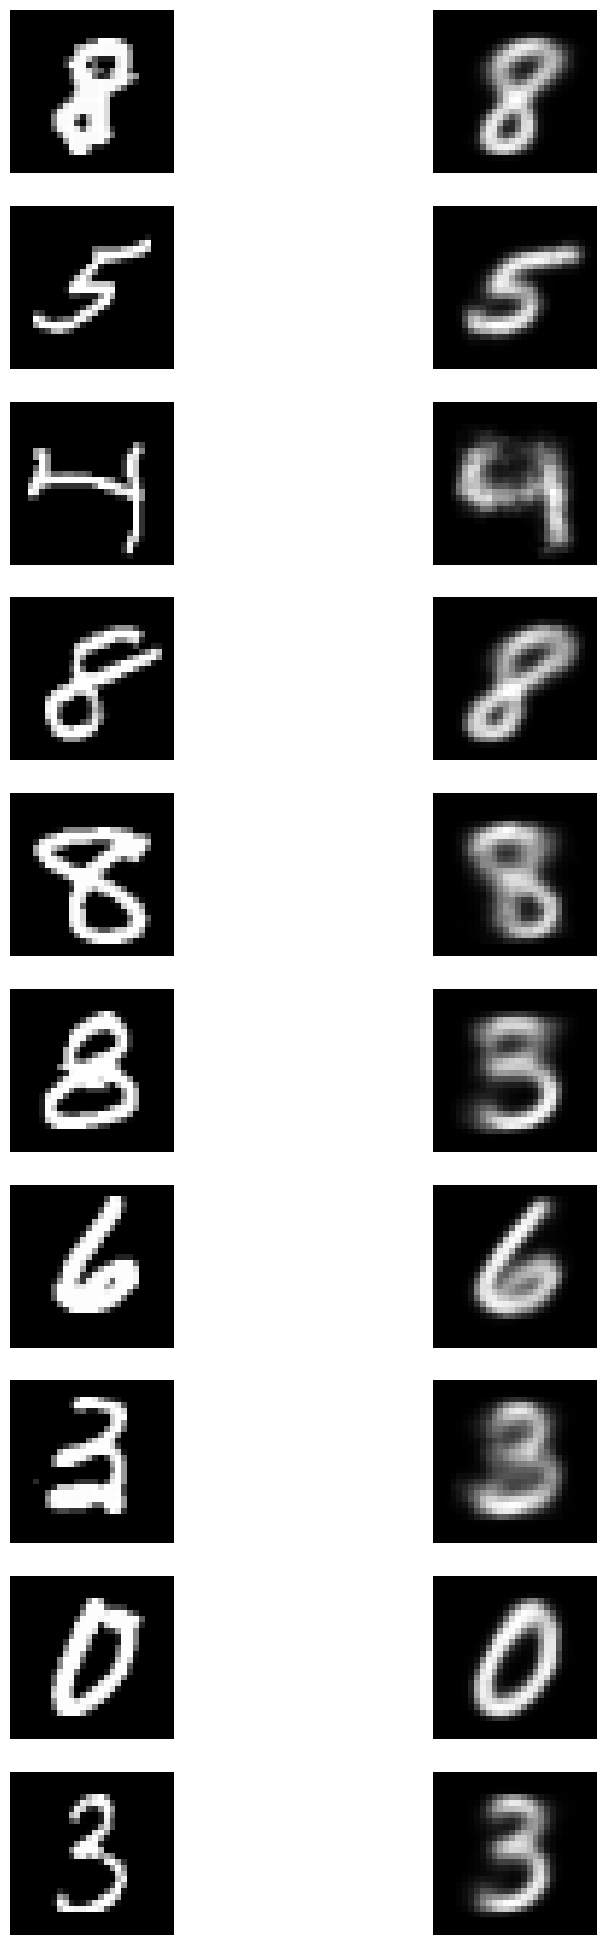

Epoch 60/300
2188/2188 [==============================] - 20s 9ms/step - loss: 141.5083 - reconstruction_loss: 133.9557 - kl_loss: 7.1179


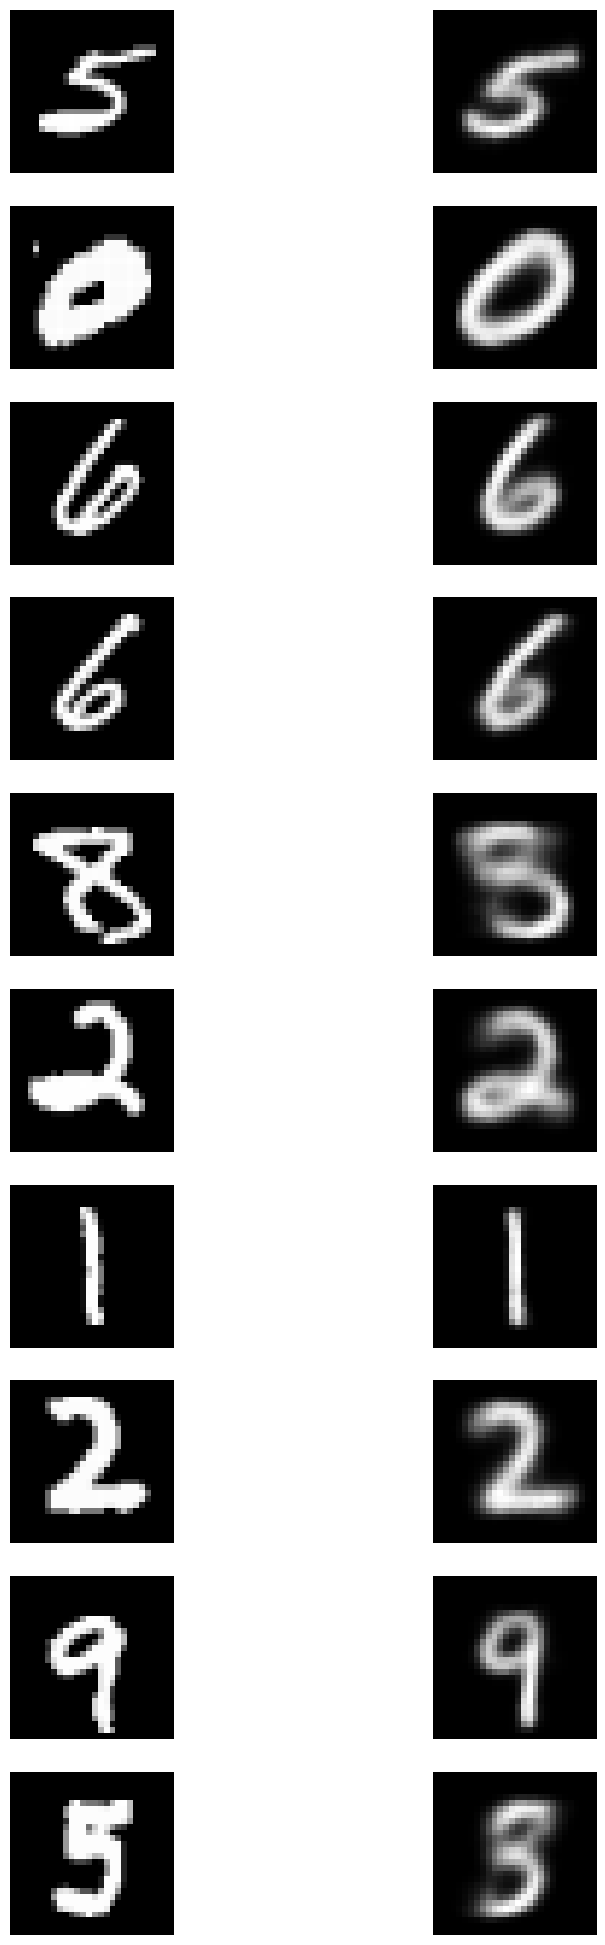

Epoch 61/300
2188/2188 [==============================] - 8s 4ms/step - loss: 141.2238 - reconstruction_loss: 134.0121 - kl_loss: 7.1019


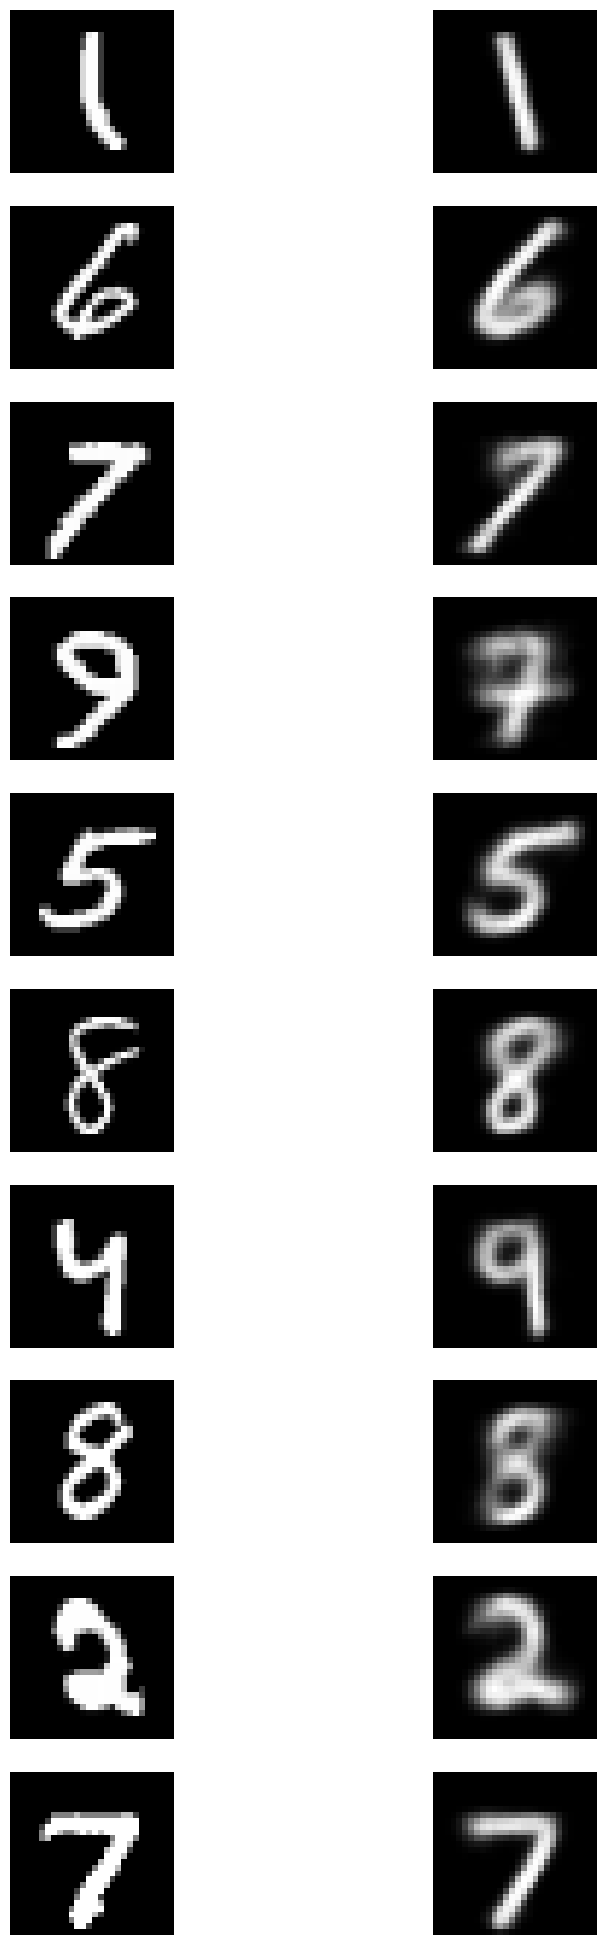

Epoch 62/300
2188/2188 [==============================] - 14s 7ms/step - loss: 141.2711 - reconstruction_loss: 133.9404 - kl_loss: 7.1373


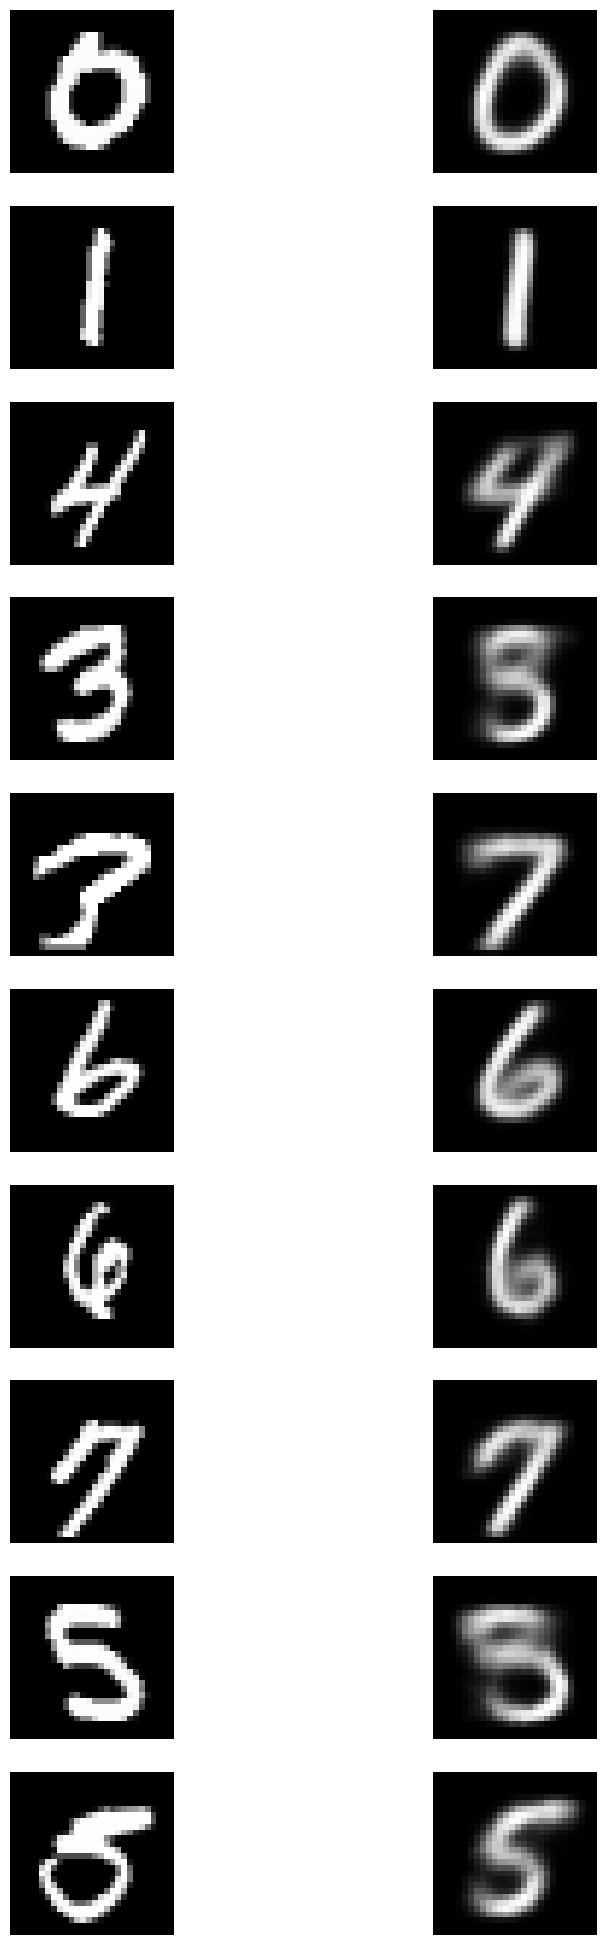

Epoch 63/300
2188/2188 [==============================] - 27s 12ms/step - loss: 140.9948 - reconstruction_loss: 134.0141 - kl_loss: 7.1157


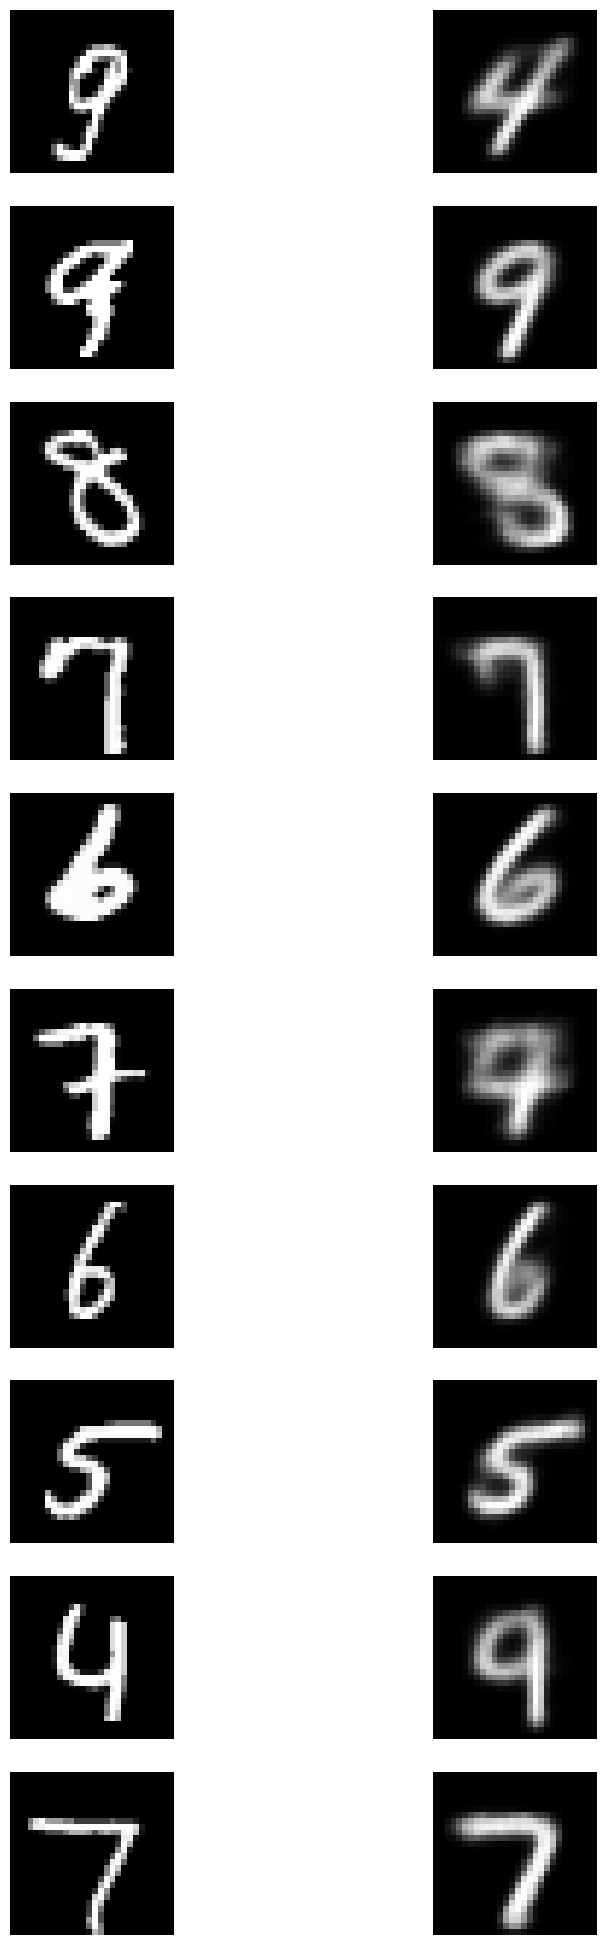

Epoch 64/300
2188/2188 [==============================] - 37s 17ms/step - loss: 140.9760 - reconstruction_loss: 133.9839 - kl_loss: 7.1330


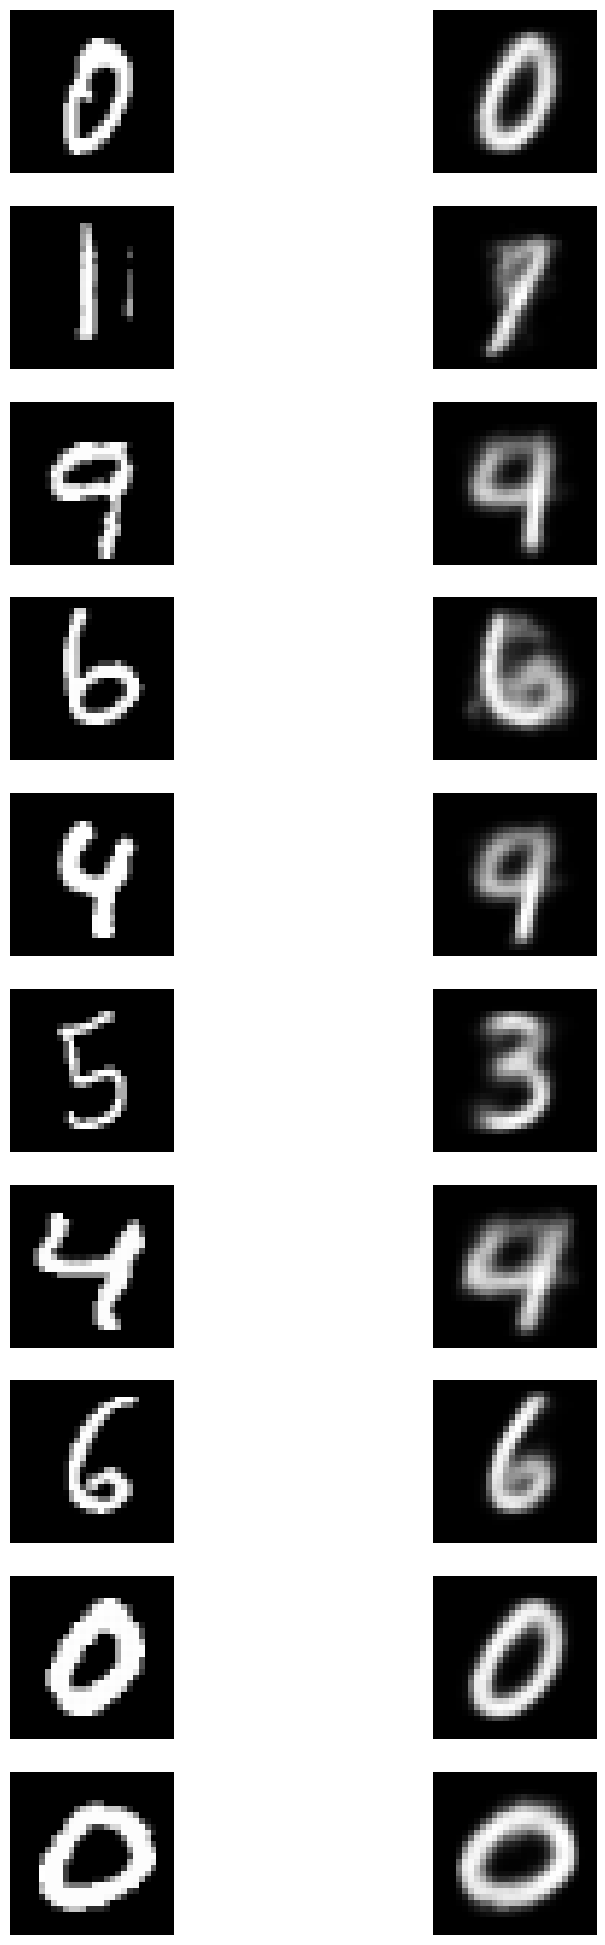

Epoch 65/300
 627/2188 [=======>......................] - ETA: 2:35 - loss: 140.6834 - reconstruction_loss: 133.7519 - kl_loss: 7.1126

KeyboardInterrupt: 

In [50]:
# Create a test batch of random noise to generate decoded images
test_input = tf.random.normal(shape=(100, 2))

# Create an instance of the DecodeCallback
decode_callback = DecodeCallback(vae, mnist_digits[0])
vae_callback = VAECallback(vae, mnist_digits)
# Fit the VAE model with the DecodeCallback
history = vae.fit(mnist_digits, epochs=300, callbacks=[vae_callback])


In [32]:

class ImagePredictionCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, validation_data, output_dir, num_images=10):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        self.output_dir = output_dir
        self.num_images = num_images

    def on_epoch_end(self, epoch, logs=None):
        # Generate predicted images from the validation set
        x_val = next(iter(self.validation_data))[0][:self.num_images]
        predicted_images = self.model.predict(x_val)

        # Save the predicted images to a folder
        os.makedirs(self.output_dir, exist_ok=True)
        for i in range(self.num_images):
            plt.imsave(os.path.join(self.output_dir, f"epoch_{epoch}_image_{i}.png"), predicted_images[i])


In [35]:
# Define the output directory for the predicted images
output_dir = "predicted_images"

# Create an instance of the callback and add it to the training process
prediction_callback = ImagePredictionCallback(vae, mnist_digits, output_dir)
history = vae.fit(mnist_digits, epochs=300,  callbacks=[prediction_callback])


Epoch 1/300
2188/2188 [==============================] - 103s 47ms/step - loss: 141.1229 - reconstruction_loss: 134.0390 - kl_loss: 7.1718


ValueError: in user code:

    c:\Users\kkosara\.conda\envs\tf_baseline_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1584 predict_function  *
        return step_function(self, iterator)
    C:\Users\kkosara\AppData\Local\Temp\ipykernel_25912\864694591.py:20 call  *
        z_mean, z_log_var, z = self.encoder(x)
    c:\Users\kkosara\.conda\envs\tf_baseline_gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1057 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    c:\Users\kkosara\.conda\envs\tf_baseline_gpu\lib\site-packages\tensorflow\python\keras\engine\functional.py:420 call
        return self._run_internal_graph(
    c:\Users\kkosara\.conda\envs\tf_baseline_gpu\lib\site-packages\tensorflow\python\keras\engine\functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\Users\kkosara\.conda\envs\tf_baseline_gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1040 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\Users\kkosara\.conda\envs\tf_baseline_gpu\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:230 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer conv2d_2 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 1)
